<a href="https://colab.research.google.com/github/artie93/Analyzing-International-Debt-Statistics/blob/main/Case_Data_Master_ArturHermano.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# **CASE PARA CERTIFICAÇÃO COMO CIENTISTA DE DADOS - SANTANDER**
## **Artur Hermano Sampaio Dias**
## **São Paulo, 2025**

**PROBLEMA**

Os datasets user_logs.parquet, transactions.parquet e members.parquet representam o histórico de 2 anos (2015-2017) de uma empresa - "*Musicfy*" - que oferece serviço de streaming de música baseado em assinatura. Quando os usuários se inscrevem no serviço, eles podem optar por renovar o serviço manualmente ou automaticamente. Os usuários podem cancelar ativamente sua associação a qualquer momento.


Quando a *Musicfy* detecta que um cliente deixa de renovar sua assinatura, lhe é oferecido 3 meses grátis. Porém, a *Musicfy* reconhece que esta abordagem é muito reativa, e deseja alcançar seus clientes de uma forma proativa que seja mais efetiva.


Sendo assim, é proposto que criemos um modelo classificador para prever clientes que serão 'churn' dentro de 3 meses no futuro, ou seja, clientes que estão ativos na data analisada, mas em até 3 meses deixarão de ser assinantes porque cancelaram ou não renovaram sua assinatura. Esses clientes então marcados como 'churn' receberão a ação dos 3 meses grátis numa estratégia de retê-los por mais tempo.


Adicionalmente, realizaremos uma análise não-supervisionada dos clientes com o objetivo de aprofundar a compreensão sobre suas características.

**RESOLUÇÃO**

# 0 - PREPARAÇÃO

In [6]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


Imports e instalações necessários:

In [7]:
!pip install pyspark

In [8]:
!pip install -q catboost

O código abaixo foi necessário para a instalação da versão do catboost otimizada para GPUs, de forma a tornar viável a futura etapa de otimização de hiperparâmetros.

In [3]:
!pip uninstall -y catboost
!pip install catboost --extra-index-url https://storage.googleapis.com/catboost-wheels/ubuntu/20.04/x86_64

Looking in indexes: https://pypi.org/simple, https://storage.googleapis.com/catboost-wheels/ubuntu/20.04/x86_64
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 99.2/99.2 MB 24.6 MB/s eta 0:00:00


In [9]:
!pip install -q -U ks-metric
!pip install -q -U scikit-plot
!pip install -q -U scikit-optimize

Spark

In [10]:
from pyspark.sql import SparkSession

spark = SparkSession.builder \
    .appName("ColabPro_Spark") \
    .config("spark.sql.execution.arrow.pyspark.enabled", "true") \
    .config("spark.driver.memory", "12g") \
    .config("spark.executor.memory", "8g")\
    .getOrCreate()

Imports

In [11]:
import random
import gc

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import sys
from os import truncate

from catboost.utils import get_roc_curve
from catboost import CatBoostClassifier, Pool
from sklearn.utils.class_weight import compute_class_weight

from ks_metric import ks_score

from pyspark.sql import functions as F
from pyspark.sql import Window
from pyspark.sql.types import DoubleType, IntegerType

from skopt import BayesSearchCV
from skopt.space import Real, Integer, Categorical

from sklearn import metrics
from sklearn.metrics import confusion_matrix
from sklearn.metrics import roc_auc_score
from sklearn.metrics import recall_score
from sklearn.metrics import classification_report
from sklearn.metrics import average_precision_score, make_scorer
from sklearn.metrics import calinski_harabasz_score, davies_bouldin_score
from sklearn.model_selection import StratifiedKFold

from sklearn.cluster import KMeans
from sklearn.preprocessing import StandardScaler
from sklearn.impute import SimpleImputer
from sklearn.decomposition import PCA

Funções

In [37]:
# função para tratar nulos - será usada quando realizarmos os cálculos de PSI, CSI e Lift do modelo
def trata_nulos(df):
  cat_cols = categorical_cols
  cat_cols = [col for col in cat_cols if col in df.columns]
  num_cols = [col for col in df.columns if col not in cat_cols]
  for col in cat_cols:
    df[col] = df[col].astype('str')
  df[cat_cols] = df[cat_cols].fillna('None')
  df[cat_cols] = df[cat_cols].replace({'nan', 'None'})
  df[num_cols] = df[num_cols].fillna(0)
  return df

# função para computar o coeficiente angular de uma sequência de pontos - será usada quando realizarmos feature engineering
# para analisarmos com mais detalhe a evolução de uma feature ao longo do tempo
def compute_slope(time_list, value_list):
    if time_list is None or value_list is None or len(time_list) < 2:
        return None
    try:
        slope = np.polyfit(time_list, value_list, 1)[0]
        return float(slope)
    except Exception as e:
        return None

# função para criar a target (coluna 'churn_target') do modelo supervisionado
def gera_target(df):
  w = Window.partitionBy("msno").orderBy("safra")

  # Passo 1 - Identificando o início de um novo segmento:
  df_seg = df.withColumn("prev_cancel", F.lag("is_cancel").over(w))\
      .withColumn("new_segment", F.when(F.col("prev_cancel").isNull() | (F.col("prev_cancel") == 1), 1).otherwise(0))
          # para cada cliente, pegamos o valor de 'is_cancel' da safra anterior
          # se prev_cancel.isNull(),
          # significa que é o primeiro
          # registro do cliente, e se
          # F.col("prev_cancel") == 1,
          # significa que o registro anterior
          # daquele cliente foi um
          # cancelamento, ou seja, o
          # cliente está entrando
          # novamente na base de assinantes,
          # portanto iniciando um novo segmento

  # Passo 2 - Gerando um identificador de segmento (cumulativo)
  w_unbounded = Window.partitionBy("msno").orderBy("safra").rowsBetween(Window.unboundedPreceding, 0)
    # criamos uma janela acumulativa por cliente,
    # ordenando pela safra, da primeira linha até a atual.

  df_seg = df_seg.withColumn("segment_id", F.sum("new_segment").over(w_unbounded))
    # acumula os marcadores de segmento
    # (1 onde começa) para criar um segment_id único.

  # Passo 3 - Definindo a target de churn para cada safra dentro de cada segmento.
    # usamos uma janela que particiona por cliente e segment_id e ordena por safra.
  w_future = Window.partitionBy("msno", "segment_id").orderBy("safra").rowsBetween(1, 3) # 3 meses no futuro

  df_seg = df_seg.withColumn("churn_target", F.max("is_cancel").over(w_future))
    # se houver algum 1 nos próximos 3 meses, o churn_target é 1; senão, é 0 ou NULL

  df_churn = df_seg.filter(F.col('churn_target').isNotNull())\
    .drop('first_churn_safra', 'new_segment', 'prev_cancel', 'membership_expire_date', 'registration_init_time')
    # Além de tirar os registros cuja target é marcada como nula, também removemos aqui colunas que são desnecessárias para a modelagem preditiva.

  return df_churn

# função para converter o tipo de certas colunas de um dataframe em 'inteiro', além de remover a coluna 'transaction_date' - usada
# na etapa de preparação de dados antes da modelagem
def preprocess_dataframe(df):
    cols_to_int = ['actual_amount_paid', 'payment_plan_days', 'actual_plan_list_price', 'month',
                   'churn_target', 'is_auto_renew']
    for col_name in cols_to_int:
        df = df.withColumn(col_name, df[col_name].cast(IntegerType()))
    df = df.drop('transaction_date')
    return df

# função para cálculo da área sob a curva Precision-Recall, que é uma forma mais confiável de capturar a performance de um modelo
# classificador sobre classes desbalanceadas
def prauc_score_func(estimator, X, y):
    y_proba = estimator.predict_proba(X)[:, 1]
    return average_precision_score(y, y_proba)

# a partir de um modelo treinado, essa função calcula AUC e KS para cada safra individualmente de um dataframe df
def calculate_metrics_by_safra(df, model, features, target_col='churn_target', safra_col='safra'):
    results = []
    for safra in df[safra_col].unique():
        df_safra = df[df[safra_col] == safra]
        X_safra = df_safra[features]
        y_safra = df_safra[target_col]

        y_pred_proba = model2.predict_proba(X_safra)[:, 1]
        auc = roc_auc_score(y_safra, y_pred_proba)
        ks = ks_score(y_safra, y_pred_proba)

        results.append({'safra': safra, 'AUC': auc, 'KS': ks})
    return pd.DataFrame(results)

# esta função cria diversas features a partir das features originais nos datasets disponibilizados
def feature_engineer(df):
    window = Window.partitionBy('msno', 'segment_id').orderBy(F.col('safra').desc())
    window_3 = Window.partitionBy('msno', 'segment_id').orderBy('time_index').rowsBetween(-2, 0)

    df = df.drop('bd', 'city', 'gender', 'registered_via', 'is_ativo', 'is_cancel')\
    .fillna(0, ['num_100', 'num_985', 'num_75', 'num_50', 'num_25', 'num_unq', 'total_secs'])\
    .withColumn('month', F.substring('safra', 5, 2))\
    .withColumn('plan_value', F.col('actual_amount_paid')/(F.col('payment_plan_days')+0.1))\
    .withColumn('plan_rank', F.col('actual_plan_list_price')/(F.col('payment_plan_days')+0.1))\
    .withColumn('fidelity', F.col('total_secs')/(F.col('num_unq')+0.1))\
    .withColumn('engagement_per_track', (F.col('num_25')+F.col('num_50')+F.col('num_75')+F.col('num_985')+F.col('num_100'))/F.col('num_unq'))\
    .withColumn('diff1_num_100', F.col('num_100') - F.lag(F.col('num_100'), 1, 0).over(window))\
    .withColumn('diff1_num_985', F.col('num_985') - F.lag(F.col('num_985'), 1, 0).over(window))\
    .withColumn('diff1_num_75', F.col('num_75') - F.lag(F.col('num_75'), 1, 0).over(window))\
    .withColumn('diff1_num_50', F.col('num_50') - F.lag(F.col('num_50'), 1, 0).over(window))\
    .withColumn('diff1_num_25', F.col('num_25') - F.lag(F.col('num_25'), 1, 0).over(window))\
    .withColumn('diff1_num_unq', F.col('num_unq') - F.lag(F.col('num_unq'), 1, 0).over(window))\
    .withColumn('diff2_num_100', F.col('num_100') - F.lag(F.col('num_100'), 2, 0).over(window))\
    .withColumn('diff2_num_985', F.col('num_985') - F.lag(F.col('num_985'), 2, 0).over(window))\
    .withColumn('diff2_num_75', F.col('num_75') - F.lag(F.col('num_75'), 2, 0).over(window))\
    .withColumn('diff2_num_50', F.col('num_50') - F.lag(F.col('num_50'), 2, 0).over(window))\
    .withColumn('diff2_num_25', F.col('num_25') - F.lag(F.col('num_25'), 2, 0).over(window))\
    .withColumn('diff2_num_unq', F.col('num_unq') - F.lag(F.col('num_unq'), 2, 0).over(window))\
    .withColumn('diff3_num_100', F.col('num_100') - F.lag(F.col('num_100'), 3, 0).over(window))\
    .withColumn('diff3_num_985', F.col('num_985') - F.lag(F.col('num_985'), 3, 0).over(window))\
    .withColumn('diff3_num_75', F.col('num_75') - F.lag(F.col('num_75'), 3, 0).over(window))\
    .withColumn('diff3_num_50', F.col('num_50') - F.lag(F.col('num_50'), 3, 0).over(window))\
    .withColumn('diff3_num_25', F.col('num_25') - F.lag(F.col('num_25'), 3, 0).over(window))\
    .withColumn('diff3_num_unq', F.col('num_unq') - F.lag(F.col('num_unq'), 3, 0).over(window))\
    .withColumn('diff1_fidelity', F.col('fidelity') - F.lag(F.col('fidelity'), 1, 0).over(window))\
    .withColumn('diff2_fidelity', F.col('fidelity') - F.lag(F.col('fidelity'), 2, 0).over(window))\
    .withColumn('diff3_fidelity', F.col('fidelity') - F.lag(F.col('fidelity'), 3, 0).over(window))\
    .withColumn('diff1_engagement_per_track', F.col('engagement_per_track') - F.lag(F.col('engagement_per_track'), 1, 0).over(window))\
    .withColumn('diff2_engagement_per_track', F.col('engagement_per_track') - F.lag(F.col('engagement_per_track'), 2, 0).over(window))\
    .withColumn('diff3_engagement_per_track', F.col('engagement_per_track') - F.lag(F.col('engagement_per_track'), 3, 0).over(window))\
    .withColumn('evolving_diff_num_100', F.col('diff1_num_100') - F.lag('diff1_num_100', 1, 0).over(window))\
    .withColumn('evolving_diff_num_985', F.col('diff1_num_985') - F.lag('diff1_num_985', 1, 0).over(window))\
    .withColumn('evolving_diff_num_75', F.col('diff1_num_75') - F.lag('diff1_num_75', 1, 0).over(window))\
    .withColumn('evolving_diff_num_50', F.col('diff1_num_50') - F.lag('diff1_num_50', 1, 0).over(window))\
    .withColumn('evolving_diff_num_25', F.col('diff1_num_25') - F.lag('diff1_num_25', 1, 0).over(window))\
    .withColumn('evolving_diff_num_unq', F.col('diff1_num_unq') - F.lag('diff1_num_unq', 1, 0).over(window))\
    .withColumn('evolving_diff_fidelity', F.col('diff1_fidelity') - F.lag('diff1_fidelity', 1, 0).over(window))\
    .withColumn('evolving_diff_engagement_per_track', F.col('diff1_engagement_per_track') - F.lag('diff1_engagement_per_track', 1, 0).over(window))\
    .withColumn("time_index", F.row_number().over(window).cast("double"))\
    .withColumn("time_list", F.collect_list("time_index").over(window_3))\
    .withColumn("total_secs_list", F.collect_list("total_secs").over(window_3))\
    .withColumn('num_unq_list', F.collect_list("num_unq").over(window_3))\
    .withColumn('num_25_list', F.collect_list("num_25").over(window_3))\
    .withColumn('num_50_list', F.collect_list("num_50").over(window_3))\
    .withColumn('num_75_list', F.collect_list("num_75").over(window_3))\
    .withColumn('num_985_list', F.collect_list("num_985").over(window_3))\
    .withColumn('num_100_list', F.collect_list("num_100").over(window_3))\
    .withColumn('fidelity_list', F.collect_list("fidelity").over(window_3))\
    .withColumn('engagement_per_track_list', F.collect_list("engagement_per_track").over(window_3))\
    .withColumn("slope_total_secs", compute_slope_udf(F.col("time_list"), F.col("total_secs_list")))\
    .withColumn("slope_num_unq", compute_slope_udf(F.col("time_list"), F.col("num_unq_list")))\
    .withColumn("slope_num_25", compute_slope_udf(F.col("time_list"), F.col("num_25_list")))\
    .withColumn("slope_num_50", compute_slope_udf(F.col("time_list"), F.col("num_50_list")))\
    .withColumn("slope_num_75", compute_slope_udf(F.col("time_list"), F.col("num_75_list")))\
    .withColumn("slope_num_985", compute_slope_udf(F.col("time_list"), F.col("num_985_list")))\
    .withColumn("slope_num_100", compute_slope_udf(F.col("time_list"), F.col("num_100_list")))\
    .withColumn("slope_fidelity", compute_slope_udf(F.col("time_list"), F.col("fidelity_list")))\
    .withColumn("slope_engagement_per_track", compute_slope_udf(F.col("time_list"), F.col("engagement_per_track_list")))\
    .drop('time_index', 'time_list', 'total_secs_list', 'num_unq_list', 'num_25_list', 'num_50_list', 'num_75_list', 'num_985_list', 'num_100_list', 'fidelity_list', 'engagement_per_track_list')
    return df

# esta função calcula o lift a partir de um dataframe com as porcentagens preditas e as targets
def lift(df, qcut=False):
  if qcut == False:
    df['bucket'] = pd.cut(df['prob'], [0, .1, .2, .3, .4, .5, .6, .7, .8, .9, 1], labels=range(1, 11))
  else:
    df['rank'] = df['prob'].rank(ascending=True, method='first')
    df['bucket'] = pd.qcut(df['rank'], 10, labels=range(1, 11), duplicates='drop')
  lift = df.groupby('bucket').agg(['count', 'sum'])['churn'].sort_index(ascending=False)

  total_pos = df[df['churn']==1].shape[0]

  percent_total = total_pos / df.shape[0]

  lift.columns = ['Número de clientes', 'Número de churns']
  lift['Churn acumulados'] = lift['Número de churns'].cumsum()

  lift['% churn'] = lift['Número de churns'] / lift['Número de clientes']
  lift['% events'] = lift['Número de churns'] / lift['Número de churns'].sum()*100
  lift['LIFT'] = lift['% churn']/percent_total

  lift['check'] = np.where(lift['LIFT'] >= 1, 'OK', '--')

  return lift.head(10)

# esta função calcula o Population Stability Index a partir de dois dataframes para quantificar a mudança de distribuição
# de scores de uma população ao longo do tempo
def psi(df1, df2, buckets=10):
  breakpoints = np.linspace(0, 1, buckets+1)

  counts1 = np.histogram(df1, bins=breakpoints)[0]
  counts2 = np.histogram(df2, bins=breakpoints)[0]

  ratios1 = counts1 / len(df1)
  ratios2 = counts2 / len(df2)

  psi_values = (ratios1 - ratios2) * np.log(ratios1 / ratios2)

  psi_values = np.where(np.isfinite(psi_values), psi_values, 0)

  psi = np.sum(psi_values)

  return psi

# esta função bucketiza as variáveis de dois dataframes em preparação para o cálculo do Characteristic Stability Index (CSI)
def discretizar_variaveis(df1, df2, n_bins=10):
  referencia = trata_nulos(df1)
  teste = trata_nulos(df2)

  resultado = []

  for col in referencia.columns:
    if pd.api.types.is_numeric_dtype(referencia[col]) and pd.api.types.is_numeric_dtype(teste[col]):
      dados_combinados = pd.concat([referencia[col], teste[col]])
      min_val = dados_combinados.min()
      max_val = dados_combinados.max()

      buffer = (max_val - min_val) * 0.01
      min_val -= buffer
      max_val += buffer

      if pd.isna(min_val) or pd.isna(max_val):
        continue

      if min_val == max_val:
        splits = np.linspace(min_val, min_val + n_bins, n_bins + 1)
      else:
        splits = np.linspace(min_val, max_val, n_bins + 1)

      df_referencia_buckets = pd.cut(referencia[col], bins=splits, labels=False, include_lowest=True)
      df_teste_buckets = pd.cut(teste[col], bins=splits, labels=False, include_lowest=True)

      for i in range(n_bins):
        prop_referencia = (df_referencia_buckets == i).sum() / len(referencia)
        prop_teste = (df_teste_buckets == i).sum() / len(teste)
        resultado.append({
            'variavel': col,
            'bucket': i,
            'prop_referencia': prop_referencia,
            'prop_teste': prop_teste
        })
    elif pd.api.types.is_categorical_dtype(referencia[col]) or pd.api.types.is_object_dtype(teste[col]):
      categorias = referencia[col].unique()
      for categoria in categorias:
        prop_referencia = (referencia[col] == categoria).sum() / len(referencia)
        prop_teste = (teste[col] == categoria).sum() / len(teste)
        resultado.append({
            'variavel': col,
            'bucket': categoria,
            'prop_referencia': prop_referencia,
            'prop_teste': prop_teste
        })
  resultado_df = pd.DataFrame(resultado)
  return resultado_df

# a partir do resultado da função acima (resultado_df), esta função aplica a fórmula do CSI para obter
# a variação de cada feature (variável) entre os dois dataframes originalmente fornecidos à função
# discretizar_variaveis, retornando então um dataframe como resultado: csi_resultado
def calcula_csi(resultado_df):
  csi_resultado = resultado_df.groupby('variavel').apply(
      lambda x: ((x['prop_referencia'] - x['prop_teste']) * np.log(x['prop_referencia']/x['prop_teste'])).sum()).reset_index(name='CSI')
  return csi_resultado

# esta função envolve as duas últimas apresentadas, provendo adicionalmente um tratamento para valores extremos
# e substitui NaN por um valor aleatório muito pequeno (entre 0 e 0.000025) — para evitar que falte o valor do CSI
# e ainda considerar a feature como estável
def csi(df1, df2, n_bins=10):
  resultado = discretizar_variaveis(df1, df2)
  csi_resultado = calcula_csi(resultado)
  csi_resultado['CSI'] = csi_resultado['CSI'].replace([np.inf, -np.inf], np.nan)
  csi_resultado['CSI'] = csi_resultado['CSI'].apply(lambda x: random.uniform(0, 0.000025) if pd.isna(x) else x)
  return csi_resultado

def confusion_matrix_por_cliente(modelo, X, y):
    # gerar previsões
    preds = modelo.predict(X.drop('msno', axis=1))

    # criar DataFrame auxiliar com cliente_id, y verdadeiro e y predito
    df_preds = pd.DataFrame({
        'cliente_id': X['msno'],
        'target': y,
        'pred': preds
    })

    # classificação por linha
    def rotulo(row):
        if row['target'] == 1 and row['pred'] == 1:
            return 'TP'
        elif row['target'] == 0 and row['pred'] == 1:
            return 'FP'
        elif row['target'] == 0 and row['pred'] == 0:
            return 'TN'
        else:
            return 'FN'

    df_preds['classe'] = df_preds.apply(rotulo, axis=1)

    # prioridade de classes (menor valor = mais prioritário)
    prioridade = {'TP': 1, 'FN': 2, 'FP': 3, 'TN': 4}
    df_preds['prioridade'] = df_preds['classe'].map(prioridade)

    # agrupar por cliente_id e manter a classe de maior prioridade
    clientes_unicos = df_preds.sort_values('prioridade').drop_duplicates('cliente_id', keep='first')

    # contar os clientes únicos em cada classe
    return clientes_unicos['classe'].value_counts().to_dict()

# esta função calcula a média ponderada da coluna 'actual_amount_paid', sendo que os pesos para cada valor são
# obtidos a partir do número de clientes que pagam aquele valor
def weighted_average_actual_amount(df):
  # Agrupa em 'actual_amount_paid' e conta os usuários em cada grupo
  amount_counts = df.groupby('actual_amount_paid')['msno'].nunique().reset_index()
  amount_counts.rename(columns={'msno': 'msno_count'}, inplace=True)

  # Join das contagens no dataframe original
  df = pd.merge(df, amount_counts, on='actual_amount_paid', how='left')

  # Calcula a média ponderada
  weighted_avg = (df['actual_amount_paid'] * df['msno_count']).sum() / df['msno_count'].sum()
  return weighted_avg

# esta função calcula o Return Over Investment a partir de um conjunto de condições (número de meses
# grátis dados aos clientes marcados como futuros churn, taxa de adesão desses clientes à ação de
# retenção e a receita média mensal - obtida a partir da função acima)
def ROI(tp, fp, meses_gratis=3, taxa_adesao=0.5, receita_mensal=138.075):

    tempo_reativacao = 12 - meses_gratis
    custo_acao = receita_mensal * meses_gratis

    custo_total = (tp + fp) * custo_acao

    # receita líquida considerando custo operacional mensal
    receita_liquida_tp = tp * (taxa_adesao * tempo_reativacao * receita_mensal - custo_acao)
    receita_liquida_fp = fp * (tempo_reativacao * receita_mensal - custo_acao)

    lucro_liquido = receita_liquida_tp + receita_liquida_fp

    roi = lucro_liquido / custo_total if custo_total != 0 else 0

    return f'A ação apresentará um lucro líquido de NT$ {round(lucro_liquido, 0)} e um ROI de {roi:.2%}'

Carregando os datasets

In [9]:
df_logs = spark.read.parquet("/content/drive/MyDrive/Case_Data_Master/user_logs.parquet")
df_trans = spark.read.parquet("/content/drive/MyDrive/Case_Data_Master/transactions.parquet")
df_members = spark.read.parquet("/content/drive/MyDrive/Case_Data_Master/members.parquet")

Checando volumetria e ocorrência de duplicadas nos datasets:

In [ ]:
print(df_logs.count())
print(df_trans.count())
print(df_members.count())

26758971
20712225
63867246


In [ ]:
print(df_logs.dropDuplicates().count())
print(df_trans.dropDuplicates().count())
print(df_members.dropDuplicates().count())

26758971
20712225
63867246


## Portanto, não há dados duplicados nestes datasets.

___

____

______

# 1 - EDA:Examinando cada dataset individual e suas features

## 1.1 - USER_LOGS

In [ ]:
df_logs.show(truncate=False)

# num_25: número de músicas tocadas por menos de 25% do total de tempo daquela música
# num_50: número de músicas tocadas por mais de 25% e menos de 50% do total de tempo daquela música
# num_75: número de músicas tocadas por mais de 50% e menos de 75% do total de tempo daquela música
# num_985: número de músicas tocadas por mais de 75% e menos de 98.5% do total de tempo daquela música
# num_100: número de músicas tocadas por mais de 98.5% do total de tempo daquela música
# num_unq: número de músicas únicas tocadas
# total_secs: total de segundos de música tocados

+--------------------------------------------+------+------+------+------+-------+-------+-------+------------------+
|msno                                        |safra |num_25|num_50|num_75|num_985|num_100|num_unq|total_secs        |
+--------------------------------------------+------+------+------+------+-------+-------+-------+------------------+
|SwlrSivYHoKF9V5wm1YYYAnjHpd9y3OPjI9rDUhGJ3k=|201701|121.0 |28.0  |14.0  |29.0   |704.0  |827.0  |184606.903        |
|rE5wSmHEF1Dhu55zhkiGB1HvotdlSHcIMGXv6VcqO2A=|201605|26.0  |2.0   |5.0   |6.0    |462.0  |256.0  |119439.485        |
|hx+cyaQ/Jcdr/Z5foa/Cn0PXUzC/F7QO/NQvWQS1Qtc=|201611|161.0 |71.0  |49.0  |34.0   |668.0  |891.0  |204791.242        |
|53QW6B70J23X2UCvxaaUppjyE0b6X9nzP79W4huZv+Q=|201502|37.0  |9.0   |3.0   |9.0    |408.0  |447.0  |101186.041        |
|/0S1N/oRyxGLZlzxnW5rOjfo0ZAls9EH23ahuDNuqz8=|201506|205.0 |49.0  |23.0  |21.0   |225.0  |489.0  |69957.524         |
|qB/zteXKaOk3hzFCoIUD6wrTp57hnreDX4Vvon25MfM=|201509|52.

A evolução deste cliente específico ao longo do período 2015-2017:

In [ ]:
df_logs.filter(df_logs.msno == 'rE5wSmHEF1Dhu55zhkiGB1HvotdlSHcIMGXv6VcqO2A=').orderBy('safra').show(df_logs.count())

+--------------------+------+------+------+------+-------+-------+-------+------------------+
|                msno| safra|num_25|num_50|num_75|num_985|num_100|num_unq|        total_secs|
+--------------------+------+------+------+------+-------+-------+-------+------------------+
|rE5wSmHEF1Dhu55zh...|201501|  12.0|   8.0|   2.0|    8.0|   21.0|   28.0| 8007.995000000001|
|rE5wSmHEF1Dhu55zh...|201502|   6.0|   5.0|   3.0|    1.0|   18.0|   19.0|          5945.141|
|rE5wSmHEF1Dhu55zh...|201503|   7.0|   8.0|   4.0|    2.0|   21.0|   25.0| 7113.102999999999|
|rE5wSmHEF1Dhu55zh...|201504|   3.0|   1.0|   1.0|    4.0|    1.0|    8.0|1481.2089999999998|
|rE5wSmHEF1Dhu55zh...|201505|   1.0|   4.0|   1.0|    1.0|    2.0|    9.0|          1320.651|
|rE5wSmHEF1Dhu55zh...|201506|   2.0|   2.0|   0.0|    0.0|    2.0|    3.0|            681.72|
|rE5wSmHEF1Dhu55zh...|201507|  22.0|   6.0|   0.0|    0.0|   80.0|   65.0|          17089.87|
|rE5wSmHEF1Dhu55zh...|201508|  19.0|   8.0|   3.0|   10.0|  

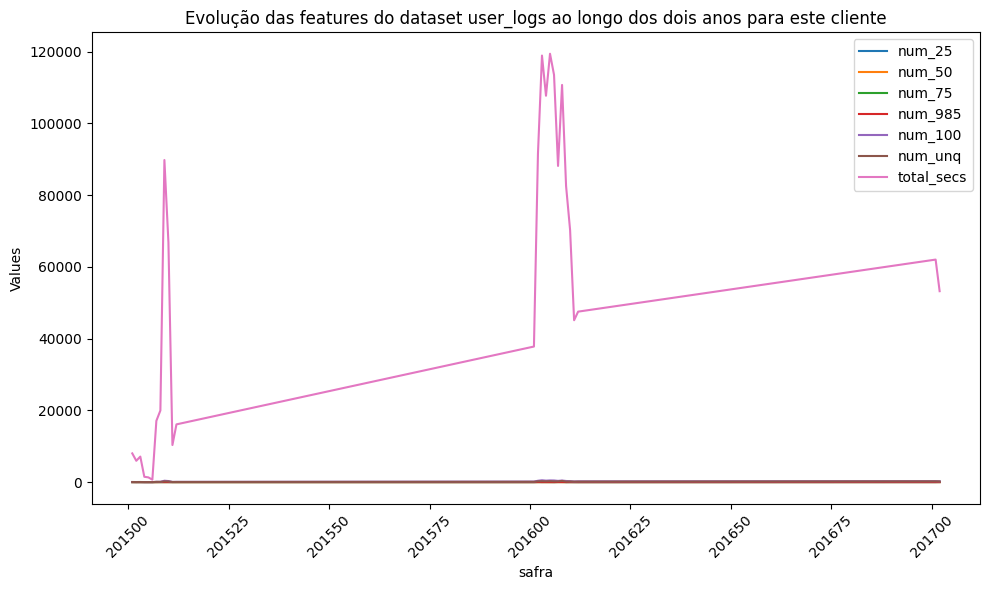

In [ ]:
plt.figure(figsize=(10, 6))

for col in df_logs_pd.columns:
    if col != 'safra' and col != 'msno':
        plt.plot(df_logs_pd['safra'], df_logs_pd[col], label=col)

plt.xlabel('safra')
plt.ylabel('Values')
plt.title(f'Evolução das features do dataset user_logs ao longo dos dois anos para este cliente')
plt.xticks(rotation=45)
plt.legend()
plt.tight_layout()
plt.show()


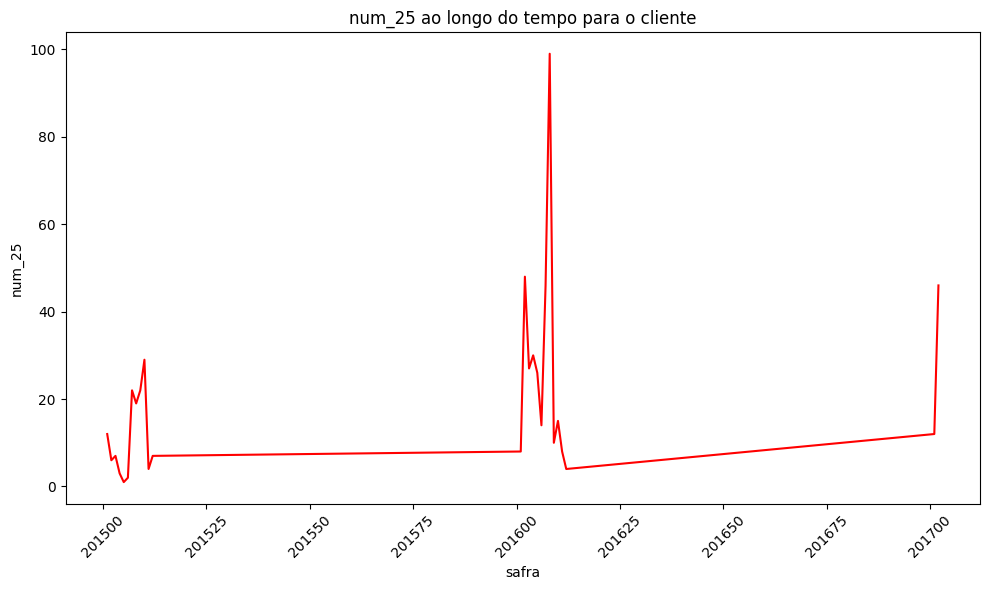

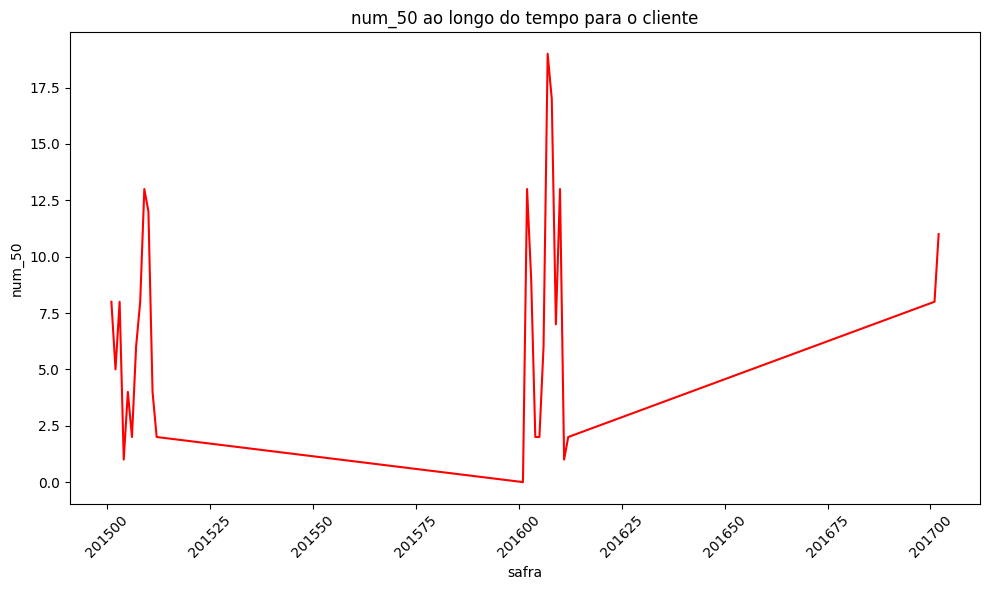

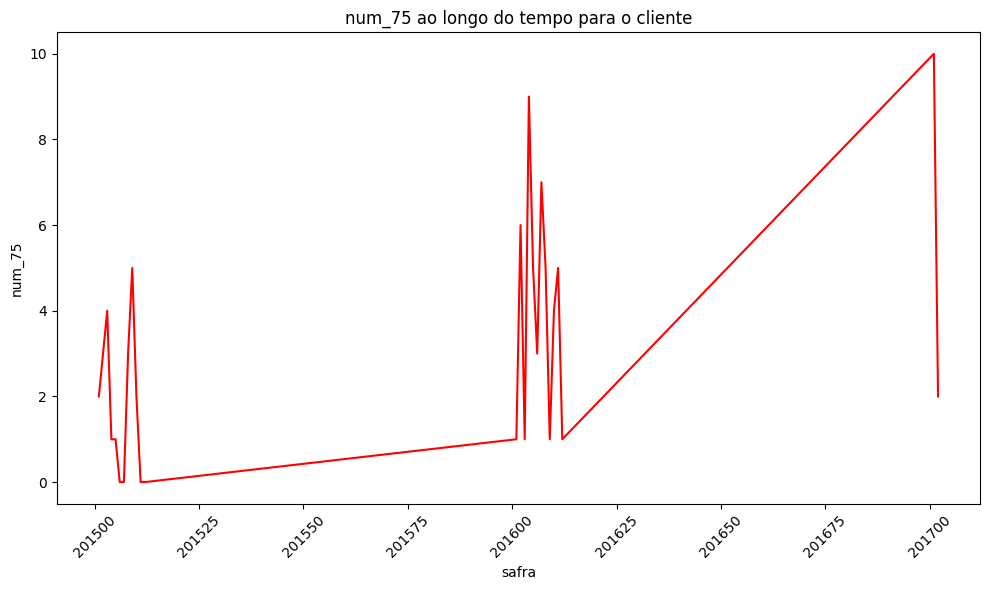

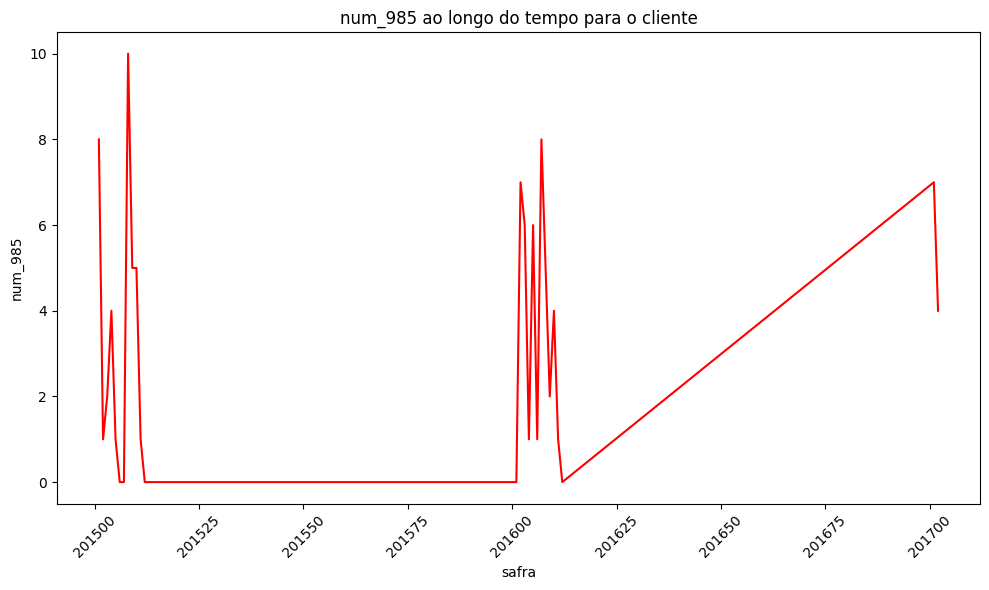

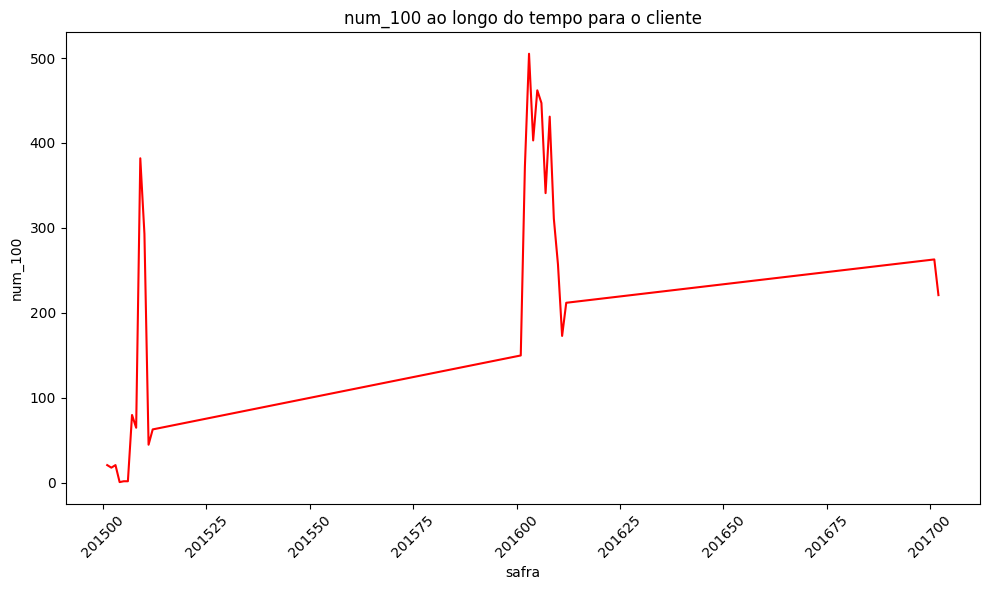

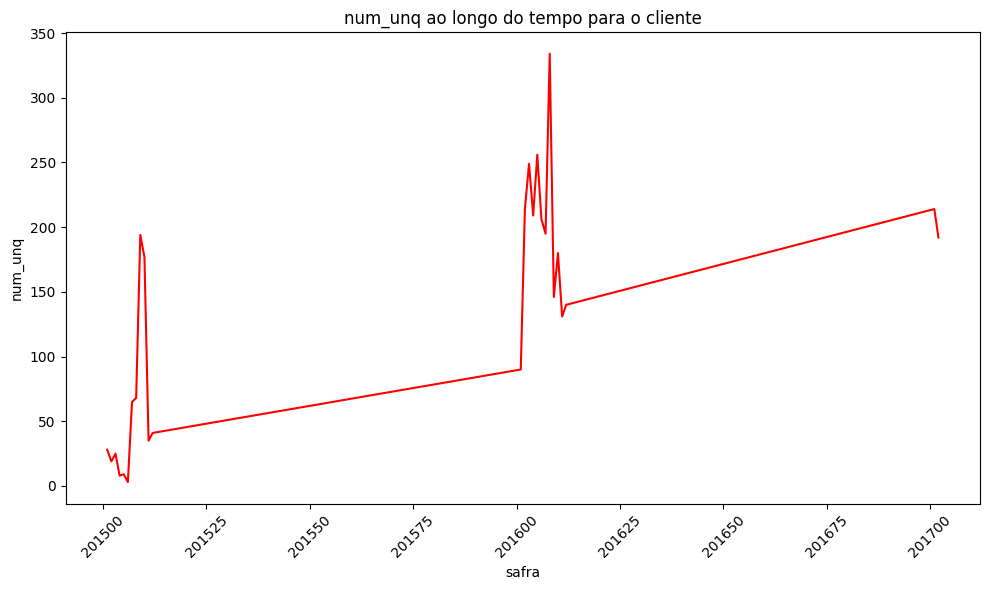

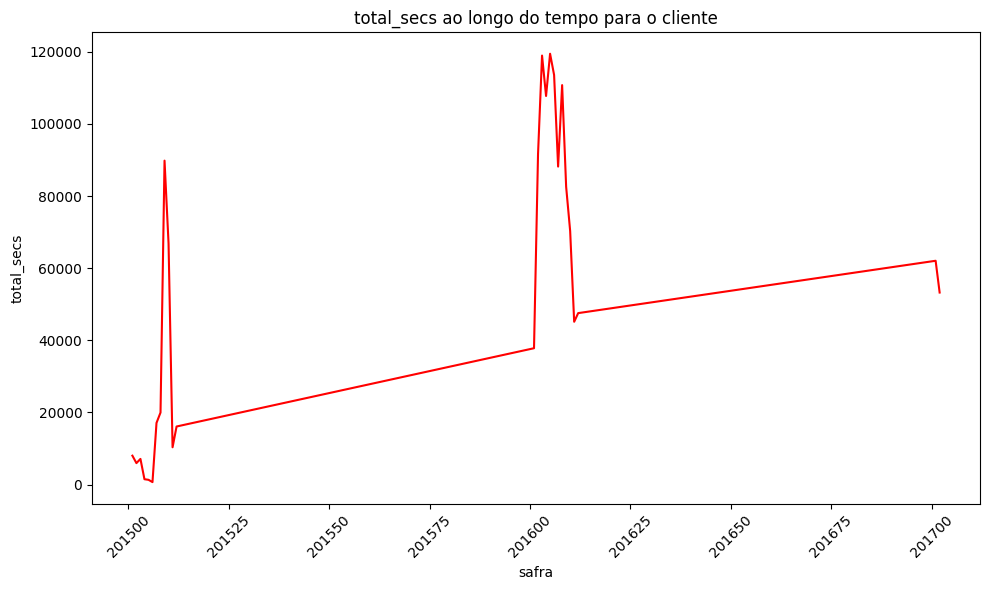

In [10]:
df_logs_pd = df_logs.filter(df_logs.msno == 'rE5wSmHEF1Dhu55zhkiGB1HvotdlSHcIMGXv6VcqO2A=').orderBy('safra').toPandas()

for col in df_logs_pd.columns:
    if col != 'safra' and col != 'msno':
        plt.figure(figsize=(10, 6))
        plt.plot(df_logs_pd['safra'], df_logs_pd[col], color='red')
        plt.xlabel('safra')
        plt.ylabel(col)
        plt.title(f'{col} ao longo do tempo para o cliente')
        plt.xticks(rotation=45)
        plt.tight_layout()
        plt.show()


## Aparentemente, há uma tendência geral de crescimento em todas as features de user_logs ao longo do tempo, com uma instabilidade característica nos primeiros meses de todos os anos representados no dataset. Como não é possível confirmar isso individualmente para todos os clientes, futuras análises de CSI permitirão confirmar se, de fato, há a instabilidade encontrada no início de cada ano se preserva em todos os clientes da base da *Musicfy*

Checagem dos valores:

In [ ]:
df_logs.summary().show()

+-------+--------------------+-----------------+-----------------+-----------------+------------------+------------------+-----------------+------------------+--------------------+
|summary|                msno|            safra|           num_25|           num_50|            num_75|           num_985|          num_100|           num_unq|          total_secs|
+-------+--------------------+-----------------+-----------------+-----------------+------------------+------------------+-----------------+------------------+--------------------+
|  count|            26758971|         26758971|         26758971|         26758971|          26758971|          26758971|         26758971|          26758971|            26758971|
|   mean|                NULL|201572.0403868669|95.42601163549973|24.03566975725636|14.903521327483034|16.538671797207748|450.1598216538297|440.91930526775485|-2.11717488634742...|
| stddev|                NULL|61.87618074610147|175.2882595645691|39.12554591867812|  22.626721

### tratamento de dados: remover linhas com 'total_secs' abaixo de 0 ou acima de 2678400 (qtde de segundos em 1 mês de 31 dias)

In [9]:
df_logs = df_logs.filter((df_logs.total_secs >= 0) & (df_logs.total_secs <= 2678400))

In [ ]:
df_logs.summary().show()

+-------+--------------------+------------------+------------------+-----------------+------------------+-----------------+------------------+------------------+------------------+
|summary|                msno|             safra|            num_25|           num_50|            num_75|          num_985|           num_100|           num_unq|        total_secs|
+-------+--------------------+------------------+------------------+-----------------+------------------+-----------------+------------------+------------------+------------------+
|  count|            26714975|          26714975|          26714975|         26714975|          26714975|         26714975|          26714975|          26714975|          26714975|
|   mean|                NULL|201572.14465388795| 95.23172917062433|23.98807084790459|14.874716109597706|16.50820979619109|448.92748336841044|439.87836020808555|  118790.262952252|
| stddev|                NULL| 61.87175412391622|173.90972700735685|39.00760212443367| 22.56213

A quantidade de clientes distintos em cada safra do período:

In [ ]:
df_logs.groupBy('safra').agg(F.countDistinct('msno').alias('num_users')).orderBy('safra').show(n=2000)

+------+---------+
| safra|num_users|
+------+---------+
|201501|   937607|
|201502|   932820|
|201503|   944348|
|201504|   938567|
|201505|   918749|
|201506|   910435|
|201507|   863364|
|201508|   911647|
|201509|   894760|
|201510|  1009659|
|201511|  1041357|
|201512|  1038896|
|201601|  1076510|
|201602|  1041131|
|201603|  1048821|
|201604|  1042334|
|201605|  1056477|
|201606|  1081171|
|201607|  1102794|
|201608|  1103071|
|201609|  1112597|
|201610|  1139077|
|201611|  1183076|
|201612|  1135566|
|201701|  1135983|
|201702|  1114158|
+------+---------+



### Sanity check:

In [ ]:
window = Window.partitionBy("msno", "safra")

df_logs = df_logs.withColumn('ocorrencias', F.count('*').over(window))
df_logs.filter(F.col('ocorrencias')>1).show()

+----+-----+------+------+------+-------+-------+-------+----------+-----------+
|msno|safra|num_25|num_50|num_75|num_985|num_100|num_unq|total_secs|ocorrencias|
+----+-----+------+------+------+-------+-------+-------+----------+-----------+
+----+-----+------+------+------+-------+-------+-------+----------+-----------+



## Portanto, no df_logs só há uma ocorrência de safra por cliente!

_____

## 1.2 - MEMBERS

In [ ]:
df_members.show(truncate=False)

# registration_init_time: data de início da assinatura do streaming
# registered_via: método usado na assinatura
# bd: idade (cuidado com outliers)
# gender: gênero do usuário
# is_ativo: não especificado... deve ser uma flag pra indicar se o usuário ainda está ativo naquela safra

+--------------------------------------------+------+----------------------+----+---+------+--------------+--------+
|msno                                        |safra |registration_init_time|city|bd |gender|registered_via|is_ativo|
+--------------------------------------------+------+----------------------+----+---+------+--------------+--------+
|+++snpr7pmobhLKUgSHTv/mpkqgBT0tQJ0zQj6qKrqc=|201612|20140927              |1   |0  |NULL  |7             |1       |
|++/AwGzubug3gT6J+0STBGMdWKxaM+UFZTI8Tcmq4To=|201607|20150322              |1   |0  |NULL  |9             |0       |
|++/Gw1B9K+XOlB3hLTloeUK2QlCa2m+BJ8TrzGf7djI=|201601|20121217              |15  |32 |male  |3             |1       |
|++02XbtviomSxcIBUHMOiJkjRxdicTXSfiVqLdsr5lo=|201603|20131112              |14  |21 |male  |7             |0       |
|++0O0Bq04sB/9ZcOS+pajpYL2Hin9jCqnc/8bKzKFuE=|201610|20141021              |5   |33 |male  |3             |0       |
|++2AQgVgYUAqJDw684tbDqDffUeKhqydyQmbr8lz9lQ=|201608|20150416   

contagem dos valores

In [ ]:
df_members.groupBy('gender','is_ativo').agg(F.countDistinct('msno').alias('num_users')).show(n=2000)

+------+--------+---------+
|gender|is_ativo|num_users|
+------+--------+---------+
|  NULL|       1|   791622|
|  male|       0|  1003126|
|female|       1|   368064|
|female|       0|   971126|
|  NULL|       0|  3621351|
|  male|       1|   404313|
+------+--------+---------+



A evolução deste cliente no período considerado:

In [ ]:
df_members.filter(df_members.msno == 'rE5wSmHEF1Dhu55zhkiGB1HvotdlSHcIMGXv6VcqO2A=').orderBy('safra').show()

+--------------------+------+----------------------+----+---+------+--------------+--------+
|                msno| safra|registration_init_time|city| bd|gender|registered_via|is_ativo|
+--------------------+------+----------------------+----+---+------+--------------+--------+
|rE5wSmHEF1Dhu55zh...|201601|              20041013|   5| 39|  male|             9|       1|
|rE5wSmHEF1Dhu55zh...|201602|              20041013|   5| 39|  male|             9|       1|
|rE5wSmHEF1Dhu55zh...|201603|              20041013|   5| 39|  male|             9|       1|
|rE5wSmHEF1Dhu55zh...|201604|              20041013|   5| 39|  male|             9|       1|
|rE5wSmHEF1Dhu55zh...|201605|              20041013|   5| 39|  male|             9|       1|
|rE5wSmHEF1Dhu55zh...|201606|              20041013|   5| 39|  male|             9|       1|
|rE5wSmHEF1Dhu55zh...|201607|              20041013|   5| 39|  male|             9|       1|
|rE5wSmHEF1Dhu55zh...|201608|              20041013|   5| 39|  male|  

A checagem dos valores:

In [ ]:
df_members.summary().show()

+-------+--------------------+------------------+----------------------+-----------------+------------------+--------+------------------+-------------------+
|summary|                msno|             safra|registration_init_time|             city|                bd|  gender|    registered_via|           is_ativo|
+-------+--------------------+------------------+----------------------+-----------------+------------------+--------+------------------+-------------------+
|  count|            63867246|          63867246|              63867246|         63867246|          63867246|25657069|          63867246|           63867246|
|   mean|                NULL|201606.90368996028|  2.0140061722392727E7|4.369941346774214|11.430160210759675|    NULL| 5.455677343594869|0.17603491154135564|
| stddev|                NULL|3.4231736718522296|     23582.39722997598|5.807596122789123|19.041318387984273|    NULL|2.4953863289564757| 0.3808498703308826|
|    min|+++4vcS9aMH7KWdfh...|            201601|   

### tratamento de dados: remover linhas com 'bd' menor que 13 e maior que 90, pois partimos da suposição que usuários com idade acima de 90 anos não são muito adeptos a novas tecnologias de consumo de música (streaming), e o *Musicfy* tem uma política de uso semelhante ao *Spotify* sobre idade mínima para usuários (13 anos)

In [10]:
df_members = df_members.filter((df_members.bd >= 13) & (df_members.bd <= 90))

In [ ]:
df_members.summary().show()

+-------+--------------------+-----------------+----------------------+-----------------+------------------+--------+------------------+-------------------+
|summary|                msno|            safra|registration_init_time|             city|                bd|  gender|    registered_via|           is_ativo|
+-------+--------------------+-----------------+----------------------+-----------------+------------------+--------+------------------+-------------------+
|  count|            24258904|         24258904|              24258904|         24258904|          24258904|23861590|          24258904|           24258904|
|   mean|                NULL|201606.6325833599|   2.012780590542462E7|9.066746420201012| 29.66423549060584|    NULL| 5.490418074946832|0.23825589977189407|
| stddev|                NULL|3.446812591943479|     29676.05892243214|6.549458741142266|10.262061092734122|    NULL|2.8227778008742312| 0.4260164708989047|
|    min|+++4vcS9aMH7KWdfh...|           201601|          

contagem por safra:

In [ ]:
df_members.groupBy('safra').agg(F.countDistinct('msno').alias('num_users')).orderBy('safra').show(n=2000)

+------+---------+
| safra|num_users|
+------+---------+
|201601|  1889667|
|201602|  1918972|
|201603|  1945034|
|201604|  1967566|
|201605|  1989626|
|201606|  2012892|
|201607|  2037076|
|201608|  2059394|
|201609|  2079527|
|201610|  2099945|
|201611|  2119593|
|201612|  2139612|
+------+---------+



Importante! O dataset 'members' traz informações apenas do ano de 2016!

### Nova sanity check:

In [ ]:
window = Window.partitionBy("msno", "safra")

df_members.withColumn('ocorrencias', F.count('*').over(window)).filter(F.col('ocorrencias')>1).show()

+----+-----+----------------------+----+---+------+--------------+--------+-----------+
|msno|safra|registration_init_time|city| bd|gender|registered_via|is_ativo|ocorrencias|
+----+-----+----------------------+----+---+------+--------------+--------+-----------+
+----+-----+----------------------+----+---+------+--------------+--------+-----------+



## Portanto, df_members tem apenas 1 ocorrência de safra por cliente.

______

## 1.3 - TRANSACTIONS

In [ ]:
df_trans.show(truncate=False)

# payment_method_id: método de pagamento
# payment_plan_days: duração em dias da assinatura
# plan_list_price: preço do plano
# actual_amount_paid: preço pago
# is_auto_renew: o plano se renova (1) ou o usuário tem que renovar manualmente (0)
# transaction_date:
# membership_expire_date:
# is_cancel:

+--------------------------------------------+-----------------+-----------------+---------------+------------------+-------------+----------------+----------------------+---------+------+
|msno                                        |payment_method_id|payment_plan_days|plan_list_price|actual_amount_paid|is_auto_renew|transaction_date|membership_expire_date|is_cancel|safra |
+--------------------------------------------+-----------------+-----------------+---------------+------------------+-------------+----------------+----------------------+---------+------+
|+++IZseRRiQS9aaSkH6cMYU6bGDcxUieAi/tH67sC5s=|38               |410              |1788           |1788              |0            |20151121        |20170104              |0        |201511|
|+++snpr7pmobhLKUgSHTv/mpkqgBT0tQJ0zQj6qKrqc=|41               |30               |149            |149               |1            |20150526        |20150626              |0        |201505|
|+++snpr7pmobhLKUgSHTv/mpkqgBT0tQJ0zQj6qKrqc=|41       

Checagem de volumetria por safras:

In [ ]:
df_trans.groupBy('safra').agg(F.countDistinct('msno').alias('num_users')).orderBy('safra').show(n=2000)

+------+---------+
| safra|num_users|
+------+---------+
|201501|   548792|
|201502|   545303|
|201503|   626488|
|201504|   564582|
|201505|   571552|
|201506|   775737|
|201507|   665280|
|201508|   705975|
|201509|   714610|
|201510|   680465|
|201511|   820345|
|201512|   861107|
|201601|   856716|
|201602|   792300|
|201603|   775469|
|201604|   774169|
|201605|   783956|
|201606|   804729|
|201607|   924032|
|201608|   966450|
|201609|   982640|
|201610|  1033898|
|201611|  1094941|
|201612|   968547|
|201701|   988576|
|201702|   885566|
+------+---------+



## A coluna 'is cancel' pode ser um bom ponto de partida para a criação da target, já que abarca os usuários em todas as safras (como demonstrado pela checagem acima)

In [ ]:
df_trans.select('is_cancel').distinct().show()

+---------+
|is_cancel|
+---------+
|        0|
|        1|
+---------+



## O fato de 'is_cancel' ser uma coluna comum a todas as safras e sem valores nulos reforça que essa pode ser uma coluna apropriada para a definição da target

### Última sanity check:

In [ ]:
window = Window.partitionBy("msno", "safra")

df_trans.withColumn('ocorrencias', F.count('*').over(window)).filter(F.col('ocorrencias')>1).show()

+----+-----------------+-----------------+---------------+------------------+-------------+----------------+----------------------+---------+-----+-----------+
|msno|payment_method_id|payment_plan_days|plan_list_price|actual_amount_paid|is_auto_renew|transaction_date|membership_expire_date|is_cancel|safra|ocorrencias|
+----+-----------------+-----------------+---------------+------------------+-------------+----------------+----------------------+---------+-----+-----------+
+----+-----------------+-----------------+---------------+------------------+-------------+----------------+----------------------+---------+-----+-----------+



## Portanto, há, no máximo, um registro de safra por cada cliente

Histórico de transações deste cliente (o mesmo cliente examinado em user_logs):

In [ ]:
df_trans.filter(df_trans.msno == 'rE5wSmHEF1Dhu55zhkiGB1HvotdlSHcIMGXv6VcqO2A=').orderBy('safra').show(df_trans.count())

+--------------------+-----------------+-----------------+---------------+------------------+-------------+----------------+----------------------+---------+------+
|                msno|payment_method_id|payment_plan_days|plan_list_price|actual_amount_paid|is_auto_renew|transaction_date|membership_expire_date|is_cancel| safra|
+--------------------+-----------------+-----------------+---------------+------------------+-------------+----------------+----------------------+---------+------+
|rE5wSmHEF1Dhu55zh...|               34|                0|              0|               149|            1|        20150331|              20150430|        0|201503|
|rE5wSmHEF1Dhu55zh...|               34|                0|              0|               149|            1|        20150630|              20150731|        0|201506|
|rE5wSmHEF1Dhu55zh...|               34|                0|              0|               149|            1|        20150731|              20150831|        0|201507|
|rE5wSmHEF

checando clientes que cancelaram suas assinaturas em fevereiro de 2017

In [ ]:
df_trans.filter((F.col('is_cancel')=='1') & (F.col('safra')==201702)).show(truncate=False)

+--------------------------------------------+-----------------+-----------------+---------------+------------------+-------------+----------------+----------------------+---------+------+
|msno                                        |payment_method_id|payment_plan_days|plan_list_price|actual_amount_paid|is_auto_renew|transaction_date|membership_expire_date|is_cancel|safra |
+--------------------------------------------+-----------------+-----------------+---------------+------------------+-------------+----------------+----------------------+---------+------+
|+0hxQhIL+PBcgrr/8kbirVuzUeztNvPnX61wf8iv6KA=|41               |30               |99             |99                |1            |20170218        |20170315              |1        |201702|
|+2t5lbyOaxmZgTmEuuXASWGUgdUGQ7pEZEwtuM8e2nY=|40               |30               |149            |149               |1            |20170212        |20170210              |1        |201702|
|+A534cfk3ylNGsQ3d8UOkVvs8u2b7+UJqHODG4jfbSg=|40       

e agora examinando a trajetória de alguns desses clientes:

In [ ]:
df_trans.filter(df_trans.msno == '/Jz8svvyAyjXECuB/eGwkLp90a3E0JaqUq6VyFBGJnI=').orderBy('safra').show(df_trans.count())

+--------------------+-----------------+-----------------+---------------+------------------+-------------+----------------+----------------------+---------+------+
|                msno|payment_method_id|payment_plan_days|plan_list_price|actual_amount_paid|is_auto_renew|transaction_date|membership_expire_date|is_cancel| safra|
+--------------------+-----------------+-----------------+---------------+------------------+-------------+----------------+----------------------+---------+------+
|/Jz8svvyAyjXECuB/...|               37|               31|            149|               149|            1|        20150131|              20150228|        0|201501|
|/Jz8svvyAyjXECuB/...|               37|               31|            149|               149|            1|        20150228|              20150331|        0|201502|
|/Jz8svvyAyjXECuB/...|               37|               31|            149|               149|            1|        20150401|              20150430|        0|201504|
|/Jz8svvyA

In [ ]:
df_trans.filter(df_trans.msno == '/cQckk7Uywt/1Z/IeyuTiKsgYGEHjyMryxRjWjteHNs=').orderBy('safra').show(df_trans.count())

+--------------------+-----------------+-----------------+---------------+------------------+-------------+----------------+----------------------+---------+------+
|                msno|payment_method_id|payment_plan_days|plan_list_price|actual_amount_paid|is_auto_renew|transaction_date|membership_expire_date|is_cancel| safra|
+--------------------+-----------------+-----------------+---------------+------------------+-------------+----------------+----------------------+---------+------+
|/cQckk7Uywt/1Z/Ie...|               40|               31|            149|               149|            1|        20150110|              20150209|        0|201501|
|/cQckk7Uywt/1Z/Ie...|               40|               31|            149|               149|            1|        20150210|              20150309|        0|201502|
|/cQckk7Uywt/1Z/Ie...|               40|               31|            149|               149|            1|        20150310|              20150409|        0|201503|
|/cQckk7Uy

In [ ]:
df_trans.filter(df_trans.msno == '+v5C9xWU1sB/zGTKh+dgNv1GWe1Q5oVW2hXq1EnrTRU=').orderBy('safra').show(df_trans.count())

+--------------------+-----------------+-----------------+---------------+------------------+-------------+----------------+----------------------+---------+------+
|                msno|payment_method_id|payment_plan_days|plan_list_price|actual_amount_paid|is_auto_renew|transaction_date|membership_expire_date|is_cancel| safra|
+--------------------+-----------------+-----------------+---------------+------------------+-------------+----------------+----------------------+---------+------+
|+v5C9xWU1sB/zGTKh...|               41|               30|            149|               149|            1|        20150123|              20150224|        0|201501|
|+v5C9xWU1sB/zGTKh...|               41|               30|            149|               149|            1|        20150223|              20150324|        0|201502|
|+v5C9xWU1sB/zGTKh...|               41|               30|            149|               149|            1|        20150323|              20150424|        0|201503|
|+v5C9xWU1

In [ ]:
df_trans.filter(df_trans.msno == '+2t5lbyOaxmZgTmEuuXASWGUgdUGQ7pEZEwtuM8e2nY=').orderBy('safra').show(df_trans.count())

+--------------------+-----------------+-----------------+---------------+------------------+-------------+----------------+----------------------+---------+------+
|                msno|payment_method_id|payment_plan_days|plan_list_price|actual_amount_paid|is_auto_renew|transaction_date|membership_expire_date|is_cancel| safra|
+--------------------+-----------------+-----------------+---------------+------------------+-------------+----------------+----------------------+---------+------+
|+2t5lbyOaxmZgTmEu...|               40|               31|            149|                 0|            1|        20150311|              20150410|        0|201503|
|+2t5lbyOaxmZgTmEu...|               40|               31|            149|               149|            1|        20150411|              20150510|        0|201504|
|+2t5lbyOaxmZgTmEu...|               40|                0|              0|               149|            1|        20150511|              20150610|        0|201505|
|+2t5lbyOa

## Em conclusão... há valores '0' que precisam ser substituídos nas colunas 'plan_list_price', pois se a coluna 'actual_amount_paid' registra um valor maior que 0, o 'plan_list_price' não pode ser 0, afinal não se espera que o cliente pague por um plano que é grátis.

### Para todos os registros em df_trans (transactions), se 'actual_amount_paid' é maior que zero & 'plan_list_price' é zero, então criamos uma nova coluna 'actual_plan_list_price' que contém o valor pago em 'actual_amount_paid'!



### Adicionalmente, retiramos do dataframe todas os clientes que aparecem apenas uma vez e tem 'payment_plan_days' menor ou igual a 60, já que estes clientes estão apenas poluindo a base.

In [11]:
window = Window.partitionBy('msno')

df_trans = df_trans\
.withColumn('actual_plan_list_price', F.when(((F.col('plan_list_price')==0) & (F.col('actual_amount_paid')!=0)), F.col('actual_amount_paid'))\
            .otherwise(F.col('plan_list_price')))

excluidos = df_trans.withColumn('ocorrencias', F.count('*').over(window)).filter(F.col('ocorrencias') == 1).filter(F.col('payment_plan_days')<=60)

df_trans = df_trans.join(excluidos, on=['msno', 'safra'], how='left_anti').drop('plan_list_price')

In [ ]:
df_trans.count()

20133657

____

PREMISSA: É impossível que um cliente esteja marcado com 1 na coluna "is_cancel" sem que ele tenha um plano contratado, como demonstrado pelo cliente abaixo, que possui logs de uso do app desde jan2015, mas só inicia sua assinatura em jun2016:

In [ ]:
df_trans.filter(df_trans.msno == '+/1DM66BsZClU53W5yvl8jN+y6lbTCPK7TOBBWfGUsQ=').orderBy('safra').show(df_trans.count())

+--------------------+-----------------+-----------------+---------------+------------------+-------------+----------------+----------------------+---------+------+
|                msno|payment_method_id|payment_plan_days|plan_list_price|actual_amount_paid|is_auto_renew|transaction_date|membership_expire_date|is_cancel| safra|
+--------------------+-----------------+-----------------+---------------+------------------+-------------+----------------+----------------------+---------+------+
|+/1DM66BsZClU53W5...|               35|                7|              0|                 0|            0|        20150612|              20150615|        0|201506|
|+/1DM66BsZClU53W5...|               32|              180|            536|               536|            0|        20160615|              20161212|        0|201606|
+--------------------+-----------------+-----------------+---------------+------------------+-------------+----------------+----------------------+---------+------+



In [ ]:
df_logs.filter(df_logs.msno == '+/1DM66BsZClU53W5yvl8jN+y6lbTCPK7TOBBWfGUsQ=').orderBy('safra').show(df_trans.count())

+--------------------+------+------+------+------+-------+-------+-------+------------------+-----------+
|                msno| safra|num_25|num_50|num_75|num_985|num_100|num_unq|        total_secs|ocorrencias|
+--------------------+------+------+------+------+-------+-------+-------+------------------+-----------+
|+/1DM66BsZClU53W5...|201501|   4.0|   2.0|   0.0|    1.0|    0.0|    7.0|           541.894|          1|
|+/1DM66BsZClU53W5...|201503|   7.0|   5.0|   5.0|    0.0|    0.0|   14.0|           1459.72|          1|
|+/1DM66BsZClU53W5...|201504|   2.0|   5.0|   1.0|    1.0|    0.0|    9.0|            902.44|          1|
|+/1DM66BsZClU53W5...|201505|   2.0|   4.0|   4.0|    1.0|    0.0|    9.0|           1156.48|          1|
|+/1DM66BsZClU53W5...|201506|   1.0|   2.0|  11.0|    2.0|    0.0|   16.0|           2248.38|          1|
|+/1DM66BsZClU53W5...|201606| 478.0| 107.0|  39.0|   12.0|  204.0|  686.0|         75122.603|          1|
|+/1DM66BsZClU53W5...|201607| 230.0|  94.0|  5

Alguns clientes estão com dados divididos entre as duas tabelas:

In [ ]:
df_trans.filter(df_trans.msno == '+/ICn6aVo12e8goNxBXytRYHvNxy7jITNHhv3SZJ3sE=').orderBy('safra').show(df_trans.count())

+--------------------+-----------------+-----------------+---------------+------------------+-------------+----------------+----------------------+---------+------+
|                msno|payment_method_id|payment_plan_days|plan_list_price|actual_amount_paid|is_auto_renew|transaction_date|membership_expire_date|is_cancel| safra|
+--------------------+-----------------+-----------------+---------------+------------------+-------------+----------------+----------------------+---------+------+
|+/ICn6aVo12e8goNx...|               34|                0|              0|               149|            1|        20150331|              20150430|        0|201503|
|+/ICn6aVo12e8goNx...|               34|                0|              0|               149|            1|        20150630|              20150731|        0|201506|
|+/ICn6aVo12e8goNx...|               34|                0|              0|               149|            1|        20150731|              20150831|        0|201507|
|+/ICn6aVo

Por exemplo, este cliente tem os dados de março e junho-novembro na tabela de transações, mas os dados de janeiro-maio e outubro na tabela de logs

In [ ]:
df_logs.filter(df_logs.msno == '+/ICn6aVo12e8goNxBXytRYHvNxy7jITNHhv3SZJ3sE=').orderBy('safra').show(2000)

+--------------------+------+------+------+------+-------+-------+-------+-----------------+
|                msno| safra|num_25|num_50|num_75|num_985|num_100|num_unq|       total_secs|
+--------------------+------+------+------+------+-------+-------+-------+-----------------+
|+/ICn6aVo12e8goNx...|201501|   7.0|   3.0|   3.0|    3.0|    2.0|   18.0|           2339.7|
|+/ICn6aVo12e8goNx...|201502|   2.0|   4.0|   0.0|    1.0|    1.0|    5.0|           579.77|
|+/ICn6aVo12e8goNx...|201503|  51.0|  21.0|  11.0|   10.0|   75.0|  120.0|        26020.719|
|+/ICn6aVo12e8goNx...|201504|  26.0|  20.0|  11.0|    3.0|   11.0|   63.0|7221.947999999999|
|+/ICn6aVo12e8goNx...|201505|  10.0|   1.0|   1.0|    2.0|   32.0|   41.0|7530.709000000001|
|+/ICn6aVo12e8goNx...|201510|   5.0|   4.0|   0.0|    1.0|   11.0|   18.0|         3580.149|
+--------------------+------+------+------+------+-------+-------+-------+-----------------+



______

Checagem dos valores:

In [ ]:
df_trans.summary().show()

+-------+--------------------+------------------+------------------+------------------+------------------+-------------------+-------------------+----------------------+--------------------+----------------------+
|summary|                msno|             safra| payment_method_id| payment_plan_days|actual_amount_paid|      is_auto_renew|   transaction_date|membership_expire_date|           is_cancel|actual_plan_list_price|
+-------+--------------------+------------------+------------------+------------------+------------------+-------------------+-------------------+----------------------+--------------------+----------------------+
|  count|            20133657|          20133657|          20133657|          20133657|          20133657|           20133657|           20133657|              20133657|            20133657|              20133657|
|   mean|                NULL|201576.46237253372| 39.00910991977265|31.917035986060554| 145.7276722256667| 0.8735867011144572|2.015766353259728E

_____

### Verificando se há clientes que dão churn e depois voltam a ser clientes

In [ ]:
cancel_count_df = df_trans.groupBy("msno").agg(F.sum("is_cancel").alias("cancelamentos"))

In [ ]:
cancel_count_df.filter(F.col('cancelamentos')>1).show(50000, truncate=False)

+--------------------------------------------+-------------+
|msno                                        |cancelamentos|
+--------------------------------------------+-------------+
|+QaT3MJmiHMzJDclom9GDz0Uqz+vyEzcVAVuvfkSoxo=|2.0          |
|/Wm/zH6rbFazIkWYti61eWY1gsJ0snP2YEo+6pOsw7Q=|2.0          |
|/XTEpmZ7wOgpSlFdXkfASPBlP1v9P6cnWEaSB8rF83k=|2.0          |
|0CTzf07QpZxlML8aBGqXlPhDNNIufNwVs77zswDdDp8=|2.0          |
|0Dsivt9MTmnzrs5Kvk+AsBy42ZeFT4jWb01rpA3UmQ4=|2.0          |
|1+TE6mn7v3BLe7R0UbeOINAVoxv/SZ38Z5x5AKFcmTk=|2.0          |
|2QorUojB3nVpFK+OXV1fu1xmsJuLpAkFktRKWo2t7q4=|2.0          |
|2jOEHLVWHJ30rRZ9AKL848tS/echpl/Ar8oOgxcU/s0=|3.0          |
|35vZyKg0o61JgMXctx/vApMxwcdDdzgykbbby9YTE5E=|2.0          |
|3aCKYDiIasTiIOjTtPVLcHRbIzqvRsxa3QZe0t6Yyyg=|2.0          |
|/YshOJTL4rB/FzYFIn3xh2dNKECWw0FgreT/YezcafA=|2.0          |
|3k9+FgXiB646YmT3eFfJF648YYULKS0qN2+nGt0pfqo=|2.0          |
|4vbVXeHjl6n9MAKEndc7MuQIL/gWdc1jjXrYREW9o9I=|2.0          |
|63j4+kwGh0hRTbPZ62+M+Xw

## Portanto, a previsão de churn terá de levar em consideração múltiplas ocorrências de churn em cada cliente. Em outras palavras, para um mesmo cliente, seus diferentes churns podem estar correlacionados com diferentes variáveis!

______

______

____

# 2 - Criação do dataset de partida para a modelagem

### Para a modelagem preditiva, é interessante que aproveitemos as todas as features disponíveis, então faremos um join entre os 3 datasets fornecidos.

### Para isso, montamos um 'scaffold' do dataframe completo, partindo de todas as safras disponíveis e de todos os clientes disponíveis. Então, a partir dessa base, fazemos os left joins com todos os dataframes, trazendo então as features de cada um deles. Ao fim, removemos as colunas que tem apenas informações nulas.

In [ ]:
# criar lista completa de safras e clientes
safras_A = df_logs.select("safra").distinct()
safras_B = df_members.select("safra").distinct()
safras_C = df_trans.select("safra").distinct()
safras_completas = safras_A.union(safras_B).union(safras_C).distinct()

clientes_A = df_logs.select("msno").distinct()
clientes_B = df_members.select("msno").distinct()
clientes_C = df_trans.select("msno").distinct()
clientes_completos = clientes_A.union(clientes_B).union(clientes_C).distinct()

# criar todas as combinações possíveis de cliente x safra
df_aux = clientes_completos.crossJoin(safras_completas)

# fazer os joins com A, B e C
df_resultado = (
    df_aux
    .join(df_logs, on=["msno", "safra"], how="left")
    .join(df_members, on=["msno", "safra"], how="left")
    .join(df_trans, on=["msno", "safra"], how="left")
)

# remover linhas onde todas as colunas de valores são NULL
df_resultado = df_resultado.filter(
    F.col("num_25").isNotNull() | F.col("num_50").isNotNull() | F.col("num_75").isNotNull() | F.col("num_985").isNotNull() | F.col("num_100").isNotNull() | F.col("num_unq").isNotNull() | F.col("total_secs").isNotNull() | F.col("registration_init_time").isNotNull() | F.col("city").isNotNull() | F.col("bd").isNotNull() | F.col("gender").isNotNull() | F.col("registered_via").isNotNull() | F.col("payment_method_id").isNotNull() | F.col("payment_plan_days").isNotNull() | F.col("actual_amount_paid").isNotNull() | F.col("is_auto_renew").isNotNull() | F.col("transaction_date").isNotNull() | F.col("membership_expire_date").isNotNull() | F.col("is_cancel").isNotNull() | F.col("actual_plan_list_price").isNotNull()
)

df_resultado.show()

+--------------------+------+------+------+------+-------+-------+-------+------------------+----------------------+----+----+------+--------------+--------+-----------------+-----------------+------------------+-------------+----------------+----------------------+---------+----------------------+
|                msno| safra|num_25|num_50|num_75|num_985|num_100|num_unq|        total_secs|registration_init_time|city|  bd|gender|registered_via|is_ativo|payment_method_id|payment_plan_days|actual_amount_paid|is_auto_renew|transaction_date|membership_expire_date|is_cancel|actual_plan_list_price|
+--------------------+------+------+------+------+-------+-------+-------+------------------+----------------------+----+----+------+--------------+--------+-----------------+-----------------+------------------+-------------+----------------+----------------------+---------+----------------------+
|+++snpr7pmobhLKUg...|201509| 375.0|  73.0|  46.0|   43.0|  631.0| 1041.0|        180656.804|       

In [ ]:
df_resultado.count()

48444391

In [ ]:
df_resultado.write.mode('overwrite').parquet('/content/drive/MyDrive/Case_Data_Master/df_completo.parquet')

In [8]:
df = spark.read.parquet("/content/drive/MyDrive/Case_Data_Master/df_completo.parquet")

_______

_____

_____

# 3 - Divisão entre treino, validação e teste

### Para nossa modelagem preditiva, é prudente que reservemos parte dos dados disponíveis para validar o modelo durante o seu treinamento e parte para testar o modelo final, simulando uma situação real de modelo em produção

In [13]:
df.groupBy('safra').count().orderBy(F.col('safra').desc()).show(50)

+------+-------+
| safra|  count|
+------+-------+
|201702|1318515|
|201701|1350518|
|201612|2907638|
|201611|2932698|
|201610|2871747|
|201609|2822983|
|201608|2795796|
|201607|2761822|
|201606|2710018|
|201605|2665442|
|201604|2627893|
|201603|2608352|
|201602|2586134|
|201601|2602138|
|201512|1244314|
|201511|1231289|
|201510|1163832|
|201509|1041091|
|201508|1049773|
|201507| 987069|
|201506|1028582|
|201505|1013202|
|201504|1030013|
|201503|1047257|
|201502|1022169|
|201501|1024106|
+------+-------+



In [9]:
cutoff_treino = '201512'
cutoff_val = '201606'

### Faremos a divisão dos dados da seguinte forma:
### treinamento do modelo: dados de jan a dez de 2015
### validação do modelo: jan a jun de 2016
### teste do modelo: jul de 2016 a jan de 2017

In [10]:
df_treino = df.filter(F.col('safra') <= cutoff_treino)
df_val = df.filter((F.col('safra') > cutoff_treino) & (F.col('safra') <= cutoff_val))
df_teste = df.filter(F.col('safra') > cutoff_val)

________

_____

______

# 4 - Criação da target

### Para definir quais clientes serão churn, ou seja, receberão a ação de retenção, iremos marcar como 1 a safra de um cliente se, em até 3 safras no futuro, ele deixou de ser um assinante do *Musicfy*, e 0 se ele continua a ser cliente 3 safras no futuro

### Como o mesmo cliente pode cancelar e voltar a ser cliente no futuro, e assim passar por diversos eventos de churn, é prudente que dividamos sua trajetória na base de dados da *Musicfy* em segmentos, sendo que cada segmento se encerra com um evento de churn. Por exemplo:

### Cliente A estava na base como assinante já em janeiro de 2015 e permaneceu até julho de 2015, deixando de ser assinante em agosto desse ano. Em novembro do mesmo ano, ele voltou a ser assinante, mas tornou a cancelar sua assinatura em maio de 2016. Finalmente, em outubro de 2016 ele voltou para a base de clientes e ali permaneceu até o fim dos registros disponíveis (fev/2017). ----> A trajetória deste cliente teve 3 segmentos, sendo os dois primeiros finalizados por eventos de churn em agosto de 2015 e maio de 2016, e o último finalizado pelo fim do tempo de análise, mas sem churn. ----> Neste caso, o cliente terá a marcação de target como 1 nas safras de maio/junho/julho-2015 e fevereiro/março/abril-2016. A marcação nos meses de cancelamento (agosto-2015 e maio-2016) será NULL, e em todos os outros meses será 0.

### Vamos usar essa lógica dentro de cada dataset individualmente por meio da função *gera_target* definida no início deste notebook:

In [11]:
df_treino = gera_target(df_treino)
df_val = gera_target(df_val)
df_teste = gera_target(df_teste)

Examinando a tarjetória de alguns clientes com churn:

In [21]:
df_treino.filter(F.col('msno')=='++3Z+W8OPnpbHYfrKwqRKN1bF83XEbxjdYUolhGdHZg=').orderBy('safra').show(50)

+--------------------+------+------+------+------+-------+-------+-------+------------------+----+----+------+--------------+--------+-----------------+-----------------+------------------+-------------+----------------+---------+----------------------+----------+------------+
|                msno| safra|num_25|num_50|num_75|num_985|num_100|num_unq|        total_secs|city|  bd|gender|registered_via|is_ativo|payment_method_id|payment_plan_days|actual_amount_paid|is_auto_renew|transaction_date|is_cancel|actual_plan_list_price|segment_id|churn_target|
+--------------------+------+------+------+------+-------+-------+-------+------------------+----+----+------+--------------+--------+-----------------+-----------------+------------------+-------------+----------------+---------+----------------------+----------+------------+
|++3Z+W8OPnpbHYfrK...|201501|  14.0|   9.0|   5.0|    5.0|   90.0|   59.0|         22781.624|NULL|NULL|  NULL|          NULL|    NULL|               41|              

In [22]:
df_treino.filter(F.col('msno')=='JpMK1UASSc1uahQ4VTs7+FVi7iOWkJNA0hch0g3oQ7U=').orderBy('safra').show(50)

+--------------------+------+------+------+------+-------+-------+-------+------------------+----+----+------+--------------+--------+-----------------+-----------------+------------------+-------------+----------------+---------+----------------------+----------+------------+
|                msno| safra|num_25|num_50|num_75|num_985|num_100|num_unq|        total_secs|city|  bd|gender|registered_via|is_ativo|payment_method_id|payment_plan_days|actual_amount_paid|is_auto_renew|transaction_date|is_cancel|actual_plan_list_price|segment_id|churn_target|
+--------------------+------+------+------+------+-------+-------+-------+------------------+----+----+------+--------------+--------+-----------------+-----------------+------------------+-------------+----------------+---------+----------------------+----------+------------+
|JpMK1UASSc1uahQ4V...|201501|  34.0|   8.0|  12.0|   28.0| 1486.0| 1179.0|395994.48099999997|NULL|NULL|  NULL|          NULL|    NULL|               37|              

Verificação da proporção de clientes com cada target por safra:

In [23]:
df_treino.groupBy('safra', 'churn_target').agg(F.count('*').alias('clientes')).orderBy('safra').show(30)

+------+------------+--------+
| safra|churn_target|clientes|
+------+------------+--------+
|201501|           1|   35312|
|201501|           0|  457349|
|201502|           1|   36680|
|201502|           0|  455603|
|201503|           1|   39713|
|201503|           0|  470116|
|201504|           1|   39428|
|201504|           0|  468606|
|201505|           1|   38124|
|201505|           0|  458937|
|201506|           0|  535697|
|201506|           1|   39596|
|201507|           1|   47805|
|201507|           0|  560946|
|201508|           1|   52884|
|201508|           0|  566389|
|201509|           1|   61223|
|201509|           0|  508749|
|201510|           1|   51571|
|201510|           0|  543338|
|201511|           1|   50890|
|201511|           0|  674086|
+------+------------+--------+



In [24]:
df_val.groupBy('safra', 'churn_target').agg(F.count('*').alias('clientes')).orderBy('safra').show(30)

+------+------------+--------+
| safra|churn_target|clientes|
+------+------------+--------+
|201601|           1|   60271|
|201601|           0|  611502|
|201602|           1|   44180|
|201602|           0|  631318|
|201603|           1|   41630|
|201603|           0|  651147|
|201604|           1|   31169|
|201604|           0|  669214|
|201605|           1|   17263|
|201605|           0|  695672|
+------+------------+--------+



In [25]:
df_teste.groupBy('safra', 'churn_target').agg(F.count('*').alias('clientes')).orderBy('safra').show(30)

+------+------------+--------+
| safra|churn_target|clientes|
+------+------------+--------+
|201607|           0|  798528|
|201607|           1|   50481|
|201608|           0|  826139|
|201608|           1|   52765|
|201609|           1|   53019|
|201609|           0|  837240|
|201610|           0|  839766|
|201610|           1|   55127|
|201611|           0|  838829|
|201611|           1|   58574|
|201612|           1|   41992|
|201612|           0|  864231|
|201701|           1|   22341|
|201701|           0|  800248|
+------+------------+--------+



______

# 5 - Preenchimento de NULL/propagação dos valores de features


### Como explicitado anteriormente, há clientes na base que possuem dados em apenas algumas safras, tendo NULL nas demais. Uma estratégia possível para lidar com esses valores na modelagem preditiva é fazendo o preenchimento desses valores NULL com médias móveis. Aqui, preenchemos os NULLs das features numéricas a partir da média daquela variável nos últimos/próximos 3 registros, e os NULLS das features categóricas a partir da última/próxima ocorrência não-nula.

## 5.1 - DATASET DE TREINO

In [12]:
# criamos janela ordenada por safra para cada cliente (FORWARD = passado pro futuro // BACKWARD = futuro pro passado)

window_spec = Window.partitionBy("msno").orderBy(F.col("safra").desc()).rowsBetween(-3, -1)
window_cat = Window.partitionBy("msno").orderBy(F.col("safra").desc()).rowsBetween(Window.unboundedPreceding, -1)

window_spec_fwrd = Window.partitionBy("msno").orderBy(F.col("safra")).rowsBetween(-3, -1)
window_cat_fwrd = Window.partitionBy("msno").orderBy(F.col("safra")).rowsBetween(Window.unboundedPreceding, -1)

# calculamos a média dos últimos 3 valores da feature, ignorando nulos
df_treino_filled = df_treino\
.withColumn("num_100_filled", F.when(F.col("num_100").isNull(), F.avg(F.col("num_100")).over(window_spec)).otherwise(F.col("num_100")))\
.withColumn("num_985_filled", F.when(F.col("num_985").isNull(), F.avg(F.col("num_985")).over(window_spec)).otherwise(F.col("num_985")))\
.withColumn("num_75_filled", F.when(F.col("num_75").isNull(), F.avg(F.col("num_75")).over(window_spec)).otherwise(F.col("num_75")))\
.withColumn("num_50_filled", F.when(F.col("num_50").isNull(), F.avg(F.col("num_50")).over(window_spec)).otherwise(F.col("num_50")))\
.withColumn("num_25_filled", F.when(F.col("num_25").isNull(), F.avg(F.col("num_25")).over(window_spec)).otherwise(F.col("num_25")))\
.withColumn("num_unq_filled", F.when(F.col("num_unq").isNull(), F.avg(F.col("num_unq")).over(window_spec)).otherwise(F.col("num_unq")))\
.withColumn("total_secs_filled", F.when(F.col("total_secs").isNull(), F.avg(F.col("total_secs")).over(window_spec)).otherwise(F.col("total_secs")))\
.withColumn("bd_filled", F.when(F.col("bd").isNull(), F.last(F.col("bd"), ignorenulls=True).over(window_cat)).otherwise(F.col("bd")))\
.withColumn("city_filled", F.when(F.col("city").isNull(), F.last(F.col("city"), ignorenulls=True).over(window_cat)).otherwise(F.col("city")))\
.withColumn("gender_filled", F.when(F.col("gender").isNull(), F.last(F.col("gender"), ignorenulls=True).over(window_cat))\
            .otherwise(F.col("gender")))\
.withColumn("payment_plan_days_filled", F.when(F.col("payment_plan_days").isNull(), F.last(F.col("payment_plan_days"), ignorenulls=True)\
                                               .over(window_cat)).otherwise(F.col("payment_plan_days")))\
.withColumn("actual_plan_list_price_filled",
            F.when(F.col("actual_plan_list_price").isNull(), F.last(F.col("actual_plan_list_price"), ignorenulls=True).over(window_cat))\
            .otherwise(F.col("actual_plan_list_price")))\
.drop('bd').drop('city').drop('gender').drop('num_100').drop('num_985')\
.drop('num_75').drop('num_50').drop('num_25').drop('num_unq').drop('total_secs').drop('payment_plan_days').drop('actual_plan_list_price')\
.withColumn("num_100", F.when(F.col("num_100_filled").isNull(), F.avg(F.col("num_100_filled")).over(window_spec_fwrd))\
            .otherwise(F.col("num_100_filled")))\
.withColumn("num_985", F.when(F.col("num_985_filled").isNull(), F.avg(F.col("num_985_filled")).over(window_spec_fwrd))\
            .otherwise(F.col("num_985_filled")))\
.withColumn("num_75", F.when(F.col("num_75_filled").isNull(), F.avg(F.col("num_75_filled")).over(window_spec_fwrd))\
            .otherwise(F.col("num_75_filled")))\
.withColumn("num_50", F.when(F.col("num_50_filled").isNull(), F.avg(F.col("num_50_filled")).over(window_spec_fwrd))\
            .otherwise(F.col("num_50_filled")))\
.withColumn("num_25", F.when(F.col("num_25_filled").isNull(), F.avg(F.col("num_25_filled")).over(window_spec_fwrd))\
            .otherwise(F.col("num_25_filled")))\
.withColumn("num_unq", F.when(F.col("num_unq_filled").isNull(), F.avg(F.col("num_unq_filled")).over(window_spec_fwrd))\
            .otherwise(F.col("num_unq_filled")))\
.withColumn("total_secs", F.when(F.col("total_secs_filled").isNull(), F.avg(F.col("total_secs_filled")).over(window_spec_fwrd))\
            .otherwise(F.col("total_secs_filled")))\
.withColumn("payment_plan_days",
            F.when(F.col("payment_plan_days_filled").isNull(), F.last(F.col("payment_plan_days_filled"), ignorenulls=True).over(window_cat_fwrd))\
            .otherwise(F.col("payment_plan_days_filled")))\
.withColumn("actual_plan_list_price",
            F.when(F.col("actual_plan_list_price_filled").isNull(), F.last(F.col("actual_plan_list_price_filled"),
                                                                           ignorenulls=True).over(window_cat_fwrd))\
            .otherwise(F.col("actual_plan_list_price_filled")))\
.withColumn("bd", F.when(F.col("bd_filled").isNull(), F.last(F.col("bd_filled"), ignorenulls=True).over(window_cat_fwrd))\
            .otherwise(F.col("bd_filled")))\
.withColumn("city", F.when(F.col("city_filled").isNull(), F.last(F.col("city_filled"), ignorenulls=True).over(window_cat_fwrd))\
            .otherwise(F.col("city_filled")))\
.withColumn("gender", F.when(F.col("gender_filled").isNull(), F.last(F.col("gender_filled"), ignorenulls=True).over(window_cat_fwrd))\
            .otherwise(F.col("gender_filled")))\
.drop('bd_filled').drop('city_filled').drop('gender_filled').drop('num_100_filled')\
.drop('num_985_filled').drop('num_75_filled').drop('num_50_filled').drop('num_25_filled')\
.drop('num_unq_filled').drop('total_secs_filled').drop('payment_plan_days_filled').drop('actual_plan_list_price_filled')


df_treino_filled.show()

+--------------------+------+--------------+--------+-----------------+------------------+-------------+----------------+---------+----------+------------+-------+-------+------+------+------+-------+------------------+-----------------+----------------------+----+----+------+
|                msno| safra|registered_via|is_ativo|payment_method_id|actual_amount_paid|is_auto_renew|transaction_date|is_cancel|segment_id|churn_target|num_100|num_985|num_75|num_50|num_25|num_unq|        total_secs|payment_plan_days|actual_plan_list_price|  bd|city|gender|
+--------------------+------+--------------+--------+-----------------+------------------+-------------+----------------+---------+----------+------------+-------+-------+------+------+------+-------+------------------+-----------------+----------------------+----+----+------+
|++3hfQtTKeHLVuBHI...|201510|          NULL|    NULL|               41|                 0|            1|        20151021|        0|         1|           0|   NULL|   

### O mesmo processo é repetido separadamente para os datasets de treino, validação e teste, de forma a não haver vazamento de dados entre eles

## 5.2 - DATASET DE VALIDAÇÃO

In [13]:
# criamos janela ordenada por safra para cada cliente (FORWARD = passado pro futuro // BACKWARD = futuro pro passado)

window_spec = Window.partitionBy("msno").orderBy(F.col("safra").desc()).rowsBetween(-3, -1)
window_cat = Window.partitionBy("msno").orderBy(F.col("safra").desc()).rowsBetween(Window.unboundedPreceding, -1)

window_spec_fwrd = Window.partitionBy("msno").orderBy(F.col("safra")).rowsBetween(-3, -1)
window_cat_fwrd = Window.partitionBy("msno").orderBy(F.col("safra")).rowsBetween(Window.unboundedPreceding, -1)

# calculamos a média dos últimos 3 valores da feature, ignorando nulos
df_val_filled = df_val\
.withColumn("num_100_filled", F.when(F.col("num_100").isNull(), F.avg(F.col("num_100")).over(window_spec)).otherwise(F.col("num_100")))\
.withColumn("num_985_filled", F.when(F.col("num_985").isNull(), F.avg(F.col("num_985")).over(window_spec)).otherwise(F.col("num_985")))\
.withColumn("num_75_filled", F.when(F.col("num_75").isNull(), F.avg(F.col("num_75")).over(window_spec)).otherwise(F.col("num_75")))\
.withColumn("num_50_filled", F.when(F.col("num_50").isNull(), F.avg(F.col("num_50")).over(window_spec)).otherwise(F.col("num_50")))\
.withColumn("num_25_filled", F.when(F.col("num_25").isNull(), F.avg(F.col("num_25")).over(window_spec)).otherwise(F.col("num_25")))\
.withColumn("num_unq_filled", F.when(F.col("num_unq").isNull(), F.avg(F.col("num_unq")).over(window_spec)).otherwise(F.col("num_unq")))\
.withColumn("total_secs_filled", F.when(F.col("total_secs").isNull(), F.avg(F.col("total_secs")).over(window_spec)).otherwise(F.col("total_secs")))\
.withColumn("bd_filled", F.when(F.col("bd").isNull(), F.last(F.col("bd"), ignorenulls=True).over(window_cat)).otherwise(F.col("bd")))\
.withColumn("city_filled", F.when(F.col("city").isNull(), F.last(F.col("city"), ignorenulls=True).over(window_cat)).otherwise(F.col("city")))\
.withColumn("gender_filled", F.when(F.col("gender").isNull(), F.last(F.col("gender"), ignorenulls=True).over(window_cat))\
            .otherwise(F.col("gender")))\
.withColumn("payment_plan_days_filled", F.when(F.col("payment_plan_days").isNull(), F.last(F.col("payment_plan_days"), ignorenulls=True)\
                                               .over(window_cat)).otherwise(F.col("payment_plan_days")))\
.withColumn("actual_plan_list_price_filled",
            F.when(F.col("actual_plan_list_price").isNull(), F.last(F.col("actual_plan_list_price"), ignorenulls=True).over(window_cat))\
            .otherwise(F.col("actual_plan_list_price")))\
.drop('bd').drop('city').drop('gender').drop('num_100').drop('num_985')\
.drop('num_75').drop('num_50').drop('num_25').drop('num_unq').drop('total_secs').drop('payment_plan_days').drop('actual_plan_list_price')\
.withColumn("num_100", F.when(F.col("num_100_filled").isNull(), F.avg(F.col("num_100_filled")).over(window_spec_fwrd))\
            .otherwise(F.col("num_100_filled")))\
.withColumn("num_985", F.when(F.col("num_985_filled").isNull(), F.avg(F.col("num_985_filled")).over(window_spec_fwrd))\
            .otherwise(F.col("num_985_filled")))\
.withColumn("num_75", F.when(F.col("num_75_filled").isNull(), F.avg(F.col("num_75_filled")).over(window_spec_fwrd))\
            .otherwise(F.col("num_75_filled")))\
.withColumn("num_50", F.when(F.col("num_50_filled").isNull(), F.avg(F.col("num_50_filled")).over(window_spec_fwrd))\
            .otherwise(F.col("num_50_filled")))\
.withColumn("num_25", F.when(F.col("num_25_filled").isNull(), F.avg(F.col("num_25_filled")).over(window_spec_fwrd))\
            .otherwise(F.col("num_25_filled")))\
.withColumn("num_unq", F.when(F.col("num_unq_filled").isNull(), F.avg(F.col("num_unq_filled")).over(window_spec_fwrd))\
            .otherwise(F.col("num_unq_filled")))\
.withColumn("total_secs", F.when(F.col("total_secs_filled").isNull(), F.avg(F.col("total_secs_filled")).over(window_spec_fwrd))\
            .otherwise(F.col("total_secs_filled")))\
.withColumn("payment_plan_days",
            F.when(F.col("payment_plan_days_filled").isNull(), F.last(F.col("payment_plan_days_filled"), ignorenulls=True).over(window_cat_fwrd))\
            .otherwise(F.col("payment_plan_days_filled")))\
.withColumn("actual_plan_list_price",
            F.when(F.col("actual_plan_list_price_filled").isNull(), F.last(F.col("actual_plan_list_price_filled"),
                                                                           ignorenulls=True).over(window_cat_fwrd))\
            .otherwise(F.col("actual_plan_list_price_filled")))\
.withColumn("bd", F.when(F.col("bd_filled").isNull(), F.last(F.col("bd_filled"), ignorenulls=True).over(window_cat_fwrd))\
            .otherwise(F.col("bd_filled")))\
.withColumn("city", F.when(F.col("city_filled").isNull(), F.last(F.col("city_filled"), ignorenulls=True).over(window_cat_fwrd))\
            .otherwise(F.col("city_filled")))\
.withColumn("gender", F.when(F.col("gender_filled").isNull(), F.last(F.col("gender_filled"), ignorenulls=True).over(window_cat_fwrd))\
            .otherwise(F.col("gender_filled")))\
.drop('bd_filled').drop('city_filled').drop('gender_filled').drop('num_100_filled')\
.drop('num_985_filled').drop('num_75_filled').drop('num_50_filled').drop('num_25_filled')\
.drop('num_unq_filled').drop('total_secs_filled').drop('payment_plan_days_filled').drop('actual_plan_list_price_filled')

df_val_filled.show()

+--------------------+------+--------------+--------+-----------------+------------------+-------------+----------------+---------+----------+------------+-------+-------+------+------+------+-------+------------------+-----------------+----------------------+----+----+------+
|                msno| safra|registered_via|is_ativo|payment_method_id|actual_amount_paid|is_auto_renew|transaction_date|is_cancel|segment_id|churn_target|num_100|num_985|num_75|num_50|num_25|num_unq|        total_secs|payment_plan_days|actual_plan_list_price|  bd|city|gender|
+--------------------+------+--------------+--------+-----------------+------------------+-------------+----------------+---------+----------+------------+-------+-------+------+------+------+-------+------------------+-----------------+----------------------+----+----+------+
|++4RuqBw0Ss6bQU4o...|201601|          NULL|    NULL|               41|               149|            1|        20160113|        0|         1|           0|   82.0|   

## 5.3 - DATASET DE TESTE

In [14]:
# criamos janela ordenada por safra para cada cliente (FORWARD = passado pro futuro // BACKWARD = futuro pro passado)

window_spec = Window.partitionBy("msno").orderBy(F.col("safra").desc()).rowsBetween(-3, -1)
window_cat = Window.partitionBy("msno").orderBy(F.col("safra").desc()).rowsBetween(Window.unboundedPreceding, -1)

window_spec_fwrd = Window.partitionBy("msno").orderBy(F.col("safra")).rowsBetween(-3, -1)
window_cat_fwrd = Window.partitionBy("msno").orderBy(F.col("safra")).rowsBetween(Window.unboundedPreceding, -1)

# calculamos a média dos últimos 3 valores da feature, ignorando nulos
df_teste_filled = df_teste\
.withColumn("num_100_filled", F.when(F.col("num_100").isNull(), F.avg(F.col("num_100")).over(window_spec)).otherwise(F.col("num_100")))\
.withColumn("num_985_filled", F.when(F.col("num_985").isNull(), F.avg(F.col("num_985")).over(window_spec)).otherwise(F.col("num_985")))\
.withColumn("num_75_filled", F.when(F.col("num_75").isNull(), F.avg(F.col("num_75")).over(window_spec)).otherwise(F.col("num_75")))\
.withColumn("num_50_filled", F.when(F.col("num_50").isNull(), F.avg(F.col("num_50")).over(window_spec)).otherwise(F.col("num_50")))\
.withColumn("num_25_filled", F.when(F.col("num_25").isNull(), F.avg(F.col("num_25")).over(window_spec)).otherwise(F.col("num_25")))\
.withColumn("num_unq_filled", F.when(F.col("num_unq").isNull(), F.avg(F.col("num_unq")).over(window_spec)).otherwise(F.col("num_unq")))\
.withColumn("total_secs_filled", F.when(F.col("total_secs").isNull(), F.avg(F.col("total_secs")).over(window_spec)).otherwise(F.col("total_secs")))\
.withColumn("bd_filled", F.when(F.col("bd").isNull(), F.last(F.col("bd"), ignorenulls=True).over(window_cat)).otherwise(F.col("bd")))\
.withColumn("city_filled", F.when(F.col("city").isNull(), F.last(F.col("city"), ignorenulls=True).over(window_cat)).otherwise(F.col("city")))\
.withColumn("gender_filled", F.when(F.col("gender").isNull(), F.last(F.col("gender"), ignorenulls=True).over(window_cat))\
            .otherwise(F.col("gender")))\
.withColumn("payment_plan_days_filled", F.when(F.col("payment_plan_days").isNull(), F.last(F.col("payment_plan_days"), ignorenulls=True)\
                                               .over(window_cat)).otherwise(F.col("payment_plan_days")))\
.withColumn("actual_plan_list_price_filled",
            F.when(F.col("actual_plan_list_price").isNull(), F.last(F.col("actual_plan_list_price"), ignorenulls=True).over(window_cat))\
            .otherwise(F.col("actual_plan_list_price")))\
.drop('bd').drop('city').drop('gender').drop('num_100').drop('num_985')\
.drop('num_75').drop('num_50').drop('num_25').drop('num_unq').drop('total_secs').drop('payment_plan_days').drop('actual_plan_list_price')\
.withColumn("num_100", F.when(F.col("num_100_filled").isNull(), F.avg(F.col("num_100_filled")).over(window_spec_fwrd))\
            .otherwise(F.col("num_100_filled")))\
.withColumn("num_985", F.when(F.col("num_985_filled").isNull(), F.avg(F.col("num_985_filled")).over(window_spec_fwrd))\
            .otherwise(F.col("num_985_filled")))\
.withColumn("num_75", F.when(F.col("num_75_filled").isNull(), F.avg(F.col("num_75_filled")).over(window_spec_fwrd))\
            .otherwise(F.col("num_75_filled")))\
.withColumn("num_50", F.when(F.col("num_50_filled").isNull(), F.avg(F.col("num_50_filled")).over(window_spec_fwrd))\
            .otherwise(F.col("num_50_filled")))\
.withColumn("num_25", F.when(F.col("num_25_filled").isNull(), F.avg(F.col("num_25_filled")).over(window_spec_fwrd))\
            .otherwise(F.col("num_25_filled")))\
.withColumn("num_unq", F.when(F.col("num_unq_filled").isNull(), F.avg(F.col("num_unq_filled")).over(window_spec_fwrd))\
            .otherwise(F.col("num_unq_filled")))\
.withColumn("total_secs", F.when(F.col("total_secs_filled").isNull(), F.avg(F.col("total_secs_filled")).over(window_spec_fwrd))\
            .otherwise(F.col("total_secs_filled")))\
.withColumn("payment_plan_days",
            F.when(F.col("payment_plan_days_filled").isNull(), F.last(F.col("payment_plan_days_filled"), ignorenulls=True).over(window_cat_fwrd))\
            .otherwise(F.col("payment_plan_days_filled")))\
.withColumn("actual_plan_list_price",
            F.when(F.col("actual_plan_list_price_filled").isNull(), F.last(F.col("actual_plan_list_price_filled"),
                                                                           ignorenulls=True).over(window_cat_fwrd))\
            .otherwise(F.col("actual_plan_list_price_filled")))\
.withColumn("bd", F.when(F.col("bd_filled").isNull(), F.last(F.col("bd_filled"), ignorenulls=True).over(window_cat_fwrd))\
            .otherwise(F.col("bd_filled")))\
.withColumn("city", F.when(F.col("city_filled").isNull(), F.last(F.col("city_filled"), ignorenulls=True).over(window_cat_fwrd))\
            .otherwise(F.col("city_filled")))\
.withColumn("gender", F.when(F.col("gender_filled").isNull(), F.last(F.col("gender_filled"), ignorenulls=True).over(window_cat_fwrd))\
            .otherwise(F.col("gender_filled")))\
.drop('bd_filled').drop('city_filled').drop('gender_filled').drop('num_100_filled')\
.drop('num_985_filled').drop('num_75_filled').drop('num_50_filled').drop('num_25_filled')\
.drop('num_unq_filled').drop('total_secs_filled').drop('payment_plan_days_filled').drop('actual_plan_list_price_filled')

df_teste_filled.show()

+--------------------+------+--------------+--------+-----------------+------------------+-------------+----------------+---------+----------+------------+-------+-------+------+------+------+-------+------------------+-----------------+----------------------+----+----+------+
|                msno| safra|registered_via|is_ativo|payment_method_id|actual_amount_paid|is_auto_renew|transaction_date|is_cancel|segment_id|churn_target|num_100|num_985|num_75|num_50|num_25|num_unq|        total_secs|payment_plan_days|actual_plan_list_price|  bd|city|gender|
+--------------------+------+--------------+--------+-----------------+------------------+-------------+----------------+---------+----------+------------+-------+-------+------+------+------+-------+------------------+-----------------+----------------------+----+----+------+
|++4RuqBw0Ss6bQU4o...|201607|          NULL|    NULL|               41|               149|            1|        20160713|        0|         1|           0|  346.0|   

In [ ]:
df_treino_filled.write.mode('overwrite').parquet('/content/drive/MyDrive/Case_Data_Master/df_treino.parquet')

In [ ]:
df_val_filled.write.mode('overwrite').parquet('/content/drive/MyDrive/Case_Data_Master/df_val.parquet')

In [ ]:
df_teste_filled.write.mode('overwrite').parquet('/content/drive/MyDrive/Case_Data_Master/df_teste.parquet')

________

______

______

# 6 - Feature Engineering

In [29]:
df_treino_filled.select('bd', 'city', 'gender', 'registered_via', 'is_ativo').distinct().show()

+----+----+------+--------------+--------+
|  bd|city|gender|registered_via|is_ativo|
+----+----+------+--------------+--------+
|NULL|NULL|  NULL|          NULL|    NULL|
+----+----+------+--------------+--------+



Nesta fase da modelagem, percebemos que as colunas 'bd', 'city', 'gender', 'registered_via' e 'is_ativo' não tem registros válidos contemplados no dataset de treino do modelo - obviamente, porque essas informações só estavam disponíveis no dataset 'members', que só tinha dados de 2016. Como os dados de treino abarcam apenas os registros de 2015, essas colunas teriam apenas NULL, mesmo após a etapa de preenchimento acima.

### Assim, a função 'feature_engineer' inicia com o comando
"df.drop('bd', 'city', 'gender', 'registered_via', 'is_ativo', 'is_cancel')"
### Ou seja, iremos retirar essas 4 colunas + 'is_cancel' e 'is_ativo' (já que a target já foi criada com sucesso) de cada dataset


In [15]:
compute_slope_udf = F.udf(compute_slope, DoubleType())

Aqui, registramos uma user-defined function (UDF) para computar o alfa/coeficiente angular de uma reta de regressão linear representativa de uma sequência de pontos cartesianos. Neste caso, o eixo x representa a informação de safra, e o eixo y representa uma feature qualquer. O slope/alfa/coeficiente angular pode ser usado como uma feature propriamente dita na modelagem preditiva para capturar tendências temporais, que é exatamente o que procuramos aqui: entender se a evolução de um determinado parâmetro leva ao churn.

In [16]:
df_treino = feature_engineer(df_treino_filled)

In [17]:
df_val = feature_engineer(df_val_filled)

In [18]:
df_teste = feature_engineer(df_teste_filled)

O conceito de todas as features criadas está descrito no início deste notebook, na célula que agrupa todas as funções usadas neste projeto.

In [34]:
df_treino.show()

+--------------------+------+-----------------+------------------+-------------+----------------+----------+------------+-------+-------+------+------+------+-------+------------------+-----------------+----------------------+-----+-----------------+-----------------+------------------+--------------------+-------------+-------------+------------+------------+------------+-------------+-------------+-------------+------------+------------+------------+-------------+-------------+-------------+------------+------------+------------+-------------+-------------------+-------------------+-------------------+--------------------------+--------------------------+--------------------------+---------------------+---------------------+--------------------+--------------------+--------------------+---------------------+----------------------+----------------------------------+-------------------+-------------------+-------------------+--------------------+-------------------+-------------------+

______________________

_______

_____

# 7 - Treino

A etapa de treinamento de um modelo de machine learning tem a intenção de capturar os padrões das features que levam à target - churn, nesse caso. Esperamos, assim, construir um modelo que consiga generalizar bem os padrões vistos nos dados de treino para realizar previsões assertivas nos dados de teste, que representariam dados obtidos em produção, quando o modelo estiver em plena aplicação.

In [ ]:
df_treino = spark.read.parquet("/content/drive/MyDrive/Case_Data_Master/df_treino.parquet")
df_val = spark.read.parquet("/content/drive/MyDrive/Case_Data_Master/df_val.parquet")
df_teste = spark.read.parquet("/content/drive/MyDrive/Case_Data_Master/df_teste.parquet")

In [19]:
df_treino = preprocess_dataframe(df_treino)
df_val = preprocess_dataframe(df_val)
df_teste = preprocess_dataframe(df_teste)

### Aqui usamos a função preprocess_dataframe para converter os tipos das colunas 'actual_amount_paid', 'payment_plan_days', 'actual_plan_list_price', 'month', 'churn_target' e 'is_auto_renew' em inteiro, além de eliminar a coluna 'transaction_date', que não será necessária para a modelagem.

In [20]:
df_treino.printSchema()

root
 |-- msno: string (nullable = true)
 |-- safra: string (nullable = true)
 |-- payment_method_id: string (nullable = true)
 |-- actual_amount_paid: integer (nullable = true)
 |-- is_auto_renew: integer (nullable = true)
 |-- segment_id: long (nullable = true)
 |-- churn_target: integer (nullable = true)
 |-- num_100: double (nullable = false)
 |-- num_985: double (nullable = false)
 |-- num_75: double (nullable = false)
 |-- num_50: double (nullable = false)
 |-- num_25: double (nullable = false)
 |-- num_unq: double (nullable = false)
 |-- total_secs: double (nullable = false)
 |-- payment_plan_days: integer (nullable = true)
 |-- actual_plan_list_price: integer (nullable = true)
 |-- month: integer (nullable = true)
 |-- plan_value: double (nullable = true)
 |-- plan_rank: double (nullable = true)
 |-- fidelity: double (nullable = true)
 |-- engagement_per_track: double (nullable = true)
 |-- diff1_num_100: double (nullable = false)
 |-- diff1_num_985: double (nullable = false)
 

In [21]:
df_treino.write.mode('overwrite').parquet('/content/drive/MyDrive/Case_Data_Master/df_treino.parquet')

In [22]:
df_val.write.mode('overwrite').parquet('/content/drive/MyDrive/Case_Data_Master/df_val.parquet')

In [23]:
df_teste.write.mode('overwrite').parquet('/content/drive/MyDrive/Case_Data_Master/df_teste.parquet')

In [14]:
df_treino = pd.read_parquet('/content/drive/MyDrive/Case_Data_Master/df_treino.parquet')
df_val = pd.read_parquet('/content/drive/MyDrive/Case_Data_Master/df_val.parquet')
df_teste = pd.read_parquet('/content/drive/MyDrive/Case_Data_Master/df_teste.parquet')

### Verificando a proporção de targets em cada dataset:

In [26]:
df_treino['churn_target'].value_counts(normalize=True)

churn_target
0    0.920358
1    0.079642
Name: proportion, dtype: float64

In [27]:
df_val['churn_target'].value_counts(normalize=True)

churn_target
0    0.943674
1    0.056326
Name: proportion, dtype: float64

In [28]:
df_teste['churn_target'].value_counts(normalize=True)

churn_target
0    0.945548
1    0.054452
Name: proportion, dtype: float64

In [15]:
drop_cols = ['msno', 'segment_id', 'safra', 'churn_target']

### A preparação para a modelagem começa com a divisão, em todos os datasets, entre as features (X) e a target (y). Além disso, especificamos também as features categóricas para uso futuro no modelo de CatBoost.

In [13]:
categorical_cols = ['payment_method_id', 'month']

In [16]:
X_train, y_train = df_treino.drop(drop_cols, axis=1), df_treino['churn_target']
X_val, y_val = df_val.drop(drop_cols, axis=1), df_val['churn_target']
X_test, y_test = df_teste.drop(drop_cols, axis=1), df_teste['churn_target']

In [16]:
X_train['month'] = X_train['month'].astype('str')
X_val['month'] = X_val['month'].astype('str')
X_test['month'] = X_test['month'].astype('str')

## Como demonstrado acima, a classe negativa é muitíssimo mais presente nos datasets do que a classe positiva - então é necessário usar pesos que compensem essa desbalanço de classes para o modelo.

In [17]:
classes = np.unique(y_train)
weights = compute_class_weight('balanced', classes=classes, y=y_train)
class_weights = dict(zip(classes, weights))

In [16]:
class_weights

{np.int32(0): np.float64(0.5432668352802967),
 np.int32(1): np.float64(6.27809766719516)}

In [18]:
model = CatBoostClassifier(
    iterations=20,
    random_state=42,
    silent=False,
    learning_rate=0.1,
    depth=6,
    class_weights=class_weights,
    eval_metric='PRAUC', # -----------------> a área sob a curva precision-recall é a melhor opção para casos de classes desbalanceadas
    early_stopping_rounds=50,
    cat_features=categorical_cols)

### Aqui definimos o catboost_pool, com os dados para treinamento do modelo, e o eval_set, com os dados de validação, que será usado para monitorar a performance do modelo, de forma a evitar overfitting

In [19]:
catboost_pool = Pool(data=X_train, label=y_train, cat_features=categorical_cols)
eval_set = Pool(data=X_val, label=y_val, cat_features=categorical_cols)

In [20]:
model.fit(X_train, y_train, eval_set=eval_set)

0:	learn: 0.8828628	test: 0.8044089	best: 0.8044089 (0)	total: 1.92s	remaining: 36.5s
1:	learn: 0.8756057	test: 0.8227600	best: 0.8227600 (1)	total: 3.6s	remaining: 32.4s
2:	learn: 0.9362903	test: 0.8225485	best: 0.8227600 (1)	total: 5.17s	remaining: 29.3s
3:	learn: 0.9365106	test: 0.8206897	best: 0.8227600 (1)	total: 6.65s	remaining: 26.6s
4:	learn: 0.9376071	test: 0.8157206	best: 0.8227600 (1)	total: 8.25s	remaining: 24.7s
5:	learn: 0.9382749	test: 0.7989085	best: 0.8227600 (1)	total: 9.7s	remaining: 22.6s
6:	learn: 0.9393809	test: 0.8107572	best: 0.8227600 (1)	total: 11s	remaining: 20.4s
7:	learn: 0.9395105	test: 0.8096742	best: 0.8227600 (1)	total: 12.2s	remaining: 18.3s
8:	learn: 0.9396955	test: 0.8088615	best: 0.8227600 (1)	total: 13.5s	remaining: 16.5s
9:	learn: 0.9454149	test: 0.8092318	best: 0.8227600 (1)	total: 15.1s	remaining: 15.1s
10:	learn: 0.9470056	test: 0.8110966	best: 0.8227600 (1)	total: 16.5s	remaining: 13.5s
11:	learn: 0.9474578	test: 0.8088066	best: 0.8227600 (1)	

## 7.1 AVALIANDO A PERFORMANCE DO MODELO

## 7.1.1 NOS DADOS DE TREINO

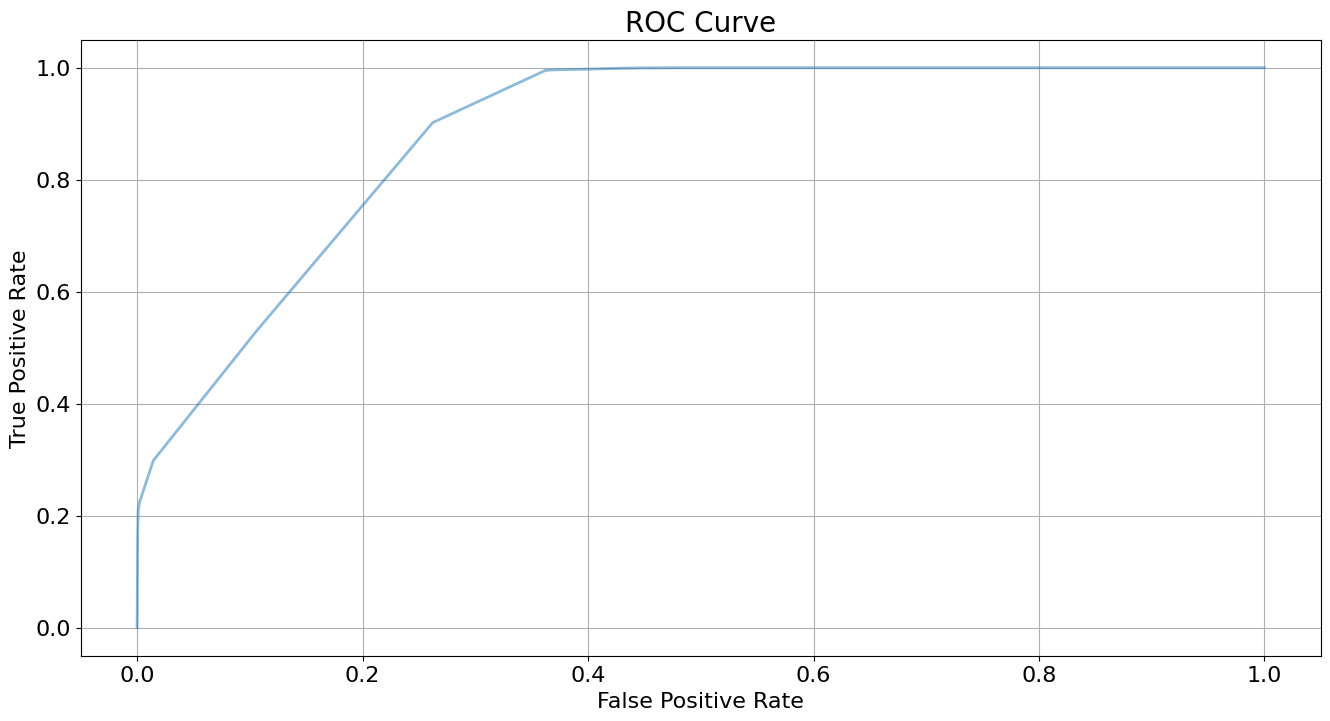

(array([0.00000000e+00, 1.57899834e-06, 1.57899834e-06, 4.70716949e-04,
        4.73699502e-04, 4.78611941e-04, 4.78611941e-04, 8.88274288e-04,
        8.91256841e-04, 9.01257163e-04, 9.44241007e-04, 1.70777443e-03,
        2.16182417e-03, 2.36586585e-03, 2.79359895e-03, 1.43232694e-02,
        1.06257114e-01, 2.13640218e-01, 2.62231623e-01, 2.62231623e-01,
        2.62252150e-01, 2.62252325e-01, 3.61733782e-01, 3.61743783e-01,
        3.62027651e-01, 3.62027827e-01, 3.62027827e-01, 3.62599073e-01,
        3.62600828e-01, 3.62601003e-01, 3.62601880e-01, 3.62626969e-01,
        3.62628723e-01, 3.62632583e-01, 3.62636794e-01, 3.62640478e-01,
        3.63842271e-01, 3.63842447e-01, 3.63842973e-01, 3.63850868e-01,
        3.63851044e-01, 3.63855605e-01, 3.63856131e-01, 3.63874729e-01,
        3.63922800e-01, 3.63977890e-01, 3.63978416e-01, 3.63986487e-01,
        3.64069823e-01, 3.64081402e-01, 3.64156668e-01, 3.71504449e-01,
        3.71508835e-01, 3.71763404e-01, 3.71777089e-01, 3.717790

In [21]:
get_roc_curve(model, catboost_pool, plot=True)

In [22]:
y_train_pred = model.predict_proba(X_train)[:, 1]

<Axes: >

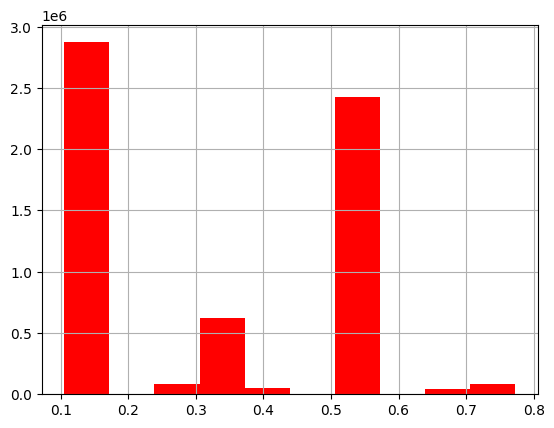

In [23]:
pd.Series(y_train_pred).hist(color='red')

In [41]:
auc_train = roc_auc_score(y_train, y_train_pred)
ks_train = ks_score(y_train, y_train_pred)
auc_train, ks_train

(np.float64(0.8858582985462516), np.float64(63.98345516612506))

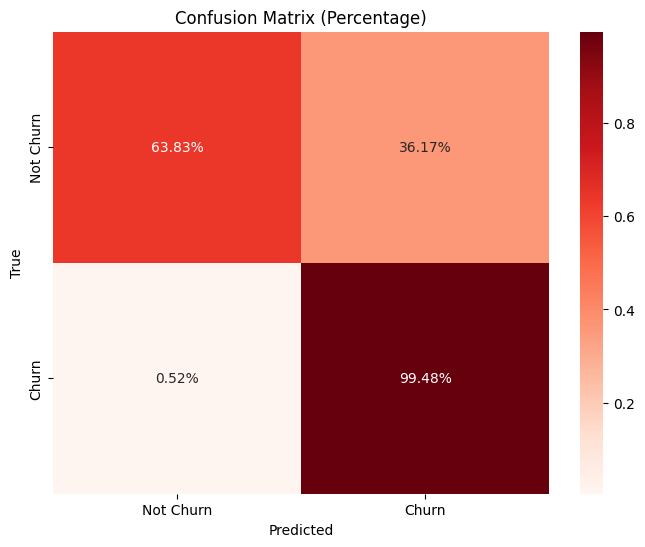

In [24]:
y_train_pred = model.predict(X_train)
cm = confusion_matrix(y_train, y_train_pred)

cm_percentage = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]

plt.figure(figsize=(8, 6))
sns.heatmap(cm_percentage, annot=True, fmt='.2%', cmap='Reds',
            xticklabels=['Not Churn', 'Churn'],
            yticklabels=['Not Churn', 'Churn'])
plt.xlabel('Predicted')
plt.ylabel('True')
plt.title('Confusion Matrix (Percentage)')
plt.show()


In [43]:
print(classification_report(y_train, y_train_pred))

              precision    recall  f1-score   support

           0       1.00      0.64      0.78   5699816
           1       0.19      0.99      0.32    493226

    accuracy                           0.67   6193042
   macro avg       0.60      0.82      0.55   6193042
weighted avg       0.94      0.67      0.74   6193042



## 7.1.2 - NOS DADOS DE VALIDAÇÃO

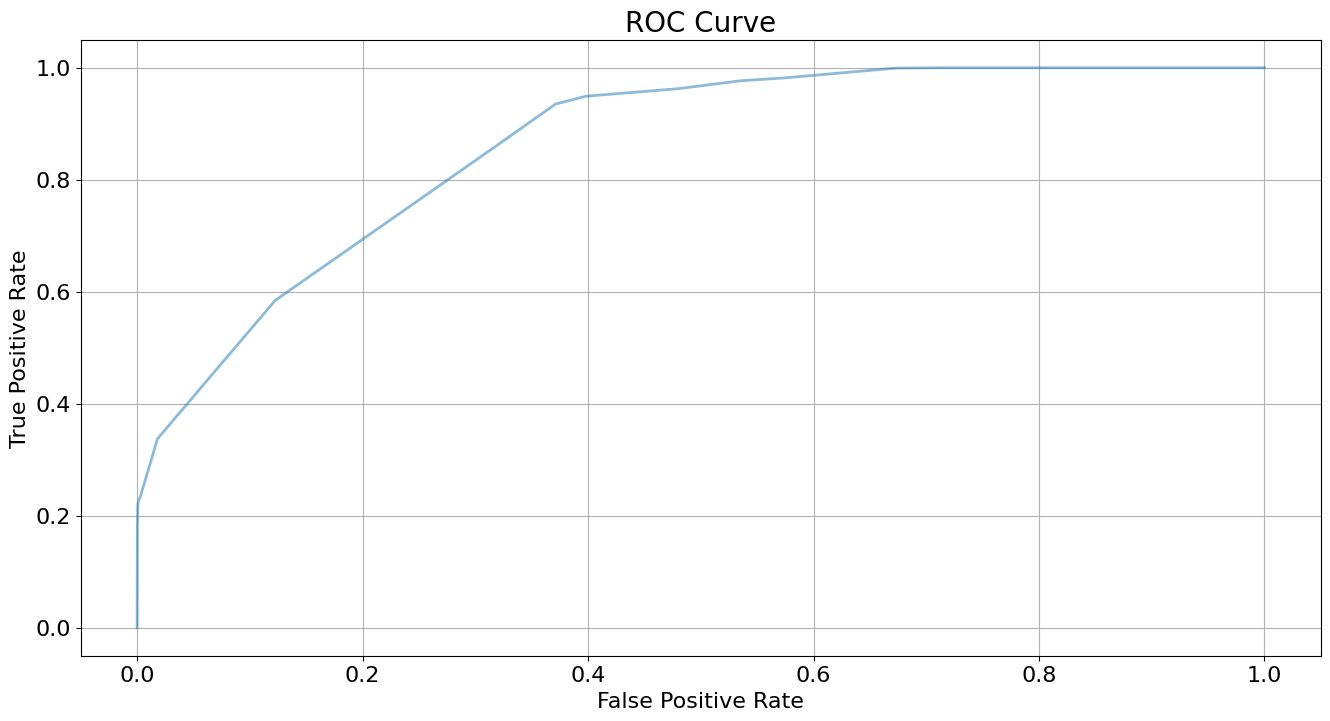

(array([0.00000000e+00, 1.77669873e-04, 1.80124725e-04, 5.95915189e-04,
        5.98983753e-04, 1.10284201e-03, 1.67451554e-03, 1.88962190e-03,
        2.35420254e-03, 1.80805946e-02, 1.22436943e-01, 2.44215769e-01,
        3.20484539e-01, 3.20489755e-01, 3.71304873e-01, 3.71305180e-01,
        3.71341389e-01, 3.71601910e-01, 3.71606206e-01, 3.71607434e-01,
        3.71609275e-01, 3.71611423e-01, 3.71611730e-01, 3.71613264e-01,
        3.72284666e-01, 3.72285586e-01, 3.72292951e-01, 3.72296019e-01,
        3.72297861e-01, 3.72310135e-01, 3.72310442e-01, 3.72322716e-01,
        3.72347265e-01, 3.72353708e-01, 3.72405567e-01, 3.72409863e-01,
        3.72459267e-01, 3.97483716e-01, 3.98034216e-01, 3.98047411e-01,
        3.98053241e-01, 4.80902023e-01, 4.82119936e-01, 5.34686284e-01,
        5.74685326e-01, 6.73497700e-01, 6.73501075e-01, 6.73501382e-01,
        7.12305833e-01, 7.16143686e-01, 7.16540145e-01, 7.17758978e-01,
        7.18225093e-01, 7.18440813e-01, 7.18725269e-01, 7.187255

In [44]:
catboost_pool = Pool(data=X_val, label=y_val, cat_features=categorical_cols)
get_roc_curve(model, catboost_pool, plot=True)

<Axes: >

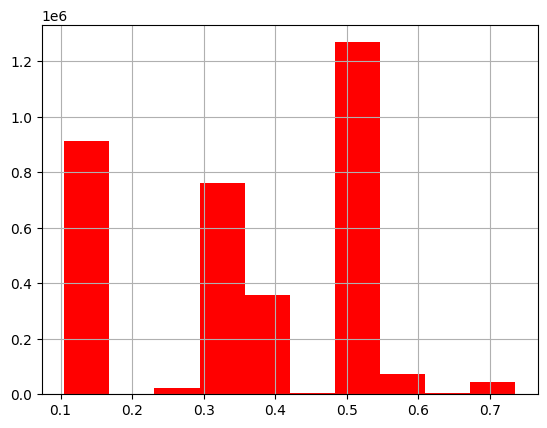

In [25]:
y_val_pred = model.predict_proba(X_val)[:, 1]
pd.Series(y_val_pred).hist(color='red')

In [46]:
auc_val = roc_auc_score(y_val, y_val_pred)
ks_val = ks_score(y_val, y_val_pred)
auc_val, ks_val

(np.float64(0.8622112440900346), np.float64(56.407659218703785))

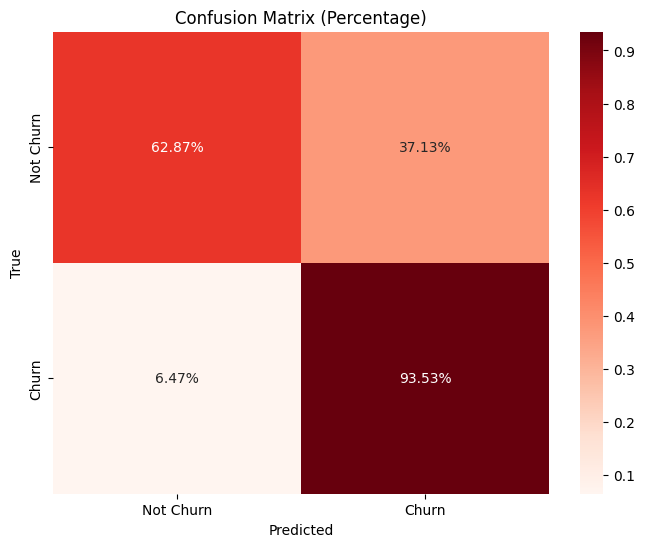

In [26]:
y_val_pred = model.predict(X_val)
cm = confusion_matrix(y_val, y_val_pred)

cm_percentage = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]

plt.figure(figsize=(8, 6))
sns.heatmap(cm_percentage, annot=True, fmt='.2%', cmap='Reds',
            xticklabels=['Not Churn', 'Churn'],
            yticklabels=['Not Churn', 'Churn'])
plt.xlabel('Predicted')
plt.ylabel('True')
plt.title('Confusion Matrix (Percentage)')
plt.show()

In [48]:
print(classification_report(y_val, y_val_pred))

              precision    recall  f1-score   support

           0       0.99      0.63      0.77   3258853
           1       0.13      0.94      0.23    194513

    accuracy                           0.65   3453366
   macro avg       0.56      0.78      0.50   3453366
weighted avg       0.95      0.65      0.74   3453366



## 7.1.3 - NOS DADOS DE TESTE

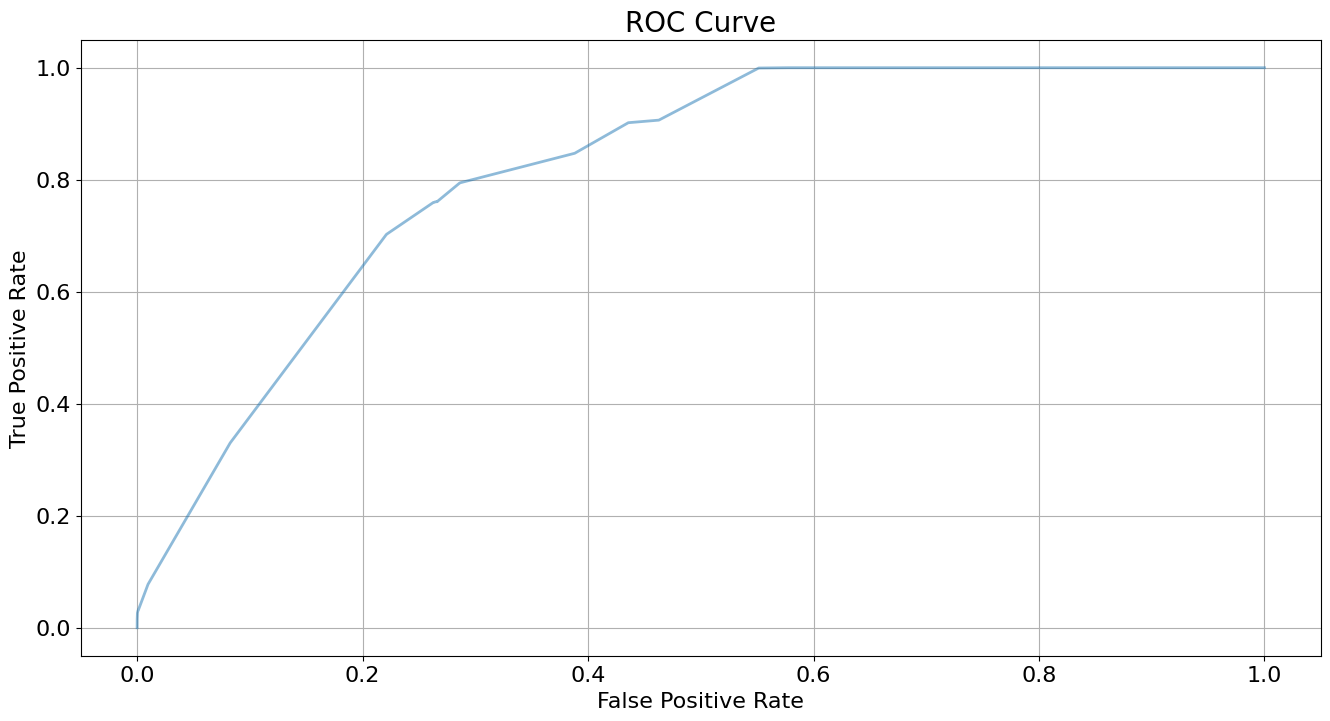

(array([0.00000000e+00, 5.42637435e-05, 5.44360094e-05, 2.61844096e-04,
        2.62016361e-04, 4.79932665e-04, 7.87944009e-04, 9.47462188e-04,
        1.27407824e-03, 1.27425051e-03, 9.65395063e-03, 8.25330867e-02,
        2.21119587e-01, 2.21124066e-01, 2.53413261e-01, 2.62814814e-01,
        2.62821188e-01, 2.63433248e-01, 2.63437727e-01, 2.64438764e-01,
        2.64438936e-01, 2.64439108e-01, 2.64439281e-01, 2.64468910e-01,
        2.64476835e-01, 2.64479246e-01, 2.64533855e-01, 2.64601383e-01,
        2.64604484e-01, 2.65991396e-01, 2.65991568e-01, 2.65991913e-01,
        2.65996392e-01, 2.65997770e-01, 2.65998114e-01, 2.66006211e-01,
        2.66014824e-01, 2.66025160e-01, 2.66031189e-01, 2.66060130e-01,
        2.66080457e-01, 2.66080630e-01, 2.66090449e-01, 2.86010928e-01,
        2.86011272e-01, 2.86400593e-01, 2.86410067e-01, 2.86422126e-01,
        3.88141839e-01, 3.89067423e-01, 4.35735793e-01, 4.62786872e-01,
        5.51400082e-01, 5.51415414e-01, 5.51415931e-01, 5.774115

In [49]:
catboost_pool = Pool(data=X_test, label=y_test, cat_features=categorical_cols)
get_roc_curve(model, catboost_pool, plot=True)

In [27]:
y_test_pred = model.predict_proba(X_test)[:, 1]

<Axes: >

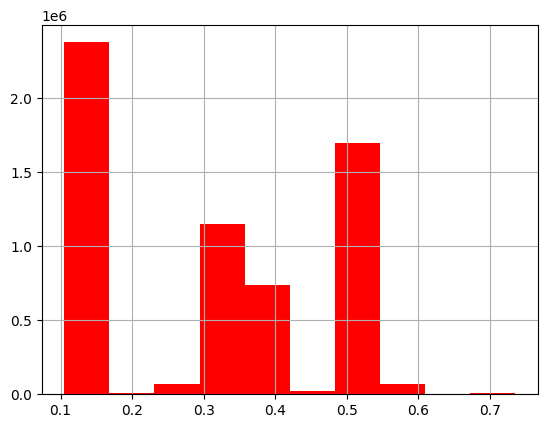

In [28]:
pd.Series(y_test_pred).hist(color='red')

In [52]:
auc_test = roc_auc_score(y_test, y_test_pred)
ks_test = ks_score(y_test, y_test_pred)
auc_test, ks_test

(np.float64(0.8182673779635886), np.float64(50.80602828638228))

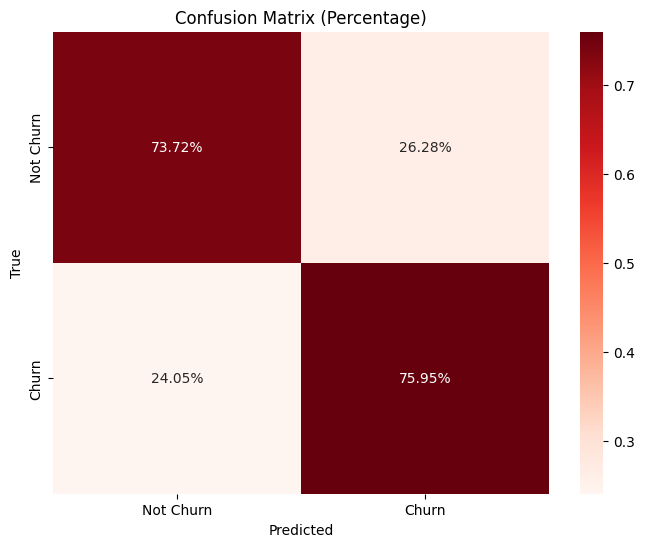

In [29]:
y_test_pred = model.predict(X_test)
cm = confusion_matrix(y_test, y_test_pred)

cm_percentage = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]

plt.figure(figsize=(8, 6))
sns.heatmap(cm_percentage, annot=True, fmt='.2%', cmap='Reds',
            xticklabels=['Not Churn', 'Churn'],
            yticklabels=['Not Churn', 'Churn'])
plt.xlabel('Predicted')
plt.ylabel('True')
plt.title('Confusion Matrix (Percentage)')
plt.show()

In [54]:
print(classification_report(y_test, y_test_pred))

              precision    recall  f1-score   support

           0       0.98      0.74      0.84   5804981
           1       0.14      0.76      0.24    334299

    accuracy                           0.74   6139280
   macro avg       0.56      0.75      0.54   6139280
weighted avg       0.94      0.74      0.81   6139280



## De início, o modelo apresenta uma ótima performance, com taxa de verdadeiros positivos de 76% nos dados de teste. Portanto, podemos prever que este modelo identificaria corretamente mais 3/4 dos clientes que seriam potenciais churn!

_____

## 7.2 - FEATURE SELECTION

### É comum que modelos de machine learning precisem efetivamente de muito menos features do que a quantidade com a qual foram treinados. Nesta etapa iremos verificar quais features são de fato importantes para a tomada de decisão do modelo.

In [30]:
features = ['payment_method_id', 'actual_amount_paid', 'is_auto_renew', 'num_100',
       'num_985', 'num_75', 'num_50', 'num_25', 'num_unq', 'total_secs',
       'payment_plan_days', 'actual_plan_list_price', 'month', 'plan_value',
       'plan_rank', 'fidelity', 'engagement_per_track', 'diff1_num_100',
       'diff1_num_985', 'diff1_num_75', 'diff1_num_50', 'diff1_num_25',
       'diff1_num_unq', 'diff2_num_100', 'diff2_num_985', 'diff2_num_75',
       'diff2_num_50', 'diff2_num_25', 'diff2_num_unq', 'diff3_num_100',
       'diff3_num_985', 'diff3_num_75', 'diff3_num_50', 'diff3_num_25',
       'diff3_num_unq', 'diff1_fidelity', 'diff2_fidelity', 'diff3_fidelity',
       'diff1_engagement_per_track', 'diff2_engagement_per_track',
       'diff3_engagement_per_track', 'evolving_diff_num_100',
       'evolving_diff_num_985', 'evolving_diff_num_75', 'evolving_diff_num_50',
       'evolving_diff_num_25', 'evolving_diff_num_unq',
       'evolving_diff_fidelity', 'evolving_diff_engagement_per_track',
       'slope_total_secs', 'slope_num_unq', 'slope_num_25', 'slope_num_50',
       'slope_num_75', 'slope_num_985', 'slope_num_100', 'slope_fidelity',
       'slope_engagement_per_track']

In [31]:
importances = model.get_feature_importance()
feat_imp = pd.DataFrame({
    'feature': features,
    'importance': importances
}).sort_values(by='importance', ascending=False)

### Por padrão, o CatBoost usa a importância baseada no "PredictionValuesChange" — ele mede quanto a previsão do modelo muda quando uma feature é usada para fazer um split. Normalmente, essa métrica é considerada mais estável e informativa que o simples número de splits nas árvores.

### A seguir, verificamos quais features foram mais importantes na construção do modelo:

In [32]:
feat_imp

feature  importance
40          diff3_engagement_per_track   58.861665
15                            fidelity   17.273908
9                           total_secs   14.721625
2                        is_auto_renew    3.258377
34                       diff3_num_unq    2.215961
1                   actual_amount_paid    1.572282
13                          plan_value    1.042154
11              actual_plan_list_price    0.874889
50                       slope_num_unq    0.179139
5                               num_75    0.000000
8                              num_unq    0.000000
7                               num_25    0.000000
6                               num_50    0.000000
10                   payment_plan_days    0.000000
12                               month    0.000000
14                           plan_rank    0.000000
16                engagement_per_track    0.000000
17                       diff1_num_100    0.000000
18                       diff1_num_985    0.000000
19                        diff1_num_75    0.000000
20                        diff1_num_50    0.000000
21                        diff1_num_25    0.000000
22                       diff1_num_unq    0.000000
0                    payment_method_id    0.000000
4                              num_985    0.000000
3                              num_100    0.000000
25                        diff2_num_75    0.000000
24                       diff2_num_985    0.000000
23                       diff2_num_100    0.000000
26                        diff2_num_50    0.000000
30                       diff3_num_985    0.000000
31                        diff3_num_75    0.000000
28                       diff2_num_unq    0.000000
27                        diff2_num_25    0.000000
33                        diff3_num_25    0.000000
32                        diff3_num_50    0.000000
36                      diff2_fidelity    0.000000
35                      diff1_fidelity    0.000000
37                      diff3_fidelity    0.000000
38          diff1_engagement_per_track    0.000000
39          diff2_engagement_per_track    0.000000
29                       diff3_num_100    0.000000
41               evolving_diff_num_100    0.000000
42               evolving_diff_num_985    0.000000
44                evolving_diff_num_50    0.000000
43                evolving_diff_num_75    0.000000
46               evolving_diff_num_unq    0.000000
47              evolving_diff_fidelity    0.000000
48  evolving_diff_engagement_per_track    0.000000
45                evolving_diff_num_25    0.000000
49                    slope_total_secs    0.000000
51                        slope_num_25    0.000000
52                        slope_num_50    0.000000
53                        slope_num_75    0.000000
54                       slope_num_985    0.000000
55                       slope_num_100    0.000000
56                      slope_fidelity    0.000000
57          slope_engagement_per_track    0.000000

Apenas 9 features com importâncias maiores que zero!!

### A seguir, treinamos diferentes modelos com diferentes números de features, priorizando sempre as que tem maior importância e acrescentando as que tem menos importância, conforme o ranking da célula acima.

In [33]:
importances = model.get_feature_importance()
feat_imp = pd.DataFrame({
    'feature': features,
    'importance': importances
}).sort_values(by='importance', ascending=False)

results = []
for N in [5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 20, 25, 30, 35, 40, 45, 50]:
    sel = feat_imp.head(N)['feature'].tolist()

    # selecionamos apenas colunas categóricas que estão em `sel`
    cat_in_sel = [col for col in categorical_cols if col in sel]

    m = CatBoostClassifier(
        iterations=20,
        random_state=42,
        silent=False,
        learning_rate=0.1,
        depth=6,
        class_weights=class_weights,
        eval_metric='PRAUC',
        early_stopping_rounds=50,
        cat_features=cat_in_sel
    )

    m.fit(X_train[sel], y_train, eval_set=(X_val[sel], y_val))
    results.append({'N': N, 'PRAUC': m.get_best_score()['validation']['PRAUC']})

0:	learn: 0.7359451	test: 0.5290147	best: 0.5290147 (0)	total: 485ms	remaining: 9.22s
1:	learn: 0.7374732	test: 0.5304087	best: 0.5304087 (1)	total: 945ms	remaining: 8.5s
2:	learn: 0.7375801	test: 0.5299625	best: 0.5304087 (1)	total: 1.43s	remaining: 8.08s
3:	learn: 0.7380231	test: 0.5344013	best: 0.5344013 (3)	total: 1.92s	remaining: 7.68s
4:	learn: 0.7379645	test: 0.5321779	best: 0.5344013 (3)	total: 2.42s	remaining: 7.27s
5:	learn: 0.7379231	test: 0.5321590	best: 0.5344013 (3)	total: 2.92s	remaining: 6.83s
6:	learn: 0.7379841	test: 0.5324214	best: 0.5344013 (3)	total: 3.46s	remaining: 6.43s
7:	learn: 0.7379497	test: 0.5327166	best: 0.5344013 (3)	total: 4.03s	remaining: 6.04s
8:	learn: 0.7378578	test: 0.5326286	best: 0.5344013 (3)	total: 4.6s	remaining: 5.62s
9:	learn: 0.7380292	test: 0.5324341	best: 0.5344013 (3)	total: 5.17s	remaining: 5.17s
10:	learn: 0.7380041	test: 0.5313786	best: 0.5344013 (3)	total: 5.74s	remaining: 4.7s
11:	learn: 0.7380140	test: 0.5312951	best: 0.5344013 (3)

### Então plotamos o gráfico de PRAUC x número de features, o que nos leva à conclusão de que, de fato, apenas as primeiras 9 features de maior importância fornecem a melhor PRAUC ao modelo, sendo portanto um desperdício de recursos continuar considerando as demais features nos próximos passos da modelagem... passamos então à etapa de treino otimizado, contando apenas com essas top 9 features.

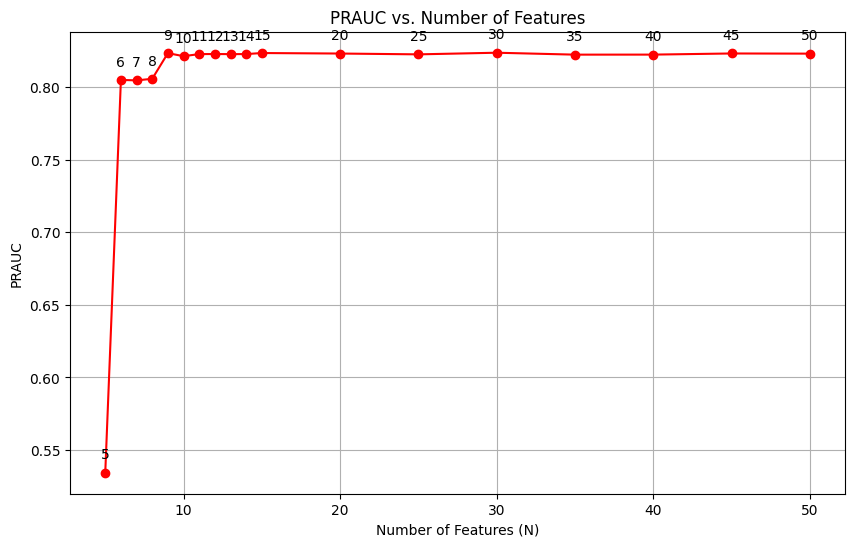

In [34]:
results_df = pd.DataFrame(results)

plt.figure(figsize=(10, 6))
plt.plot(results_df['N'], results_df['PRAUC'], marker='o', color='red')

for i, txt in enumerate(results_df['N']):
    plt.annotate(txt, (results_df['N'][i], results_df['PRAUC'][i]), textcoords="offset points", xytext=(0,10), ha='center')

plt.xlabel('Number of Features (N)')
plt.ylabel('PRAUC')
plt.title('PRAUC vs. Number of Features')
plt.grid(True)
plt.show()

## 7.3 - TREINO OTIMIZADO

### Partimos agora para o treinamento de um modelo diferente usando apenas as top9 features elucidadas acima!

In [61]:
features_finais = feat_imp.head(9)['feature'].tolist()

In [62]:
features_finais

['diff3_engagement_per_track',
 'fidelity',
 'total_secs',
 'is_auto_renew',
 'diff3_num_unq',
 'actual_amount_paid',
 'plan_value',
 'actual_plan_list_price',
 'slope_num_unq']

In [18]:
features_finais  = ['diff3_engagement_per_track',
 'fidelity',
 'total_secs',
 'is_auto_renew',
 'diff3_num_unq',
 'actual_amount_paid',
 'plan_value',
 'actual_plan_list_price',
 'slope_num_unq']

In [19]:
X_train2 = X_train[features_finais]
X_val2 = X_val[features_finais]
X_test2 = X_test[features_finais]

In [20]:
model2 = CatBoostClassifier(
    iterations=20,
    random_state=42,
    silent=False,
    learning_rate=0.1,
    depth=6,
    class_weights=class_weights,
    eval_metric='PRAUC',
    early_stopping_rounds=50)

In [21]:
eval_set = Pool(data=X_val2, label=y_val)

In [22]:
model2.fit(X_train2, y_train, eval_set=eval_set)

0:	learn: 0.8824291	test: 0.8043223	best: 0.8043223 (0)	total: 972ms	remaining: 18.5s
1:	learn: 0.8827481	test: 0.8049327	best: 0.8049327 (1)	total: 1.52s	remaining: 13.7s
2:	learn: 0.8629716	test: 0.7903526	best: 0.8049327 (1)	total: 2.26s	remaining: 12.8s
3:	learn: 0.8754414	test: 0.8229242	best: 0.8229242 (3)	total: 3.17s	remaining: 12.7s
4:	learn: 0.8754977	test: 0.8233509	best: 0.8233509 (4)	total: 4.13s	remaining: 12.4s
5:	learn: 0.8755423	test: 0.8230377	best: 0.8233509 (4)	total: 4.94s	remaining: 11.5s
6:	learn: 0.8959954	test: 0.8212880	best: 0.8233509 (4)	total: 5.74s	remaining: 10.7s
7:	learn: 0.8960371	test: 0.8212876	best: 0.8233509 (4)	total: 6.39s	remaining: 9.58s
8:	learn: 0.8968443	test: 0.8206092	best: 0.8233509 (4)	total: 7.03s	remaining: 8.59s
9:	learn: 0.8969079	test: 0.8196483	best: 0.8233509 (4)	total: 7.72s	remaining: 7.72s
10:	learn: 0.8980104	test: 0.8196444	best: 0.8233509 (4)	total: 8.38s	remaining: 6.86s
11:	learn: 0.8980905	test: 0.8193605	best: 0.8233509 

## 7.3.1 - NOVA AVALIAÇÃO DO MODELO

In [70]:
catboost_pool = Pool(data=X_train2, label=y_train)

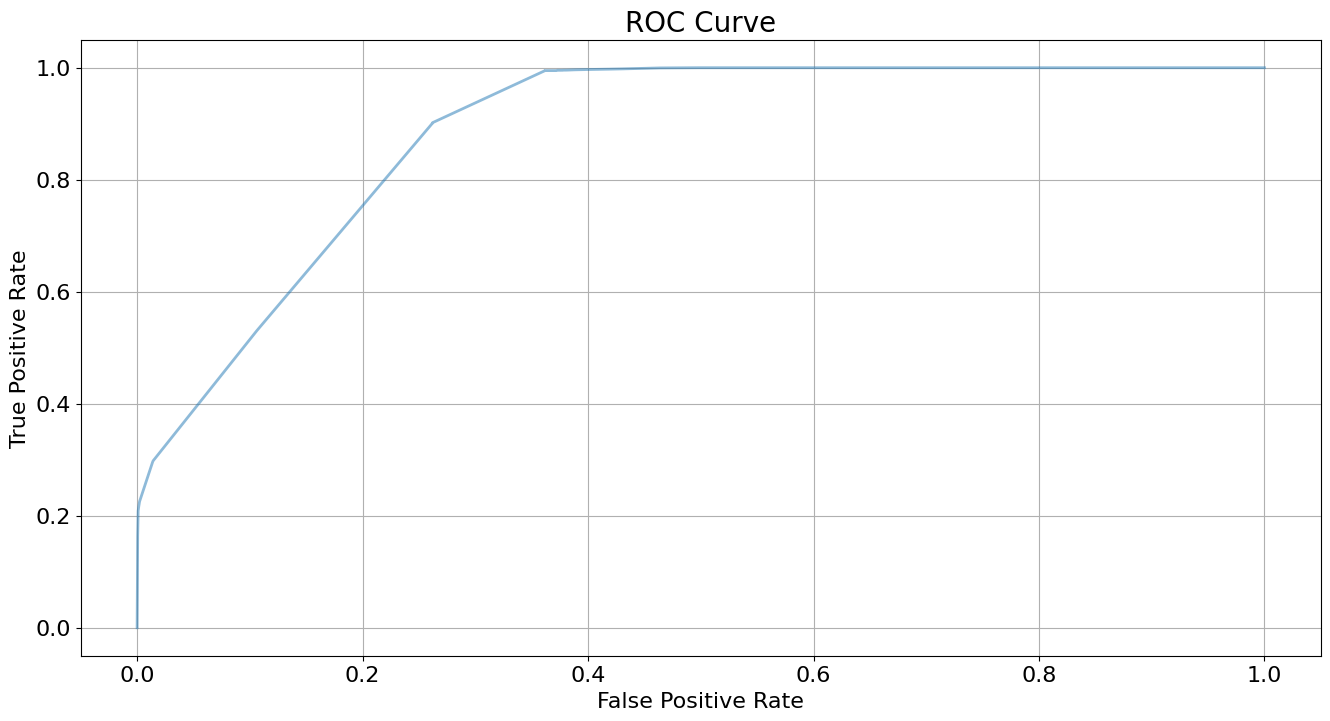

(array([0.00000000e+00, 1.57899834e-06, 6.49143762e-06, 4.75629389e-04,
        4.78611941e-04, 8.88274288e-04, 8.88274288e-04, 8.98274611e-04,
        9.01081719e-04, 9.01081719e-04, 9.44065563e-04, 1.39829075e-03,
        2.16182417e-03, 2.16182417e-03, 2.16182417e-03, 1.36895647e-02,
        1.38892203e-02, 1.43067776e-02, 1.06109039e-01, 2.13747972e-01,
        2.61830733e-01, 2.61831610e-01, 2.61831961e-01, 2.61835821e-01,
        2.61835996e-01, 2.61837926e-01, 2.61858453e-01, 2.61858804e-01,
        2.61994598e-01, 2.61998808e-01, 2.62260747e-01, 2.62260922e-01,
        2.62308994e-01, 3.61779573e-01, 3.61779749e-01, 3.61790626e-01,
        3.61794135e-01, 3.61803960e-01, 3.61804311e-01, 3.61804486e-01,
        3.61808872e-01, 3.61814136e-01, 3.61814838e-01, 3.61822733e-01,
        3.71888496e-01, 3.72172365e-01, 3.72743787e-01, 3.72743962e-01,
        3.72755542e-01, 3.72755717e-01, 3.73801014e-01, 3.73801365e-01,
        3.73825752e-01, 3.73826278e-01, 3.76378816e-01, 3.763805

In [71]:
get_roc_curve(model2, catboost_pool, plot=True)

In [132]:
y_train_pred2 = model2.predict_proba(X_train2)[:, 1]
y_val_pred2 = model2.predict_proba(X_val2)[:, 1]
y_test_pred2 = model2.predict_proba(X_test2)[:, 1]

Comparamos as distribuições de probabilidades que o modelo gera para os 3 datasets (treino, validação e teste, nesta ordem):

<Axes: >

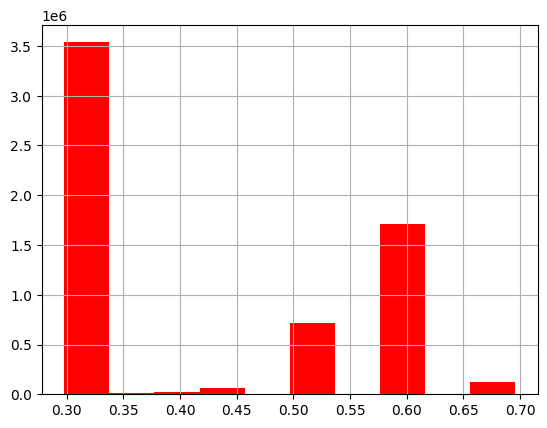

In [133]:
pd.Series(y_train_pred2).hist(color='red')

<Axes: >

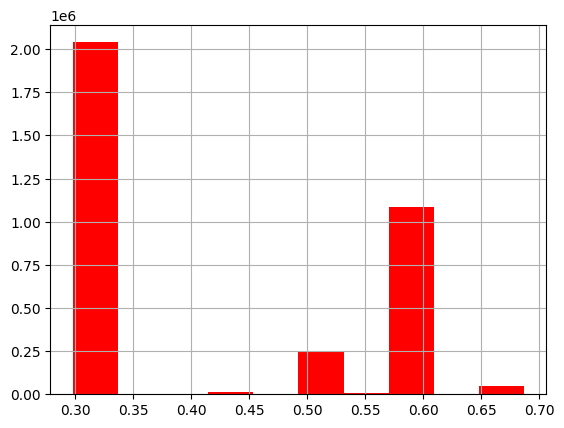

In [134]:
pd.Series(y_val_pred2).hist(color='red')

<Axes: >

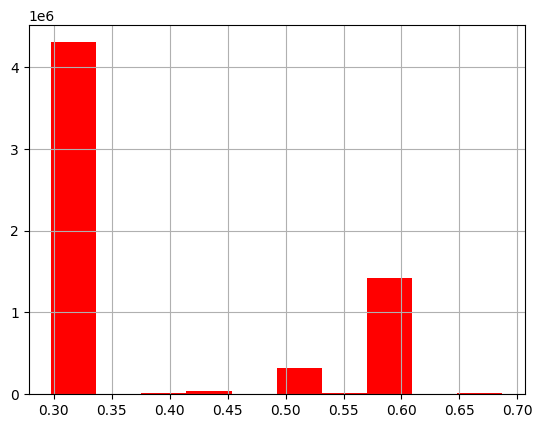

In [135]:
pd.Series(y_test_pred2).hist(color='red')

Calculamos AUC e KS para os três datasets também.
A AUC é uma métrica geral de performance de modelos de classificação, quantificando a capacidade do modelo de classificar corretamente clientes churn e não-churn. Já o KS é uma métrica que indica o quão bem os clientes churn e não-churn são separados pelas probabilidades atribuídas pelo modelo.

In [76]:
auc_train2 = roc_auc_score(y_train, y_train_pred2)
ks_train2 = ks_score(y_train, y_train_pred2)
auc_train2, ks_train2

(np.float64(0.8857231827921417), np.float64(63.98291907521732))

In [77]:
auc_val2 = roc_auc_score(y_val, y_val_pred2)
ks_val2 = ks_score(y_val, y_val_pred2)
auc_val2, ks_val2

(np.float64(0.8627834242879207), np.float64(56.403842329854555))

In [78]:
auc_test2 = roc_auc_score(y_test, y_test_pred2)
ks_test2 = ks_score(y_test, y_test_pred2)
auc_test2, ks_test2

(np.float64(0.8273290794719608), np.float64(51.19886107843929))

## 7.3.1.1 - AVALIAÇÃO NOS DADOS DE TESTE

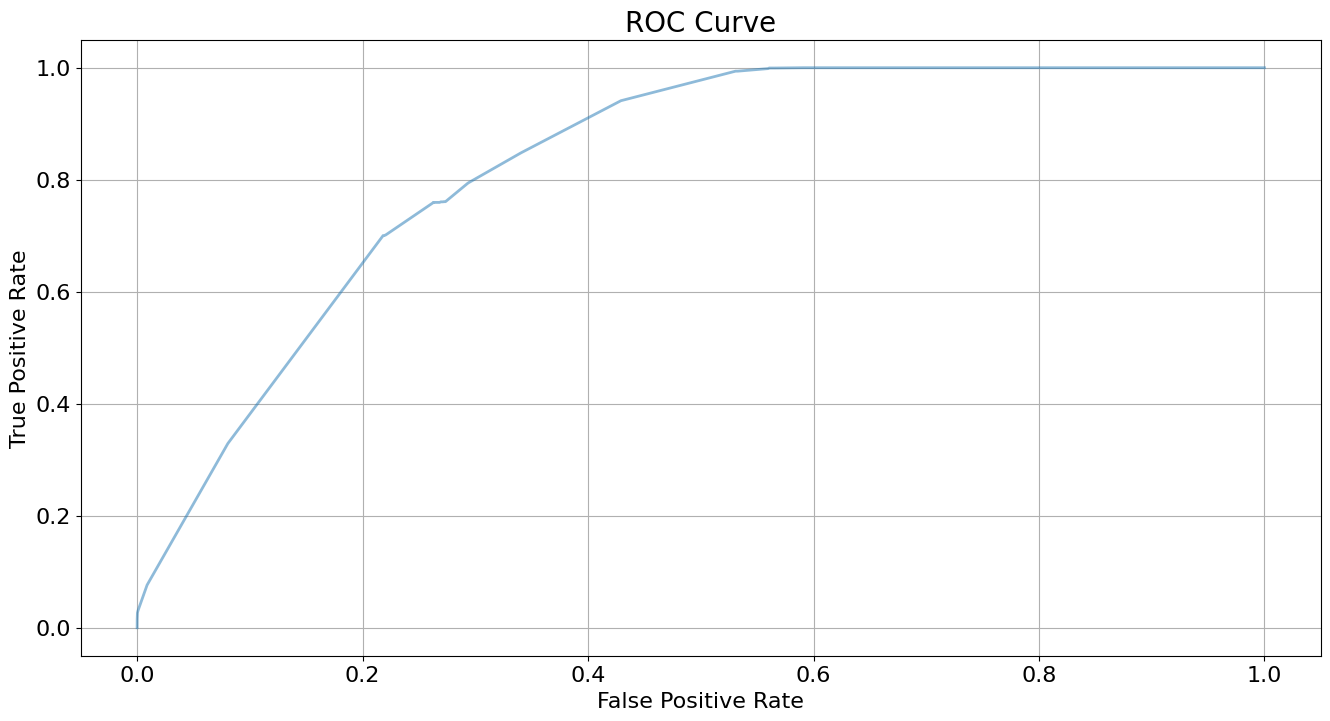

(array([0.00000000e+00, 5.42637435e-05, 5.44360094e-05, 2.61844096e-04,
        2.62016361e-04, 5.70027706e-04, 7.87944009e-04, 8.68667787e-03,
        8.82104524e-03, 9.14249332e-03, 8.04808836e-02, 2.18089430e-01,
        2.18089603e-01, 2.18111653e-01, 2.18597098e-01, 2.18601577e-01,
        2.18602783e-01, 2.20201410e-01, 2.20203822e-01, 2.21253093e-01,
        2.21261706e-01, 2.53484466e-01, 2.62896123e-01, 2.62956933e-01,
        2.62960034e-01, 2.62966408e-01, 2.62967786e-01, 2.62968130e-01,
        2.62968475e-01, 2.62968647e-01, 2.62968819e-01, 2.67790713e-01,
        2.68402773e-01, 2.69403810e-01, 2.69424138e-01, 2.69424310e-01,
        2.69424482e-01, 2.69854458e-01, 2.69880642e-01, 2.70786588e-01,
        2.70815701e-01, 2.70816218e-01, 2.70816390e-01, 2.70816735e-01,
        2.71099940e-01, 2.71118372e-01, 2.71119406e-01, 2.72506835e-01,
        2.72514932e-01, 2.72518205e-01, 2.72519066e-01, 2.72521305e-01,
        2.72522684e-01, 2.72524234e-01, 2.72530091e-01, 2.725311

In [79]:
catboost_pool = Pool(data=X_test2, label=y_test)
get_roc_curve(model2, catboost_pool, plot=True)

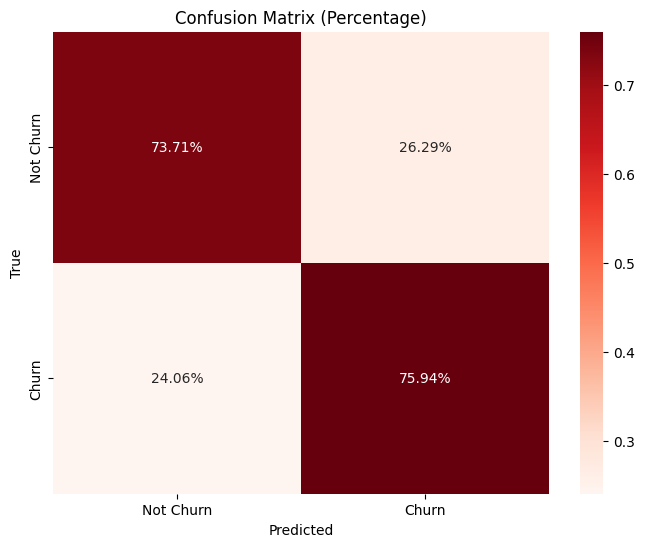

In [26]:
y_test_pred2 = model2.predict(X_test2)
cm = confusion_matrix(y_test, y_test_pred2)

cm_percentage = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]

plt.figure(figsize=(8, 6))
sns.heatmap(cm_percentage, annot=True, fmt='.2%', cmap='Reds',
            xticklabels=['Not Churn', 'Churn'],
            yticklabels=['Not Churn', 'Churn'])
plt.xlabel('Predicted')
plt.ylabel('True')
plt.title('Confusion Matrix (Percentage)')
plt.show()

## O resultado final mostra um modelo excelente, capaz de identificar corretamente mais 75% dos casos de churn em até 3 meses em dados inéditos! Agora iremos partir para a etapa de otimização de hiperparâmetros, onde iremos buscar por configurações finas do CatBoost que tenham o potencial de melhorar ainda mais o seu desempenho.

In [ ]:
df_treino = pd.read_parquet('/content/drive/MyDrive/Case_Data_Master/df_treino.parquet')[features_finais]
df_val = pd.read_parquet('/content/drive/MyDrive/Case_Data_Master/df_val.parquet')[features_finais]
df_teste = pd.read_parquet('/content/drive/MyDrive/Case_Data_Master/df_teste.parquet')[features_finais]

In [ ]:
df_treino.to_parquet('/content/drive/MyDrive/Case_Data_Master/df_treino2.parquet')
df_val.to_parquet('/content/drive/MyDrive/Case_Data_Master/df_val2.parquet')
df_teste.to_parquet('/content/drive/MyDrive/Case_Data_Master/df_teste2.parquet')

_______

_____

_____

# 8 - Otimização de hiperparâmetros

In [19]:
cat = CatBoostClassifier(
    random_state=42,
    silent=False,
    class_weights=class_weights,
    early_stopping_rounds=50,
    task_type='GPU',
    devices='0')

search_spaces = {
    'n_estimators': Integer(10, 2000),              #-------------> número de árvores do modelo
    'learning_rate': Real(0.01, 1.0, prior='log-uniform'), #------> taxa de aprendizado (o quanto o modelo ajusta suas previsões a cada árvore)
    'max_depth': Integer(1, 10),     #----------------------------> profundidade máxima de cada árvore
    'l2_leaf_reg': Real(2, 2000, prior='log-uniform'),  #---------> regularização Ridge das folhas das árvores
    'bagging_temperature': Real(0.0, 1.0),     #------------------> controla aleatoriedade na amostragem de dados para cada árvore
    'random_strength': Real(1e-9, 1.0)}   #-----------------------> aleatoriedade ao escolher os splits

cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=42) #------> validação cruzada 5-fold mantendo a proporção das classes 0 e 1

opt = BayesSearchCV(  #-------------> otimização bayesiana, que escolhe os próximos pontos a testar com base em resultados anteriores
    estimator=cat,    #-------------> o modelo instanciado acima
    search_spaces=search_spaces, #--> o conjunto de hiperparâmetros e suas faixas de valores descritos acima
    scoring=prauc_score_func, #-----> função para cálculo da área sob a curva Precision-Recall, descrita no início deste notebook
    cv=cv,   #----------------------> avaliação de cada conjunto de hiperparâmetros com base em uma divisão 5-fold
    n_iter=50, #--------------------> 50 combinações diferentes de hiperparâmetros
    refit=True, #-------------------> refazer o treinamento final completo com os melhores hiperparâmetros usando todos os dados
    verbose=1,  #-------------------> mostrar um resumo de cada iteração
    random_state=42)

opt.fit(X_train2, y_train)

print("Melhor PRAUC (validação):", opt.best_score_)
print("Melhores hiperparâmetros:")
print(opt.best_params_)

model_final = opt.best_estimator_
y_pred_proba = model_final.predict_proba(X_test2)[:, 1]
prauc_test = average_precision_score(y_test, y_pred_proba)

print("PRAUC no conjunto de teste:", prauc_test)

del cat, opt
gc.collect()

Streaming output truncated to the last 5000 lines.
1004:	learn: 0.3287731	total: 31.7s	remaining: 31.4s
1005:	learn: 0.3287717	total: 31.7s	remaining: 31.3s
1006:	learn: 0.3287700	total: 31.7s	remaining: 31.3s
1007:	learn: 0.3287680	total: 31.8s	remaining: 31.3s
1008:	learn: 0.3287673	total: 31.8s	remaining: 31.2s
1009:	learn: 0.3287659	total: 31.8s	remaining: 31.2s
1010:	learn: 0.3287624	total: 31.9s	remaining: 31.2s
1011:	learn: 0.3287616	total: 31.9s	remaining: 31.1s
1012:	learn: 0.3287607	total: 31.9s	remaining: 31.1s
1013:	learn: 0.3287589	total: 31.9s	remaining: 31.1s
1014:	learn: 0.3287575	total: 32s	remaining: 31s
1015:	learn: 0.3287571	total: 32s	remaining: 31s
1016:	learn: 0.3287541	total: 32s	remaining: 31s
1017:	learn: 0.3287535	total: 32.1s	remaining: 30.9s
1018:	learn: 0.3287521	total: 32.1s	remaining: 30.9s
1019:	learn: 0.3287497	total: 32.1s	remaining: 30.9s
1020:	learn: 0.3287478	total: 32.2s	remaining: 30.8s
1021:	learn: 0.3287464	total: 32.2s	remaining: 30.8s
1022:	l

23

## Os hiperparâmetros encontrados acima foram usados em um novo treinamento (model3 - veja abaixo), mas resultaram em performance subótima em comparação com o modelo anterior (model2) no dataset de teste, como mostrado pelos valores de PRAUC acima e a leve queda nas métricas abaixo (AUC, KS e taxa de verdadeiros positivos).

In [23]:
model3 = CatBoostClassifier(
    random_state=42,
    silent=False,
    bagging_temperature=5.551115123125783e-17,
    l2_leaf_reg=2.0,
    learning_rate=0.01,
    max_depth=10,
    n_estimators=2000,
    random_strength=1e-09,
    class_weights=class_weights,
    eval_metric='PRAUC',
    early_stopping_rounds=50)

In [24]:
eval_set = Pool(data=X_val2, label=y_val)
model3.fit(X_train2, y_train, eval_set=eval_set)

0:	learn: 0.9026433	test: 0.7842155	best: 0.7842155 (0)	total: 1.05s	remaining: 34m 52s
1:	learn: 0.9026907	test: 0.7841506	best: 0.7842155 (0)	total: 1.88s	remaining: 31m 17s
2:	learn: 0.9026415	test: 0.7841478	best: 0.7842155 (0)	total: 2.67s	remaining: 29m 37s
3:	learn: 0.9026414	test: 0.7841475	best: 0.7842155 (0)	total: 3.6s	remaining: 29m 54s
4:	learn: 0.9026444	test: 0.7841456	best: 0.7842155 (0)	total: 4.41s	remaining: 29m 18s
5:	learn: 0.9026903	test: 0.7841437	best: 0.7842155 (0)	total: 5.22s	remaining: 28m 55s
6:	learn: 0.9026903	test: 0.7841383	best: 0.7842155 (0)	total: 6.13s	remaining: 29m 3s
7:	learn: 0.9026903	test: 0.7841383	best: 0.7842155 (0)	total: 7.01s	remaining: 29m 6s
8:	learn: 0.9026901	test: 0.7841379	best: 0.7842155 (0)	total: 7.85s	remaining: 28m 55s
9:	learn: 0.9026988	test: 0.7841376	best: 0.7842155 (0)	total: 8.66s	remaining: 28m 44s
10:	learn: 0.9026988	test: 0.7841376	best: 0.7842155 (0)	total: 9.5s	remaining: 28m 38s
11:	learn: 0.9026988	test: 0.784137

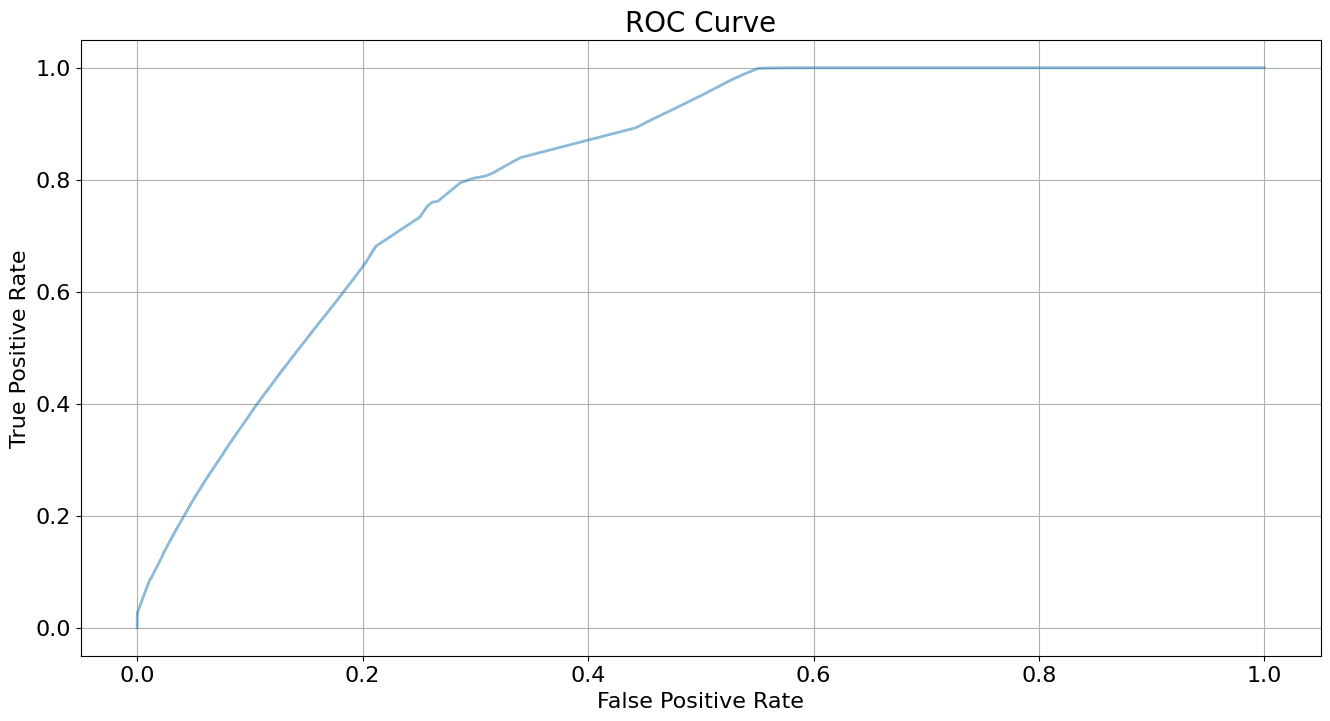

(array([0.00000000e+00, 0.00000000e+00, 5.42637435e-05, ...,
        9.99999655e-01, 9.99999828e-01, 1.00000000e+00]),
 array([0.00000000e+00, 2.99133411e-06, 1.53395613e-02, ...,
        1.00000000e+00, 1.00000000e+00, 1.00000000e+00]),
 array([1.00000000e+00, 9.96813645e-01, 9.96448028e-01, ...,
        6.68330192e-09, 6.65017297e-09, 0.00000000e+00]))

In [20]:
catboost_pool = Pool(data=X_test2, label=y_test)
get_roc_curve(model3, catboost_pool, plot=True)

In [21]:
y_train_pred3 = model3.predict_proba(X_train2)[:, 1]
y_val_pred3 = model3.predict_proba(X_val2)[:, 1]
y_test_pred3 = model3.predict_proba(X_test2)[:, 1]

In [22]:
auc_train3 = roc_auc_score(y_train, y_train_pred3)
ks_train3 = ks_score(y_train, y_train_pred3)
auc_train3, ks_train3

(np.float64(0.9147888798192106), np.float64(64.78364153781897))

In [23]:
auc_val3 = roc_auc_score(y_val, y_val_pred3)
ks_val3 = ks_score(y_val, y_val_pred3)
auc_val3, ks_val3

(np.float64(0.8612770852279557), np.float64(56.610371402761515))

In [24]:
auc_test3 = roc_auc_score(y_test, y_test_pred3)
ks_test3 = ks_score(y_test, y_test_pred3)
auc_test3, ks_test3

(np.float64(0.8203292179844436), np.float64(50.80339232918812))

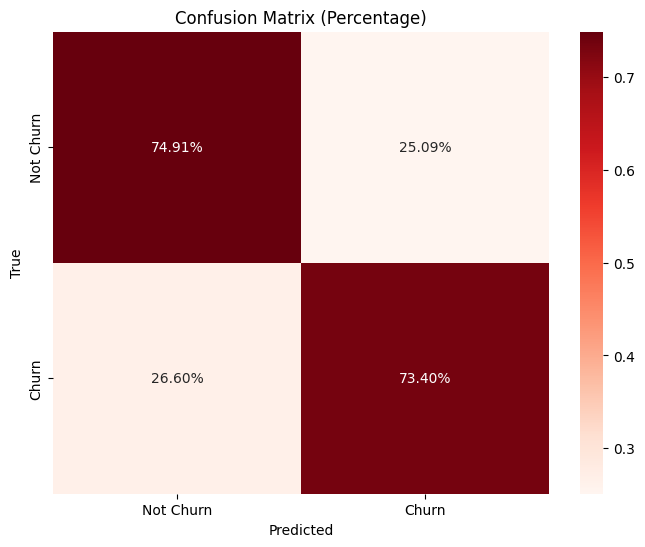

In [25]:
y_test_pred3 = model3.predict(X_test2)
cm = confusion_matrix(y_test, y_test_pred3)

cm_percentage = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]

plt.figure(figsize=(8, 6))
sns.heatmap(cm_percentage, annot=True, fmt='.2%', cmap='Reds',
            xticklabels=['Not Churn', 'Churn'],
            yticklabels=['Not Churn', 'Churn'])
plt.xlabel('Predicted')
plt.ylabel('True')
plt.title('Confusion Matrix (Percentage)')
plt.show()

____

____

______

# 9 - Exame dos modelos em clientes não conhecidos

### Aqui faremos uma avaliação de como os modelos treinados até agora são capazes de generalizar suas predições tratando de novos clientes

In [39]:
spark_treino = spark.createDataFrame(df_treino)
spark_teste = spark.createDataFrame(df_teste)

spark_treino = spark_treino.select('msno', 'churn_target', *features_finais)
spark_teste = spark_teste.select('msno', 'churn_target', *features_finais)

In [40]:
df_novos = spark_teste.join(spark_treino, on='msno', how='left_anti')
df_novos.write.mode('overwrite').parquet('/content/drive/MyDrive/Case_Data_Master/df_novos.parquet')

In [41]:
df_novos = pd.read_parquet('/content/drive/MyDrive/Case_Data_Master/df_novos.parquet')

### ...Para isso, excluímos do dataset de teste todos os clientes que apareceram em qualquer safra do dataset de treino do modelo e computamos AUC e KS:

In [42]:
X_novos, y_novos = df_novos.drop('msno', axis=1), df_novos['churn_target']

## 9.1 - MODEL2

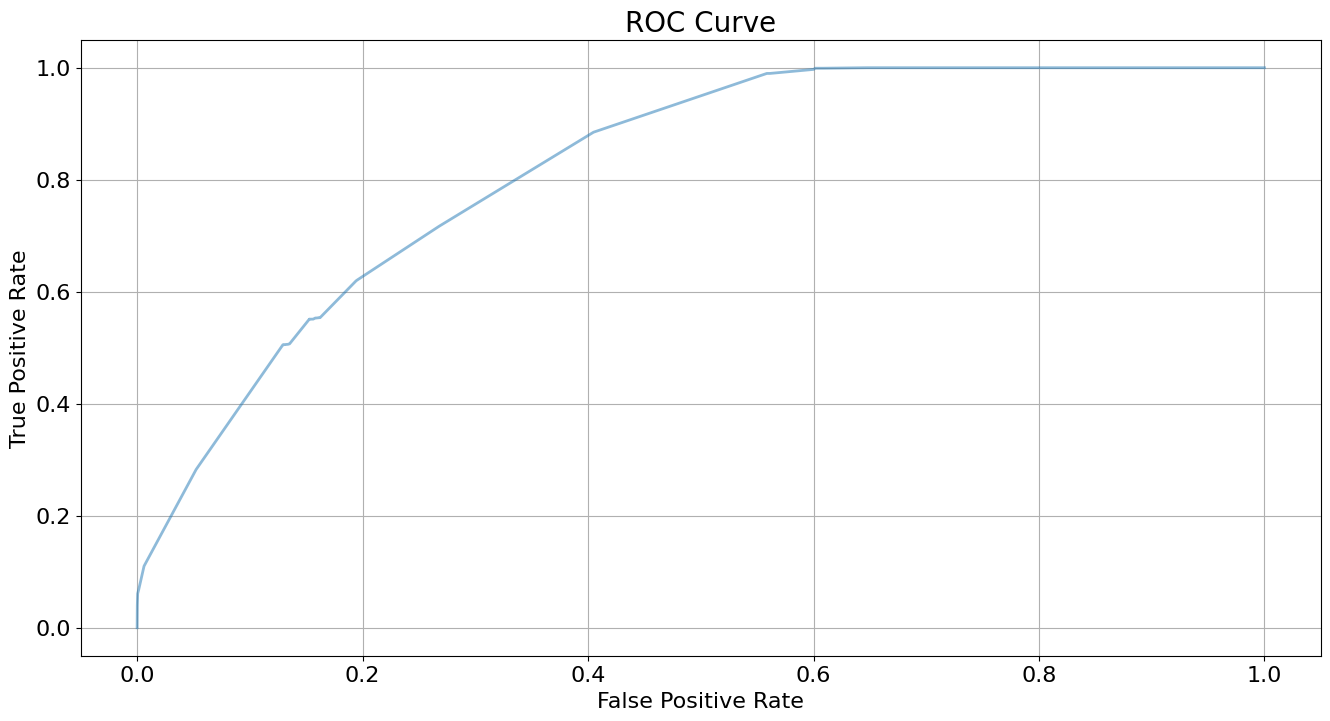

(array([0.00000000e+00, 1.40579725e-04, 1.41042158e-04, 4.67520072e-04,
        4.67982505e-04, 9.32727977e-04, 1.49319714e-03, 6.03290490e-03,
        6.13186563e-03, 6.32932465e-03, 5.23451380e-02, 1.29298664e-01,
        1.29299127e-01, 1.29356931e-01, 1.30617062e-01, 1.30624923e-01,
        1.30625848e-01, 1.33860569e-01, 1.33865656e-01, 1.35192377e-01,
        1.35204400e-01, 1.52707963e-01, 1.52827271e-01, 1.52829121e-01,
        1.52842994e-01, 1.52846231e-01, 1.52846693e-01, 1.52847156e-01,
        1.52847156e-01, 1.52847618e-01, 1.54713074e-01, 1.56194248e-01,
        1.58066640e-01, 1.58106410e-01, 1.58106872e-01, 1.58281672e-01,
        1.58293233e-01, 1.58629884e-01, 1.58701561e-01, 1.58702949e-01,
        1.58703411e-01, 1.58704336e-01, 1.58861563e-01, 1.58893471e-01,
        1.58895783e-01, 1.61712002e-01, 1.61725413e-01, 1.61732349e-01,
        1.61733736e-01, 1.61735586e-01, 1.61744835e-01, 1.61747609e-01,
        1.61748997e-01, 1.62031544e-01, 1.62037093e-01, 1.620874

In [43]:
catboost_pool = Pool(data=X_novos, label=y_novos)
get_roc_curve(model2, catboost_pool, plot=True)

In [45]:
y_test_novos_2 = model2.predict_proba(X_novos)[:, 1]

In [46]:
auc_novos_model2 = roc_auc_score(y_novos, y_test_novos_2)
ks_novos_model2 = ks_score(y_novos, y_test_novos_2)
auc_novos_model2, ks_novos_model2

(np.float64(0.8202728891594129), np.float64(48.00050618960153))

## 9.2 - MODEL3

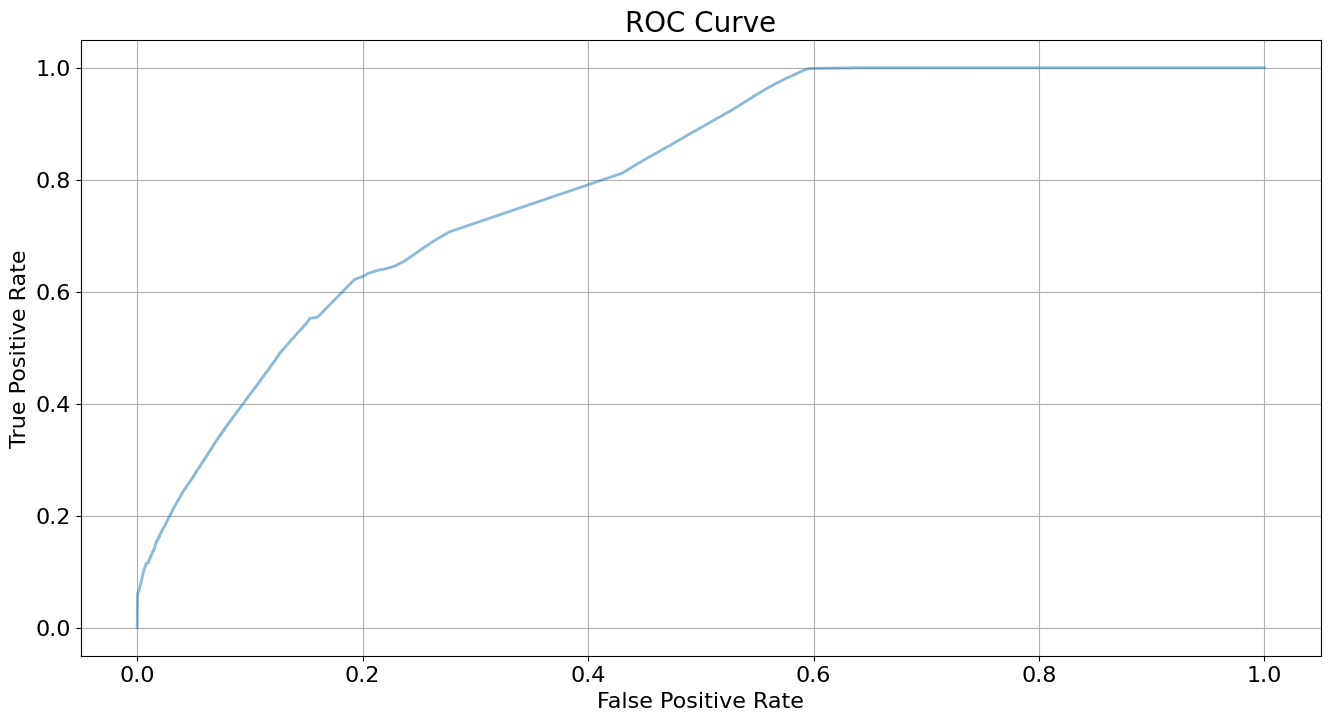

(array([0.00000000e+00, 0.00000000e+00, 1.40579725e-04, ...,
        9.99999075e-01, 9.99999538e-01, 1.00000000e+00]),
 array([0.00000000e+00, 7.76228770e-06, 3.87726271e-02, ...,
        1.00000000e+00, 1.00000000e+00, 1.00000000e+00]),
 array([1.00000000e+00, 9.96813645e-01, 9.96448028e-01, ...,
        7.04200552e-09, 6.98834599e-09, 0.00000000e+00]))

In [44]:
catboost_pool = Pool(data=X_novos, label=y_novos)
get_roc_curve(model3, catboost_pool, plot=True)

In [ ]:
y_test_novos_3 = model3.predict_proba(X_novos)[:, 1]

In [47]:
auc_novos_model3 = roc_auc_score(y_novos, y_test_novos_3)
ks_novos_model3 = ks_score(y_novos, y_test_novos_3)
auc_novos_model3, ks_novos_model3

(np.float64(0.8015480321607358), np.float64(43.004842639222886))

______

_____

______

# 10 - Avaliação Final do Modelo

### Dadas as métricas calculadas acima, seguiremos apenas com model2 para as próximas etapas da resolução do problema, visto que esse é o melhor preditor que conseguimos modelar!

## 10.1 - SAZONALIDADE DAS PREVISÕES DO MODELO

### Vamos abrir as previsões de AUC e KS para cada safra:

In [62]:
metrics_df = calculate_metrics_by_safra(df=pd.concat([df_treino, df_val, df_teste]), model=model2, features=features_finais)\
.sort_values(by='safra', ascending=True)
metrics_df

safra       AUC         KS
10  201501  0.974037  84.216616
9   201502  0.976496  83.866577
8   201503  0.978093  84.702690
7   201504  0.971696  85.757210
6   201505  0.979827  85.677286
5   201506  0.941735  73.852794
4   201507  0.939748  75.581163
3   201508  0.918691  77.485153
2   201509  0.794889  50.794059
1   201510  0.853412  64.135573
0   201511  0.860435  58.304180
11  201601  0.980023  87.352357
15  201602  0.985130  88.222116
14  201603  0.800446  45.307302
13  201604  0.860231  61.844305
12  201605  0.804926  39.531407
22  201607  0.978662  86.901980
21  201608  0.976359  86.241905
20  201609  0.974068  85.613599
19  201610  0.920182  73.726520
18  201611  0.671043  25.539214
17  201612  0.674118  30.346155
16  201701  0.629326  21.194497

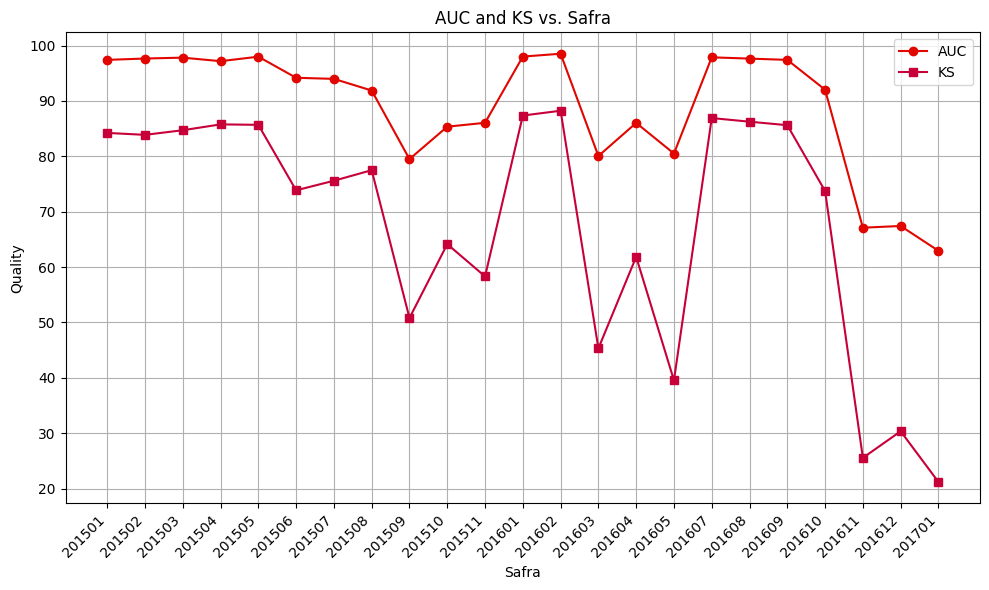

In [128]:
plt.figure(figsize=(10, 6))

plt.plot(metrics_df['safra'], metrics_df['AUC']*100, marker='o', color='#E10600', label='AUC')
plt.plot(metrics_df['safra'], metrics_df['KS'], marker='s', color='#C70039', label='KS')

plt.xlabel('Safra')
plt.ylabel('Quality')
plt.title('AUC and KS vs. Safra')
plt.legend()
plt.grid(True)
plt.xticks(rotation=45, ha='right')

plt.tight_layout()
plt.show()

## A vertiginosa queda das métricas do modelo é curiosa: por um lado, pode sinalizar uma possível perda de performance com o passar do tempo, resultado de um overfitting sutil, mas por outro lado pode ser apenas uma repetição de padrões já enfrentados nos dados de treino, sobre os quais a performance do modelo já mostrou dificuldades no mês de junho e nos últimos meses do ano.

## 10.2 - LIFT

O Lift avalia como o modelo prioriza os casos mais importantes, traduzindo isso em uma concentração de churns nos buckets com maior probabilidade.

In [64]:
X = X_test2
Y = y_test

df_lift = X.copy()
df_lift['prob'] = model2.predict_proba(X)[:, 1]
df_lift['churn'] = Y
df_lift['predict'] = model2.predict(X)

In [65]:
lift(df_lift, qcut=True)

<ipython-input-7-e4136dfcb59e>:168: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  lift = df.groupby('bucket').agg(['count', 'sum'])['churn'].sort_index(ascending=False)


Número de clientes  Número de churns  Churn acumulados   % churn  \
bucket                                                                     
10                  613928            114769            114769  0.186942   
9                   613928             82445            197214  0.134291   
8                   613928             57128            254342  0.093053   
7                   613928             40315            294657  0.065667   
6                   613928             27548            322205  0.044872   
5                   613928             12005            334210  0.019554   
4                   613928                89            334299  0.000145   
3                   613928                 0            334299  0.000000   
2                   613928                 0            334299  0.000000   
1                   613928                 0            334299  0.000000   

         % events      LIFT check  
bucket                             
10      34.331242  3.433124    OK  
9       24.662054  2.466205    OK  
8       17.088893  1.708889    OK  
7       12.059563  1.205956    OK  
6        8.240527  0.824053    --  
5        3.591097  0.359110    --  
4        0.026623  0.002662    --  
3        0.000000  0.000000    --  
2        0.000000  0.000000    --  
1        0.000000  0.000000    --

## Um modelo eficiente deve concentrar a maior parte dos churns nos buckets superiores... Aqui, quase 90% dos casos de churn estão concentrados nos top 40% de probabilidades fornecidas pelo modelo, o que é muito bom, mostrando que o modelo é altamente eficiente para discriminação dos casos de churn.

## 10.3 - PSI

O Population Stability Index (PSI) compara a distribuição dos scores de probabilidade preditos entre dois datasets (treino vs. validação ou treino vs. teste, por exemplo). Ele serve como uma métrica de quanto a população mudou ao longo do tempo, segundo os scores atribuídos pelo modelo.

In [69]:
X_test = trata_nulos(X_test2)
X_val = trata_nulos(X_val2)
X_train = trata_nulos(X_train2)

df_train = X_train.copy()
df_val = X_val.copy()
df_teste = X_test.copy()

df_train['prob'] = model2.predict_proba(X_train)[:, 1]
df_val['prob'] = model2.predict_proba(X_val)[:, 1]
df_teste['prob'] = model2.predict_proba(X_test)[:, 1]

<ipython-input-67-ca9947e38e93>:9: FutureWarning: DataFrame.replace without 'value' and with non-dict-like 'to_replace' is deprecated and will raise in a future version. Explicitly specify the new values instead.
  df[cat_cols] = df[cat_cols].replace({'nan', 'None'})
<ipython-input-67-ca9947e38e93>:9: FutureWarning: DataFrame.replace without 'value' and with non-dict-like 'to_replace' is deprecated and will raise in a future version. Explicitly specify the new values instead.
  df[cat_cols] = df[cat_cols].replace({'nan', 'None'})
<ipython-input-67-ca9947e38e93>:9: FutureWarning: DataFrame.replace without 'value' and with non-dict-like 'to_replace' is deprecated and will raise in a future version. Explicitly specify the new values instead.
  df[cat_cols] = df[cat_cols].replace({'nan', 'None'})
<ipython-input-67-ca9947e38e93>:10: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the cav

In [70]:
psi(df_train['prob'], df_val['prob'])

<ipython-input-67-ca9947e38e93>:197: RuntimeWarning: invalid value encountered in divide
  psi_values = (ratios1 - ratios2) * np.log(ratios1 / ratios2)


np.float64(0.3454619243153108)

In [71]:
psi(df_train['prob'], df_teste['prob'])

<ipython-input-67-ca9947e38e93>:197: RuntimeWarning: invalid value encountered in divide
  psi_values = (ratios1 - ratios2) * np.log(ratios1 / ratios2)


np.float64(0.2873057839413501)

In [72]:
psi(df_val['prob'], df_teste['prob'])

<ipython-input-67-ca9947e38e93>:197: RuntimeWarning: invalid value encountered in divide
  psi_values = (ratios1 - ratios2) * np.log(ratios1 / ratios2)


np.float64(0.09934933097329227)

## A comparação entre os diferentes resultados de PSI mostra que a população de clientes tem sido apresentado flutuações significantes em comparação com os dados usados para treinar o modelo, que deve, portanto, ser testado com cautela em novas safras e possivelmente retreinado com safras mais atuais.

## 10.4 - CSI

É o Characteristic Stability Index, que é similar ao PSI, mas geralmente usado para comparar a distribuição das features do modelo, não do score. Serve para detectar drift em variáveis entre períodos diferentes, como entre treino e teste ou treino e validação.

In [73]:
csi_train_test = csi(X_train2, X_test2)
csi_train_test

<ipython-input-67-ca9947e38e93>:9: FutureWarning: DataFrame.replace without 'value' and with non-dict-like 'to_replace' is deprecated and will raise in a future version. Explicitly specify the new values instead.
  df[cat_cols] = df[cat_cols].replace({'nan', 'None'})
<ipython-input-67-ca9947e38e93>:9: FutureWarning: DataFrame.replace without 'value' and with non-dict-like 'to_replace' is deprecated and will raise in a future version. Explicitly specify the new values instead.
  df[cat_cols] = df[cat_cols].replace({'nan', 'None'})
/usr/local/lib/python3.11/dist-packages/pandas/core/arraylike.py:399: RuntimeWarning: divide by zero encountered in log
  result = getattr(ufunc, method)(*inputs, **kwargs)
<ipython-input-67-ca9947e38e93>:260: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupi

variavel       CSI
0          actual_amount_paid  0.000021
1      actual_plan_list_price  0.000024
2  diff3_engagement_per_track  0.000024
3               diff3_num_unq  0.000004
4                    fidelity  0.000015
5               is_auto_renew  0.004204
6                  plan_value  0.000002
7               slope_num_unq  0.000023
8                  total_secs  0.003935

In [74]:
csi_train_val = csi(X_train2, X_val2)
csi_train_val

<ipython-input-67-ca9947e38e93>:9: FutureWarning: DataFrame.replace without 'value' and with non-dict-like 'to_replace' is deprecated and will raise in a future version. Explicitly specify the new values instead.
  df[cat_cols] = df[cat_cols].replace({'nan', 'None'})
<ipython-input-67-ca9947e38e93>:9: FutureWarning: DataFrame.replace without 'value' and with non-dict-like 'to_replace' is deprecated and will raise in a future version. Explicitly specify the new values instead.
  df[cat_cols] = df[cat_cols].replace({'nan', 'None'})
/usr/local/lib/python3.11/dist-packages/pandas/core/arraylike.py:399: RuntimeWarning: divide by zero encountered in log
  result = getattr(ufunc, method)(*inputs, **kwargs)
<ipython-input-67-ca9947e38e93>:260: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupi

variavel       CSI
0          actual_amount_paid  0.088473
1      actual_plan_list_price  0.088473
2  diff3_engagement_per_track  0.000009
3               diff3_num_unq  0.000006
4                    fidelity  0.000007
5               is_auto_renew  0.000079
6                  plan_value  0.000005
7               slope_num_unq  0.000004
8                  total_secs  0.005504

In [75]:
csi_val_test = csi(X_val2, X_test2)
csi_val_test

<ipython-input-67-ca9947e38e93>:9: FutureWarning: DataFrame.replace without 'value' and with non-dict-like 'to_replace' is deprecated and will raise in a future version. Explicitly specify the new values instead.
  df[cat_cols] = df[cat_cols].replace({'nan', 'None'})
<ipython-input-67-ca9947e38e93>:9: FutureWarning: DataFrame.replace without 'value' and with non-dict-like 'to_replace' is deprecated and will raise in a future version. Explicitly specify the new values instead.
  df[cat_cols] = df[cat_cols].replace({'nan', 'None'})
/usr/local/lib/python3.11/dist-packages/pandas/core/arraylike.py:399: RuntimeWarning: divide by zero encountered in log
  result = getattr(ufunc, method)(*inputs, **kwargs)
<ipython-input-67-ca9947e38e93>:260: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupi

variavel       CSI
0          actual_amount_paid  0.000008
1      actual_plan_list_price  0.000003
2  diff3_engagement_per_track  0.000009
3               diff3_num_unq  0.000022
4                    fidelity  0.000010
5               is_auto_renew  0.005434
6                  plan_value  0.133373
7               slope_num_unq  0.000025
8                  total_secs  0.000157

## Apesar dos resultados sombrios do PSI, o cálculo de CSI indica que apenas as variáveis 'actual_amount_paid' e 'actual_plan_list_price' tiveram mudanças expressivas (CSI próximos de 0.1) entre os datasets de treino e validação, possivelmente as responsáveis por valores tão altos de PSI entre esses dois datasets. Se este modelo for levado para produção, seria prudente monitorar essas variáveis e, possivelmente, retreinar o model2 sem elas, caso essa instabilidade permaneça.

____

___

_____

# 11 - Clustering - Aprendizado Não-supervisionado

### Com o objetivo de aprofundar a compreensão sobre as características dos clientes, realizamos também uma análise não-supervisionada:

In [77]:
df_treino = pd.read_parquet('/content/drive/MyDrive/Case_Data_Master/df_treino.parquet')
df_val = pd.read_parquet('/content/drive/MyDrive/Case_Data_Master/df_val.parquet')
df_teste = pd.read_parquet('/content/drive/MyDrive/Case_Data_Master/df_teste.parquet')

### Análises não-supervisionadas referem-se, em geral, a agrupamentos dos dados onde tentamos extrair a divisão mais natural possível dos dados em nosso dataset. Em nosso caso, iremos buscar padrões que indiquem se um grupo de clientes específico tem mais propensão ao churn - ou menos propensão, o que indicaria potenciais alvos de campanhas para aumentar seu LTV, por exemplo.

In [78]:
drop_cols = ['msno', 'segment_id', 'safra', 'churn_target']
features_clust = features_finais

# aqui iremos trabalhar apenas com features numéricas, listadas acima como 'features_clust'

X_train, y_train = df_treino.drop(drop_cols, axis=1)[features_clust], df_treino['churn_target']
X_val, y_val = df_val.drop(drop_cols, axis=1)[features_clust], df_val['churn_target']
X_test, y_test = df_teste.drop(drop_cols, axis=1)[features_clust], df_teste['churn_target']

### Antes de começarmos a clusterizar nossos dados, eles precisam ser tratados em duas etapas: 'Imputação', para preenchimento dos registros NULL presentes nos datasets com um valor fixo; e 'Padronização', para trazer todos os dados à mesma escala, possibilitando assim o estabelecimento de padrões justos entre as features que tem valores em ordens de grandeza muito distintas (por exemplo, 'num_secs' está sempre na ordem dos milhares, enquanto a maioria das outras features encontra-se na ordem das unidades)

In [79]:
# Imputação
imputer = SimpleImputer(strategy='median')
X_train_imputed = imputer.fit_transform(X_train)
X_val_imputed   = imputer.transform(X_val)
X_test_imputed  = imputer.transform(X_test)

# Padronização
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train_imputed)
X_val_scaled   = scaler.transform(X_val_imputed)
X_test_scaled  = scaler.transform(X_test_imputed)

### Agora buscamos pela quantidade de clusters/grupos que melhor divide o nosso conjunto de dados. Para isso, usamos 3 métricas:
### - inércia: é a soma dos quadrados das distâncias de cada ponto até o centróide do cluster --> mede o quão compacto cada cluster é;
### - índice de Calinski-Harabasz: é a razão entre a dispersão inter-clusters e a dispersão intra-clusters --> mede a separação e o quão compactos os cluster são;
### - índice de Davies-Bouldin: é a média da similaridade entre cada cluster e o cluster mais similar a ele --> mede a sobreposição entre clusters, que é indesejável.

In [124]:
inertias = []
calinskis = []
davies = []
k_range = range(2, 30)
for k in k_range:
    kmeans = KMeans(n_clusters=k, n_init='auto', random_state=42)
    labels = kmeans.fit_predict(X_train_scaled)
    inertias.append(kmeans.inertia_)
    calinskis.append(calinski_harabasz_score(X_train_scaled, labels))
    davies.append(davies_bouldin_score(X_train_scaled, labels))

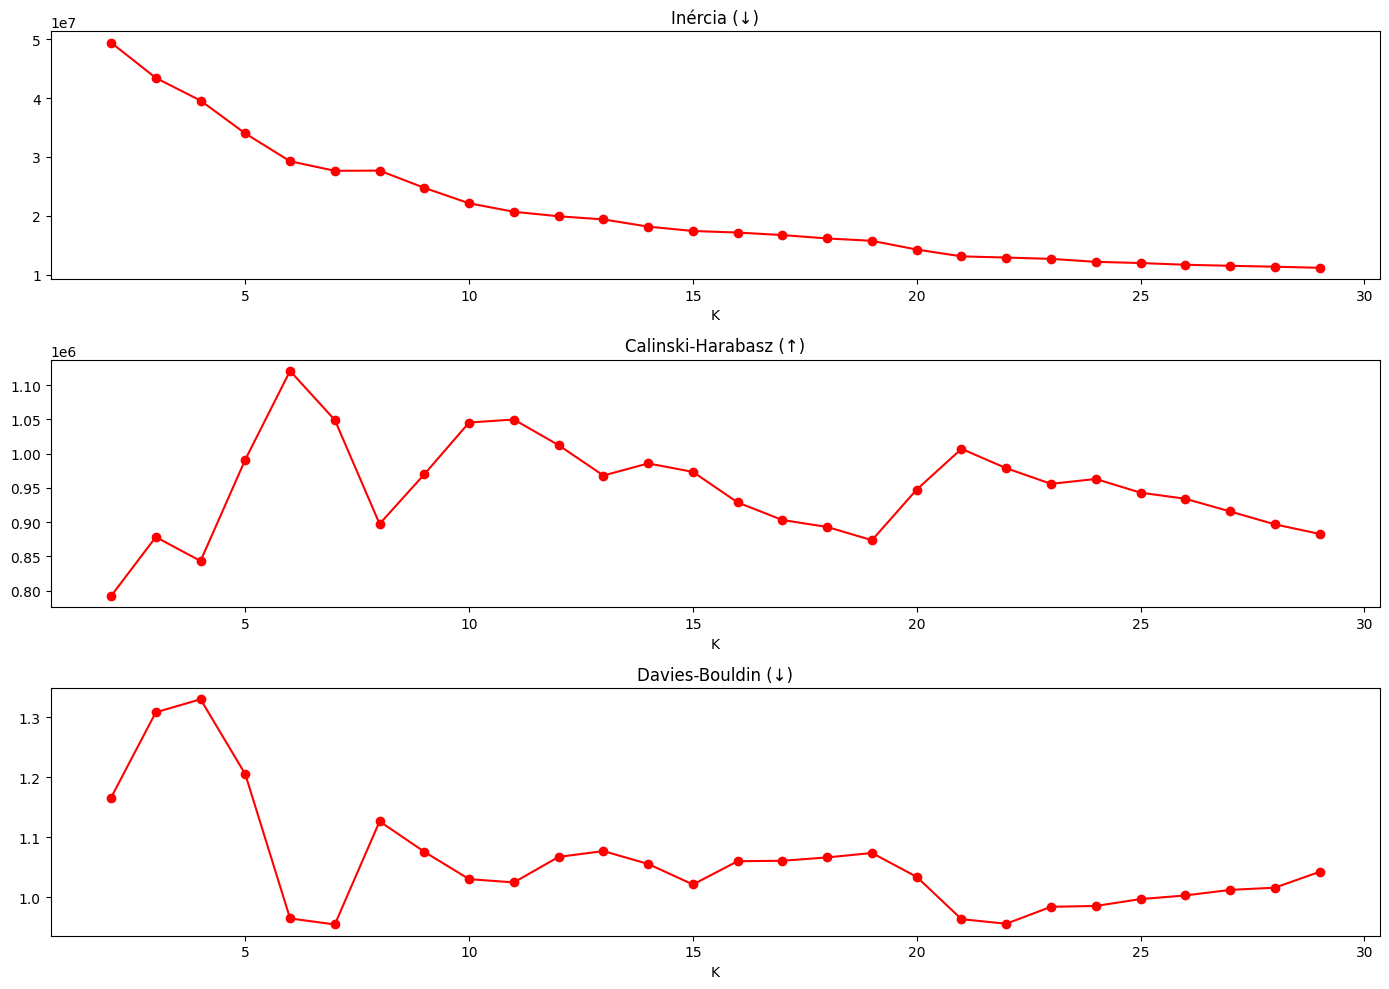

In [125]:
plt.figure(figsize=(14, 10))

plt.subplot(3, 1, 1)
plt.plot(k_range, inertias, marker='o', color='red')
plt.title('Inércia (↓)')
plt.xlabel('K')

plt.subplot(3, 1, 2)
plt.plot(k_range, calinskis, marker='o', color='red')
plt.title('Calinski-Harabasz (↑)')
plt.xlabel('K')

plt.subplot(3, 1, 3)
plt.plot(k_range, davies, marker='o', color='red')
plt.title('Davies-Bouldin (↓)')
plt.xlabel('K')
plt.tight_layout()
plt.show()

## Analisadas em conjunto, essas 3 métricas nos mostram que a melhor divisão ocorre quando agrupamos nossos dados em 6 clusters!

In [81]:
best_k = 6  # definido com base no resultado da inércia e dos índices de Calinski-Harabasz e Davies-Bouldin

kmeans = KMeans(n_clusters=best_k, n_init='auto', random_state=42)
train_clusters = kmeans.fit_predict(X_train_scaled)
val_clusters   = kmeans.predict(X_val_scaled)
test_clusters  = kmeans.predict(X_test_scaled)

# adiciona rótulos de cluster aos dataframes originais
df_treino['cluster'] = train_clusters
df_val['cluster']   = val_clusters
df_teste['cluster']  = test_clusters

### Vamos então desenvolver algumas análises sobre os diferentes perfis/clusters encontrados em nossos dados...

## 11.1 - NOS DADOS DE TREINO




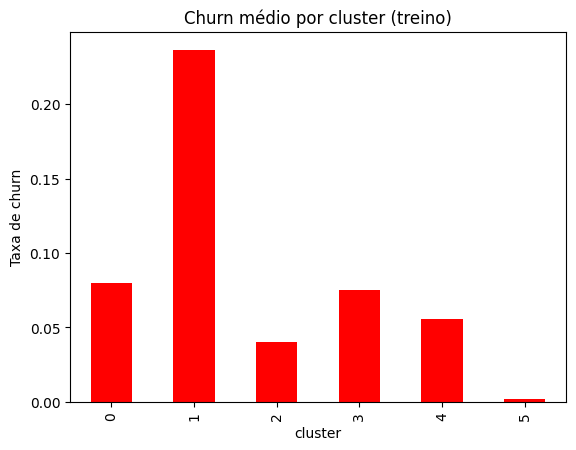

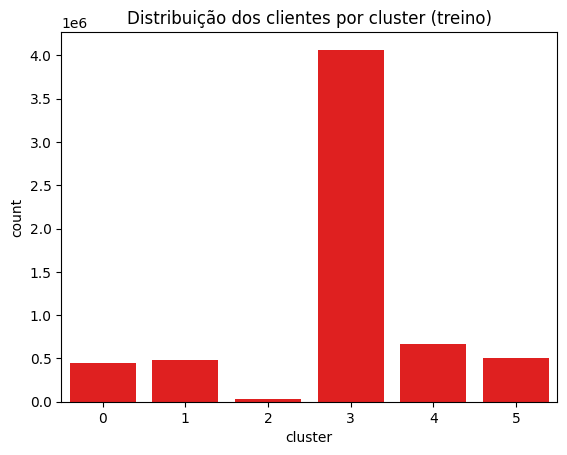

In [121]:
# distribuição da target por cluster no treino
df_treino.groupby('cluster')['churn_target'].mean().plot(kind='bar', color='red', title='Churn médio por cluster (treino)')
plt.ylabel('Taxa de churn')
plt.show()

# número de clientes por cluster no treino
sns.countplot(data=df_treino, color='red', x='cluster')
plt.title('Distribuição dos clientes por cluster (treino)')
plt.show()

## Aqui temos alguns clusters que chamam particular atenção:

## - cluster 1: embora sua presença no dataset de treino seja mediana, como a maioria dos outros clusters, sua taxa de churn é mais que o dobro em comparação com os outros clusters - clientes cujas características lhes trazem a esse cluster tem probabilidade muito alta de serem churn dentro de 3 meses!
## - cluster 2: mesmo que sua representatividade seja baixíssima, sua taxa média de churn é relativamente alta, então, também para este cluster clientes com essas características tendem a serem churn dentro de 3 meses!
## - cluster 5: tem uma representatividade mediana, mas uma baixíssima taxa de churn - este grupo de clientes é um potencial alvo ideal para campanhas de aumento de LTV!

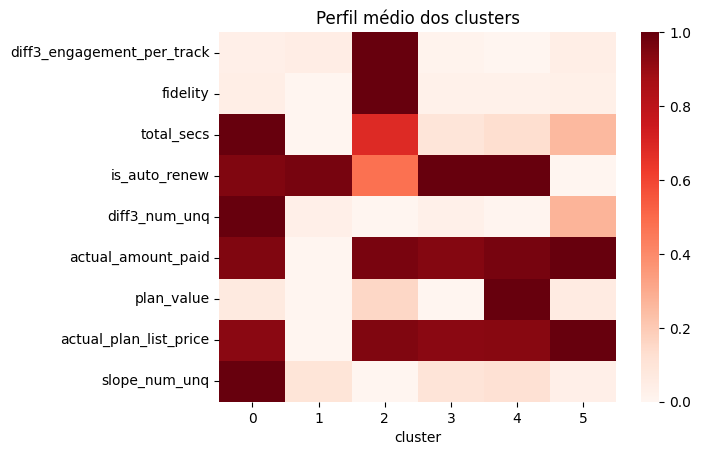

In [120]:
# perfil médio de features por cluster
cluster_means = df_treino[[*features_clust, 'cluster']].groupby('cluster').mean(numeric_only=True)
cluster_means_norm = (cluster_means - cluster_means.min()) / (cluster_means.max() - cluster_means.min())
sns.heatmap(cluster_means_norm.T, cmap='Reds')
plt.title('Perfil médio dos clusters')
plt.show()

## Esse heatmap mostra algo curioso: ao contrário do senso comum que suporia os diametralmente opostos clusters 1 e 5 (alto churn e baixo churn, respectivamente) como tendo todas as features em faixas diferentes, percebemos que suas diferenças estão concentradas apenas nas features 'is_auto_renew', 'actual_plan_list_price' e 'actual_amount_paid'! A propósito, a feature 'is_auto_renew' se destaca no cluster 5: clientes que não tem renovação automática são muito menos propensos ao churn! Essa é outra conclusão que desafia expectativas.

## 11.2 - NOS DADOS DE VALIDAÇÃO

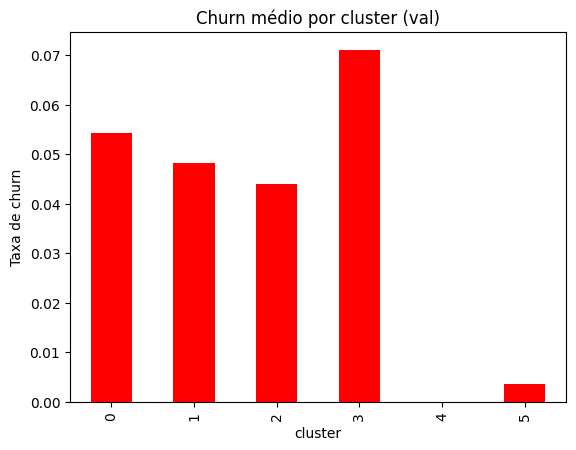

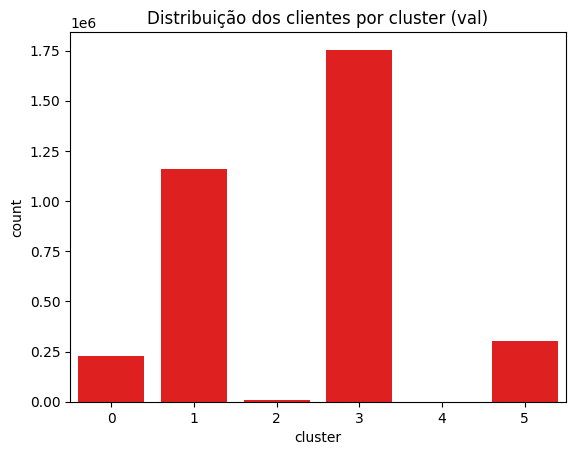

In [119]:
# distribuição da target por cluster no val
df_val.groupby('cluster')['churn_target'].mean().plot(kind='bar', color='red', title='Churn médio por cluster (val)')
plt.ylabel('Taxa de churn')
plt.show()

# número de clientes por cluster no val
sns.countplot(data=df_val, color='red', x='cluster')
plt.title('Distribuição dos clientes por cluster (val)')
plt.show()

## Em comparação com as taxas de churn do dataset de treino, essas do dataset de validação estão baixas, mas a análise isolada apenas dos clusters neste grupo nos confirma o alto potencial de churn do cluster 2 - baixíssima representatividade e relativamente alta taxa de churn. O cluster 5 é reforçado como escasso em churns, repetindo o padrão encontrado nos dados de treino.

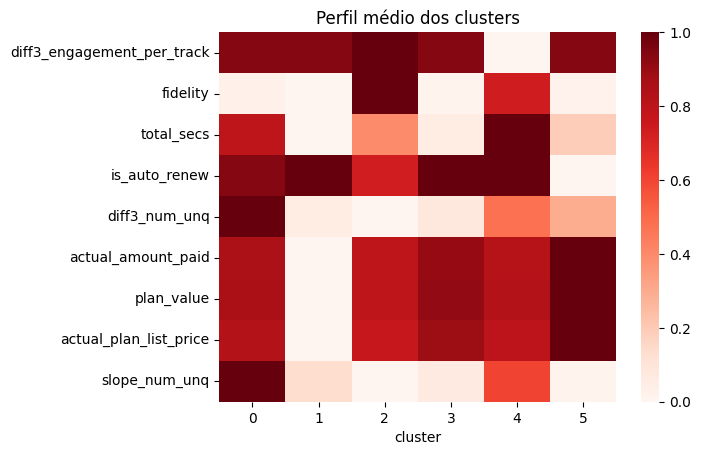

In [122]:
# perfil médio de features por cluster
cluster_means = df_val[[*features_clust, 'cluster']].groupby('cluster').mean(numeric_only=True)
cluster_means_norm = (cluster_means - cluster_means.min()) / (cluster_means.max() - cluster_means.min())
sns.heatmap(cluster_means_norm.T, cmap='Reds')
plt.title('Perfil médio dos clusters')
plt.show()

## Em concordância com os resultados fornecidos pelos clusters do dataset de treino, vemos aqui os cliente sem renovação automática novamente com baixa taxa de churn (cluster 5); e, novamente contra o senso-comum, outro padrão se repete: os clientes com maiores 'fidelity' estão entre os mais propensos a churn!

## 11.3 - NOS DADOS DE TESTE

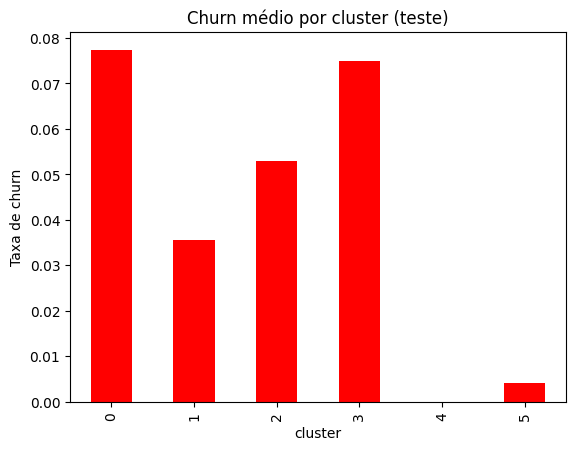

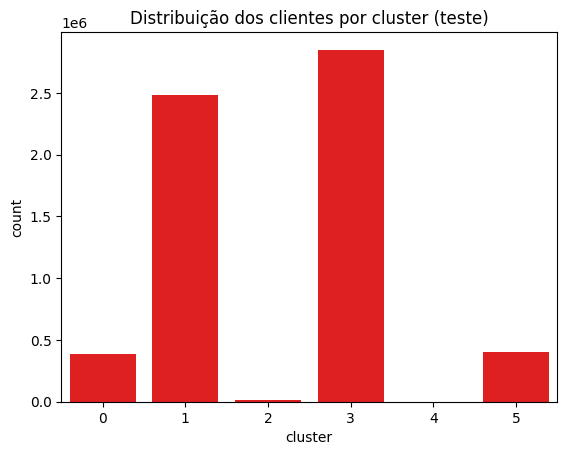

In [117]:
# distribuição da target por cluster no teste
df_teste.groupby('cluster')['churn_target'].mean().plot(kind='bar', color='red', title='Churn médio por cluster (teste)')
plt.ylabel('Taxa de churn')
plt.show()

# número de clientes por cluster no teste
sns.countplot(data=df_teste, x='cluster', color='red')
plt.title('Distribuição dos clientes por cluster (teste)')
plt.show()

## Aqui continuamos a ver o padrão do cluster 5 com baixíssimo nível relativo de churn em oposição, principalmente, ao cluster 2, que tem baixa representatividade nos dados de teste, mas taxa de churn muito elevada. Aqui, o cluster 0 também desponta como foco relativo de clientes churn, principalmente devido à sua baixa volumetria.

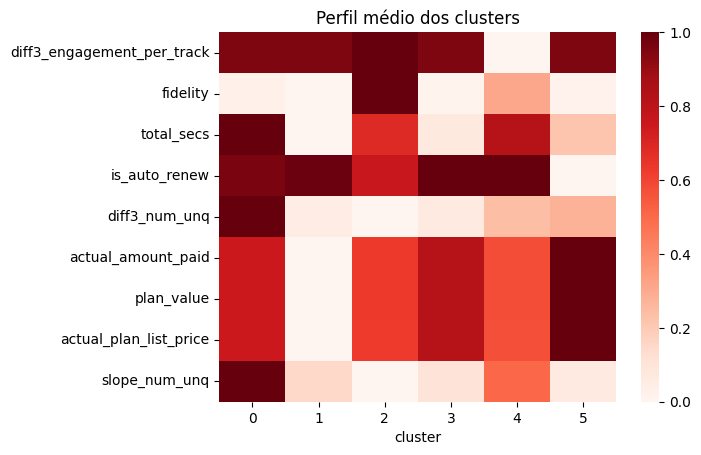

In [123]:
# perfil médio de features por cluster
cluster_means = df_teste[[*features_clust, 'cluster']].groupby('cluster').mean(numeric_only=True)
cluster_means_norm = (cluster_means - cluster_means.min()) / (cluster_means.max() - cluster_means.min())
sns.heatmap(cluster_means_norm.T, cmap='Reds')
plt.title('Perfil médio dos clusters')
plt.show()

## Mais um padrão se repete: clientes com altos valores de 'slope_num_unq', 'diff3_num_unq' e 'total_secs' estão juntos no cluster 0 - aqui com alto % de churn.
## Curiosamente, clientes com os mais baixos 'slope_num_unq' e 'diff3_num_unq' estão ligados a uma alta taxa de churn se tiverem altas 'fidelity' e 'diff3_engagement_per_track' - estão agrupados no cluster 2! Contudo, se esses clientes tiverem todas essas características, exceto alta fidelidade - aqui estamos falando de clientes que escutam muitas músicas diferentes -, então eles são colocados no cluster 5, com baixa propensão a churn!

## Finalmente, seria interessante em projetos futuros construir um modelo supervisionado que use o número do cluster como uma feature. Provavelmente, a capacidade discriminatória do modelo aumentaria ainda mais!

_______

______

_____

# 12 - Análise de retorno financeiro

### Os eventos registrados nas matrizes de confusão até agora neste notebook correspondem a safras, e não a clientes, então precisamos de uma função que encontre quantos clientes, de fato, podem ser considerados verdadeiros positivos, assim como verdadeiros negativos, falsos positivos e falsos negativos

In [23]:
X, y = df_teste[['msno', *features_finais]], y_test

In [24]:
confusion_matrix_por_cliente(model2, X, y)

{'TN': 503565, 'FP': 465342, 'TP': 107397, 'FN': 29159}

## O problema propõe que encontremos o número de clientes retidos por uma política que impediria o churn de 50% dos verdadeiros positivos, então podemos afirmar que, seguindo as recomendações do model2, conseguiríamos reter, pelo menos, 53698 clientes entre julho-2016 e janeiro-2017!

### Vamos seguir com uma análise um pouco mais profunda do impacto financeiro dessa ação:

In [28]:
print(f"Média ponderada do valor pago no treino: {weighted_average_actual_amount(df_treino)}")
print(f"Média ponderada do valor pago na validação: {weighted_average_actual_amount(df_val)}")
print(f"Média ponderada do valor pago no teste: {weighted_average_actual_amount(df_teste)}")

Média ponderada do valor pago no treino: 147.15113495555786
Média ponderada do valor pago na validação: 136.6558709255294
Média ponderada do valor pago no teste: 130.41859804239687


In [4]:
valor_medio_mensal = (147.151+136.656+130.418)/3
print(f'O valor médio que um cliente paga ao Musicfy é de NT$ {valor_medio_mensal:.03f}')

O valor médio que um cliente paga ao Musicfy é de NT$ 138.075


In [101]:
# a receita mensal é uma estimativa razoável de quanto um cliente médio paga por mês
receita_mensal = 138.075

# o tempo de reativação é o tempo (dentro de um ano) que a empresa irá ter de receita para os clientes que iriam dar churn,
# mas aceitaram a proposta de continuar clientes com 3 meses gratuitos
tempo_reativacao = 9

# a taxa de adesão é dada pelo problema: 50% dos verdadeiros positivos para churn irão aceitar a ação e continuar na base por
# mais 1 ano, sendo 3 meses gratuitos
taxa_adesao = 0.5

# o custo da ação equivale ao custo que a empresa terá para manter os clientes por 3 meses, ou seja,
# quanto de dinheiro a empresa deixará de ganhar (receita mensal * 3)
custo_acao = receita_mensal * 3

### Com base nessas premissas, e tendo as quantidades de clientes que irão participar da ação de retenção (todos que o modelo classificou como churn/positivos!), temos:

In [38]:
ROI(tp=107397, fp=465342)

'A ação apresentará um lucro líquido de NT$ 407755841.0 e um ROI de 171.87%'

## Assim, espera-se que o ROI mínimo com a utilização deste modelo seja de 171.87%, com um lucro estimado de NT$ 58 milhões ao mês!

______

_____

_____